In [1]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import matplotlib.gridspec as gridspec
%matplotlib inline  

In [2]:
from short_term.dataset_h36m import dataset, subjects_train, subjects_valid, short_term_weights_path

In [3]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, SimpleRNN
from keras.utils.vis_utils import plot_model
import pickle

/Users/ldalmeida/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import tensorflow as tf
import tflearn
import tensorflow.contrib.layers as tflayers
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from complex_valued_models.ComplexRNN import ComplexRNNCell
from complex_valued_models.URNN import URNNCell

### Load and prepare the dataset

In [5]:
sequences_train = []
sequences_valid = []
sequences_test = []
subjects_train = ['S1', 'S7', 'S8', 'S9', 'S11']
subjects_valid = ['S6']
subjects_test = ['S5']
for subject in subjects_train:
    for action in dataset[subject].keys():
        sequences_train.append((subject, action))
for subject in subjects_valid:
    for action in dataset[subject].keys():
        sequences_valid.append((subject, action))
for subject in subjects_test:
    for action in dataset[subject].keys():
        sequences_test.append((subject, action))
        
print('Training on %d sequences, validating on %d sequences.' % (len(sequences_train), len(sequences_valid)))

dataset.compute_euler_angles(order='zyx')
dataset.compute_positions()

Training on 300 sequences, validating on 60 sequences.


## Human3.6M Visualization

<IPython.core.display.Javascript object>


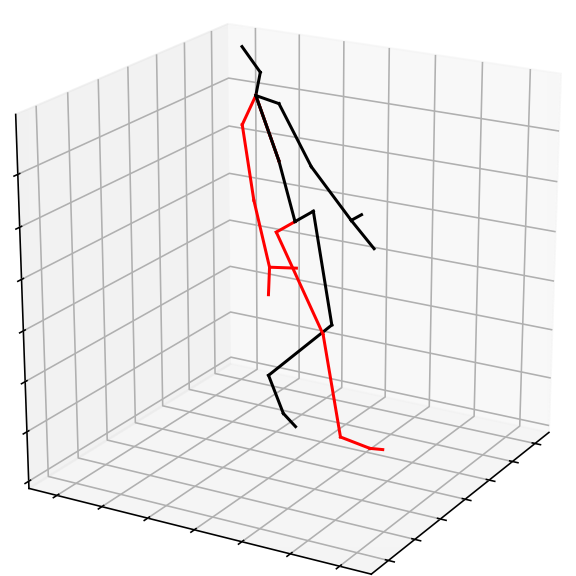

In [6]:
from common.visualization import render_animation
from IPython.display import HTML
%matplotlib notebook
anim = render_animation(dataset['S1']['walking_1_d0']['positions_world'][:150], dataset.skeleton(), 
                        dataset.fps(), output='interactive')

In [8]:
batch_size=60
n_epochs=3000
prefix_length=0
target_length = 20
sequences=sequences_train
def _prepare_next_batch_impl(batch_size, dataset, target_length, sequences):
    buffer_in = np.zeros((batch_size, prefix_length+target_length, 32*3), dtype='float32')
    buffer_out = np.zeros((batch_size, target_length, 32*3), dtype='float32')

    sequences = np.random.permutation(sequences)

    batch_idx = 0
    for i, (subject, action) in enumerate(sequences):
        # Pick a random chunk from each sequence
        start_idx = np.random.randint(0, dataset[subject][action]['positions_world'].shape[0] - prefix_length - target_length + 1)
        mid_idx = start_idx + prefix_length
        end_idx = start_idx + prefix_length + target_length

        buffer_in[batch_idx] = dataset[subject][action]['positions_world'][start_idx:end_idx].reshape( \
                                              prefix_length+target_length, -1)
        buffer_out[batch_idx] = dataset[subject][action]['positions_world'][mid_idx:end_idx].reshape( \
                                              target_length, -1)

        batch_idx += 1
        if batch_idx == batch_size or i == len(sequences) - 1:
            yield buffer_in[:batch_idx], buffer_out[:batch_idx]
            batch_idx = 0

### Prepare train and test batches

In [9]:
for batch_in, batch_out in _prepare_next_batch_impl(batch_size, dataset, target_length, sequences_train):
    # Pick a random chunk from each sequence
    train_inputs = batch_in
    train_outputs = batch_out

## Real valued neural networks

Based on research (the 2012 Stanford publication titled Deep Learning for Time Series Modeling by Enzo Busseti, Ian Osband, and Scott Wong), I will skip experimenting with deep feed-forward neural networks and directly start experimenting with a deep, recurrent neural network because it uses LSTM layers. Using LSTM layers is a way to introduce memory to neural networks that makes them ideal for analyzing time-series and sequence data.
### Data pre-processing for Keras neural networks

LSTMs want their input to contain windows of times. This way instead of 2500 samples per dimension we have 250 batches of length 10. Here, the objective is given the last 10 time steps of the signal predict the future 10.

In [10]:
timesteps = 20
dim = 96
samples = 60

In [11]:
losses = []
 
def handleLoss(loss):
        global losses
        losses+=[loss]
        print(loss)
 
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
 
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        handleLoss(logs.get('loss'))

### Simple Recurrent Neural Network

In [12]:
# Build neural network
def _simple_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(520,input_shape=(timesteps,dim), return_sequences=True))
    model.add(Dense(dim))
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [13]:
mod_2 = _simple_rnn_model()
plot_model(mod_2, to_file='plots/simpleRNN_humanmotion_model.png', show_shapes=True, show_layer_names=True)
print(mod_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 520)           320840    
_________________________________________________________________
dense_1 (Dense)              (None, 20, 96)            50016     
Total params: 370,856
Trainable params: 370,856
Non-trainable params: 0
_________________________________________________________________
None


### LSTM Neural Networks

In [14]:
from keras import regularizers
# design network
def _deep_lstm_model():
    model = Sequential()

    # test with 5 sequential layers
    # single layer with more units
    # weight reg and drop outs
    """model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True, dropout=0.2, 
                   bias_regularizer=regularizers.l1(0.01)))"""
    model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
    model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
    model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
    model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
    model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
    model.add(Dense(3))
    model.compile(loss='mae', optimizer='adam')
    return model

In [15]:
mod_3 = _deep_lstm_model()
print(mod_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 50)            29400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dense_2 (Dense)              (None, 20, 3)             153       
Total params: 110,353
Trainable params: 110,353
Non-trainable params: 0
_________________________________________________________________
None

In [16]:
for batch_in, batch_out in _prepare_next_batch_impl(batch_size, dataset, target_length, sequences_train):
    # Pick a random chunk from each sequence
    mod_2.fit(batch_in, batch_out,
        validation_data = (batch_in, batch_out),
        epochs = 2500, batch_size = 60, callbacks = [LossHistory()], shuffle = False)


Train on 60 samples, validate on 60 samples
Epoch 1/2500
104418.695
60/60 [==============================] - 1s 10ms/step - loss: 104418.6953 - val_loss: 104206.4141
Epoch 2/2500
104206.414
60/60 [==============================] - 0s 941us/step - loss: 104206.4141 - val_loss: 103941.2969
Epoch 3/2500
103941.3
60/60 [==============================] - 0s 942us/step - loss: 103941.2969 - val_loss: 103687.1172
Epoch 4/2500
103687.12
60/60 [==============================] - 0s 1ms/step - loss: 103687.1172 - val_loss: 103449.7266
Epoch 5/2500
103449.73
60/60 [==============================] - 0s 1ms/step - loss: 103449.7266 - val_loss: 103221.8047
Epoch 6/2500
103221.805
60/60 [==============================] - 0s 999us/step - loss: 103221.8047 - val_loss: 103012.0703
Epoch 7/2500
103012.07
60/60 [==============================] - 0s 1ms/step - loss: 103012.0703 - val_loss: 102801.4688
Epoch 8/2500
102801.47
60/60 [==============================] - 0s 1ms/step - loss: 102801.4688 - val_loss:

90351.08
60/60 [==============================] - 0s 944us/step - loss: 90351.0781 - val_loss: 90161.9844
Epoch 70/2500
90161.984
60/60 [==============================] - 0s 1ms/step - loss: 90161.9844 - val_loss: 89971.8984
Epoch 71/2500
89971.9
60/60 [==============================] - 0s 936us/step - loss: 89971.8984 - val_loss: 89783.8438
Epoch 72/2500
89783.84
60/60 [==============================] - 0s 896us/step - loss: 89783.8438 - val_loss: 89596.5078
Epoch 73/2500
89596.51
60/60 [==============================] - 0s 907us/step - loss: 89596.5078 - val_loss: 89408.6797
Epoch 74/2500
89408.68
60/60 [==============================] - 0s 995us/step - loss: 89408.6797 - val_loss: 89221.7422
Epoch 75/2500
89221.74
60/60 [==============================] - 0s 981us/step - loss: 89221.7422 - val_loss: 89035.5312
Epoch 76/2500
89035.53
60/60 [==============================] - 0s 925us/step - loss: 89035.5312 - val_loss: 88851.1953
Epoch 77/2500
88851.195
60/60 [=========================

Epoch 138/2500
78823.41
60/60 [==============================] - 0s 1ms/step - loss: 78823.4062 - val_loss: 78676.5703
Epoch 139/2500
78676.57
60/60 [==============================] - 0s 1ms/step - loss: 78676.5703 - val_loss: 78530.2266
Epoch 140/2500
78530.23
60/60 [==============================] - 0s 2ms/step - loss: 78530.2266 - val_loss: 78384.8828
Epoch 141/2500
78384.88
60/60 [==============================] - 0s 1ms/step - loss: 78384.8828 - val_loss: 78240.0547
Epoch 142/2500
78240.055
60/60 [==============================] - 0s 1ms/step - loss: 78240.0547 - val_loss: 78095.2656
Epoch 143/2500
78095.266
60/60 [==============================] - 0s 1ms/step - loss: 78095.2656 - val_loss: 77951.4531
Epoch 144/2500
77951.45
60/60 [==============================] - 0s 1ms/step - loss: 77951.4531 - val_loss: 77808.1328
Epoch 145/2500
77808.13
60/60 [==============================] - 0s 1ms/step - loss: 77808.1328 - val_loss: 77664.8672
Epoch 146/2500
77664.87
60/60 [===============

Epoch 207/2500
69811.086
60/60 [==============================] - 0s 965us/step - loss: 69811.0859 - val_loss: 69695.3516
Epoch 208/2500
69695.35
60/60 [==============================] - 0s 970us/step - loss: 69695.3516 - val_loss: 69579.9922
Epoch 209/2500
69579.99
60/60 [==============================] - 0s 962us/step - loss: 69579.9922 - val_loss: 69464.7734
Epoch 210/2500
69464.77
60/60 [==============================] - 0s 1ms/step - loss: 69464.7734 - val_loss: 69350.1719
Epoch 211/2500
69350.17
60/60 [==============================] - 0s 981us/step - loss: 69350.1719 - val_loss: 69235.7188
Epoch 212/2500
69235.72
60/60 [==============================] - 0s 946us/step - loss: 69235.7188 - val_loss: 69121.6328
Epoch 213/2500
69121.63
60/60 [==============================] - 0s 964us/step - loss: 69121.6328 - val_loss: 69008.1641
Epoch 214/2500
69008.164
60/60 [==============================] - 0s 1ms/step - loss: 69008.1641 - val_loss: 68895.0781
Epoch 215/2500
68895.08
60/60 [===

Epoch 275/2500
62739.973
60/60 [==============================] - 0s 1ms/step - loss: 62739.9727 - val_loss: 62647.1250
Epoch 276/2500
62647.125
60/60 [==============================] - 0s 1ms/step - loss: 62647.1250 - val_loss: 62554.5703
Epoch 277/2500
62554.57
60/60 [==============================] - 0s 1ms/step - loss: 62554.5703 - val_loss: 62462.1680
Epoch 278/2500
62462.168
60/60 [==============================] - 0s 963us/step - loss: 62462.1680 - val_loss: 62370.0625
Epoch 279/2500
62370.062
60/60 [==============================] - 0s 1ms/step - loss: 62370.0625 - val_loss: 62278.3750
Epoch 280/2500
62278.375
60/60 [==============================] - 0s 960us/step - loss: 62278.3750 - val_loss: 62186.9961
Epoch 281/2500
62186.996
60/60 [==============================] - 0s 972us/step - loss: 62186.9961 - val_loss: 62095.8945
Epoch 282/2500
62095.895
60/60 [==============================] - 0s 978us/step - loss: 62095.8945 - val_loss: 62004.9492
Epoch 283/2500
62004.95
60/60 [==

Epoch 343/2500
57041.9
60/60 [==============================] - 0s 1ms/step - loss: 57041.8984 - val_loss: 56966.7266
Epoch 344/2500
56966.727
60/60 [==============================] - 0s 977us/step - loss: 56966.7266 - val_loss: 56891.6836
Epoch 345/2500
56891.684
60/60 [==============================] - 0s 1ms/step - loss: 56891.6836 - val_loss: 56816.8672
Epoch 346/2500
56816.867
60/60 [==============================] - 0s 972us/step - loss: 56816.8672 - val_loss: 56742.3711
Epoch 347/2500
56742.37
60/60 [==============================] - 0s 988us/step - loss: 56742.3711 - val_loss: 56668.0977
Epoch 348/2500
56668.098
60/60 [==============================] - 0s 992us/step - loss: 56668.0977 - val_loss: 56594.0469
Epoch 349/2500
56594.047
60/60 [==============================] - 0s 961us/step - loss: 56594.0469 - val_loss: 56520.2266
Epoch 350/2500
56520.227
60/60 [==============================] - 0s 960us/step - loss: 56520.2266 - val_loss: 56446.6211
Epoch 351/2500
56446.62
60/60 [

Epoch 412/2500
52345.836
60/60 [==============================] - 0s 1ms/step - loss: 52345.8359 - val_loss: 52284.5469
Epoch 413/2500
52284.547
60/60 [==============================] - 0s 1ms/step - loss: 52284.5469 - val_loss: 52223.4336
Epoch 414/2500
52223.434
60/60 [==============================] - 0s 1ms/step - loss: 52223.4336 - val_loss: 52162.4375
Epoch 415/2500
52162.438
60/60 [==============================] - 0s 1ms/step - loss: 52162.4375 - val_loss: 52101.6719
Epoch 416/2500
52101.67
60/60 [==============================] - 0s 1ms/step - loss: 52101.6719 - val_loss: 52041.0781
Epoch 417/2500
52041.08
60/60 [==============================] - 0s 1ms/step - loss: 52041.0781 - val_loss: 51980.6641
Epoch 418/2500
51980.664
60/60 [==============================] - 0s 1ms/step - loss: 51980.6641 - val_loss: 51920.4258
Epoch 419/2500
51920.426
60/60 [==============================] - 0s 1ms/step - loss: 51920.4258 - val_loss: 51860.3555
Epoch 420/2500
51860.355
60/60 [==========

Epoch 481/2500
48498.805
60/60 [==============================] - 0s 1ms/step - loss: 48498.8047 - val_loss: 48448.3164
Epoch 482/2500
48448.316
60/60 [==============================] - 0s 1ms/step - loss: 48448.3164 - val_loss: 48397.9727
Epoch 483/2500
48397.973
60/60 [==============================] - 0s 1ms/step - loss: 48397.9727 - val_loss: 48347.7539
Epoch 484/2500
48347.754
60/60 [==============================] - 0s 1ms/step - loss: 48347.7539 - val_loss: 48297.6797
Epoch 485/2500
48297.68
60/60 [==============================] - 0s 1ms/step - loss: 48297.6797 - val_loss: 48247.7031
Epoch 486/2500
48247.703
60/60 [==============================] - 0s 1ms/step - loss: 48247.7031 - val_loss: 48197.9023
Epoch 487/2500
48197.902
60/60 [==============================] - 0s 1ms/step - loss: 48197.9023 - val_loss: 48148.2344
Epoch 488/2500
48148.234
60/60 [==============================] - 0s 1ms/step - loss: 48148.2344 - val_loss: 48098.7031
Epoch 489/2500
48098.703
60/60 [=========

Epoch 550/2500
45314.758
60/60 [==============================] - 0s 1ms/step - loss: 45314.7578 - val_loss: 45272.7539
Epoch 551/2500
45272.754
60/60 [==============================] - 0s 1ms/step - loss: 45272.7539 - val_loss: 45230.8594
Epoch 552/2500
45230.86
60/60 [==============================] - 0s 1ms/step - loss: 45230.8594 - val_loss: 45189.0742
Epoch 553/2500
45189.074
60/60 [==============================] - 0s 1ms/step - loss: 45189.0742 - val_loss: 45147.4023
Epoch 554/2500
45147.402
60/60 [==============================] - 0s 1ms/step - loss: 45147.4023 - val_loss: 45105.8047
Epoch 555/2500
45105.805
60/60 [==============================] - 0s 1ms/step - loss: 45105.8047 - val_loss: 45064.3164
Epoch 556/2500
45064.316
60/60 [==============================] - 0s 1ms/step - loss: 45064.3164 - val_loss: 45022.9609
Epoch 557/2500
45022.96
60/60 [==============================] - 0s 1ms/step - loss: 45022.9609 - val_loss: 44981.7148
Epoch 558/2500
44981.715
60/60 [==========

Epoch 619/2500
42654.316
60/60 [==============================] - 0s 1ms/step - loss: 42654.3164 - val_loss: 42619.0625
Epoch 620/2500
42619.062
60/60 [==============================] - 0s 1ms/step - loss: 42619.0625 - val_loss: 42583.8906
Epoch 621/2500
42583.89
60/60 [==============================] - 0s 1ms/step - loss: 42583.8906 - val_loss: 42548.8125
Epoch 622/2500
42548.812
60/60 [==============================] - 0s 1ms/step - loss: 42548.8125 - val_loss: 42513.8164
Epoch 623/2500
42513.816
60/60 [==============================] - 0s 1ms/step - loss: 42513.8164 - val_loss: 42478.9141
Epoch 624/2500
42478.914
60/60 [==============================] - 0s 1ms/step - loss: 42478.9141 - val_loss: 42444.0859
Epoch 625/2500
42444.086
60/60 [==============================] - 0s 1ms/step - loss: 42444.0859 - val_loss: 42409.3516
Epoch 626/2500
42409.35
60/60 [==============================] - 0s 1ms/step - loss: 42409.3516 - val_loss: 42374.6992
Epoch 627/2500
42374.7
60/60 [============

Epoch 688/2500
40412.95
60/60 [==============================] - 0s 1ms/step - loss: 40412.9492 - val_loss: 40383.1406
Epoch 689/2500
40383.14
60/60 [==============================] - 0s 1ms/step - loss: 40383.1406 - val_loss: 40353.3906
Epoch 690/2500
40353.39
60/60 [==============================] - 0s 1ms/step - loss: 40353.3906 - val_loss: 40323.7266
Epoch 691/2500
40323.727
60/60 [==============================] - 0s 1ms/step - loss: 40323.7266 - val_loss: 40294.1211
Epoch 692/2500
40294.12
60/60 [==============================] - 0s 1ms/step - loss: 40294.1211 - val_loss: 40264.5859
Epoch 693/2500
40264.586
60/60 [==============================] - 0s 1ms/step - loss: 40264.5859 - val_loss: 40235.1172
Epoch 694/2500
40235.117
60/60 [==============================] - 0s 1ms/step - loss: 40235.1172 - val_loss: 40205.7109
Epoch 695/2500
40205.71
60/60 [==============================] - 0s 1ms/step - loss: 40205.7109 - val_loss: 40176.3906
Epoch 696/2500
40176.39
60/60 [==============

Epoch 757/2500
38512.223
60/60 [==============================] - 0s 1ms/step - loss: 38512.2227 - val_loss: 38486.8672
Epoch 758/2500
38486.867
60/60 [==============================] - 0s 1ms/step - loss: 38486.8672 - val_loss: 38461.5664
Epoch 759/2500
38461.566
60/60 [==============================] - 0s 1ms/step - loss: 38461.5664 - val_loss: 38436.3320
Epoch 760/2500
38436.332
60/60 [==============================] - 0s 1ms/step - loss: 38436.3320 - val_loss: 38411.1523
Epoch 761/2500
38411.152
60/60 [==============================] - 0s 1ms/step - loss: 38411.1523 - val_loss: 38386.0156
Epoch 762/2500
38386.016
60/60 [==============================] - 0s 1ms/step - loss: 38386.0156 - val_loss: 38360.9531
Epoch 763/2500
38360.953
60/60 [==============================] - 0s 1ms/step - loss: 38360.9531 - val_loss: 38335.9453
Epoch 764/2500
38335.945
60/60 [==============================] - 0s 1ms/step - loss: 38335.9453 - val_loss: 38311.0000
Epoch 765/2500
38311.0
60/60 [==========

Epoch 826/2500
36892.395
60/60 [==============================] - 0s 1ms/step - loss: 36892.3945 - val_loss: 36870.7383
Epoch 827/2500
36870.74
60/60 [==============================] - 0s 1ms/step - loss: 36870.7383 - val_loss: 36849.1406
Epoch 828/2500
36849.14
60/60 [==============================] - 0s 1ms/step - loss: 36849.1406 - val_loss: 36827.5859
Epoch 829/2500
36827.586
60/60 [==============================] - 0s 1ms/step - loss: 36827.5859 - val_loss: 36806.0781
Epoch 830/2500
36806.08
60/60 [==============================] - 0s 1ms/step - loss: 36806.0781 - val_loss: 36784.6250
Epoch 831/2500
36784.625
60/60 [==============================] - 0s 1ms/step - loss: 36784.6250 - val_loss: 36763.2148
Epoch 832/2500
36763.215
60/60 [==============================] - 0s 1ms/step - loss: 36763.2148 - val_loss: 36741.8555
Epoch 833/2500
36741.855
60/60 [==============================] - 0s 1ms/step - loss: 36741.8555 - val_loss: 36720.5508
Epoch 834/2500
36720.55
60/60 [============

Epoch 895/2500
35507.42
60/60 [==============================] - 0s 1ms/step - loss: 35507.4219 - val_loss: 35488.8828
Epoch 896/2500
35488.883
60/60 [==============================] - 0s 1ms/step - loss: 35488.8828 - val_loss: 35470.3945
Epoch 897/2500
35470.395
60/60 [==============================] - 0s 1ms/step - loss: 35470.3945 - val_loss: 35451.9453
Epoch 898/2500
35451.945
60/60 [==============================] - 0s 1ms/step - loss: 35451.9453 - val_loss: 35433.5391
Epoch 899/2500
35433.54
60/60 [==============================] - 0s 1ms/step - loss: 35433.5391 - val_loss: 35415.1719
Epoch 900/2500
35415.17
60/60 [==============================] - 0s 1ms/step - loss: 35415.1719 - val_loss: 35396.8477
Epoch 901/2500
35396.848
60/60 [==============================] - 0s 1ms/step - loss: 35396.8477 - val_loss: 35378.5586
Epoch 902/2500
35378.56
60/60 [==============================] - 0s 1ms/step - loss: 35378.5586 - val_loss: 35360.3125
Epoch 903/2500
35360.312
60/60 [============

Epoch 964/2500
34321.117
60/60 [==============================] - 0s 1ms/step - loss: 34321.1172 - val_loss: 34305.2344
Epoch 965/2500
34305.234
60/60 [==============================] - 0s 1ms/step - loss: 34305.2344 - val_loss: 34289.3867
Epoch 966/2500
34289.387
60/60 [==============================] - 0s 1ms/step - loss: 34289.3867 - val_loss: 34273.5703
Epoch 967/2500
34273.57
60/60 [==============================] - 0s 1ms/step - loss: 34273.5703 - val_loss: 34257.7930
Epoch 968/2500
34257.793
60/60 [==============================] - 0s 1ms/step - loss: 34257.7930 - val_loss: 34242.0547
Epoch 969/2500
34242.055
60/60 [==============================] - 0s 1ms/step - loss: 34242.0547 - val_loss: 34226.3438
Epoch 970/2500
34226.344
60/60 [==============================] - 0s 1ms/step - loss: 34226.3438 - val_loss: 34210.6758
Epoch 971/2500
34210.676
60/60 [==============================] - 0s 1ms/step - loss: 34210.6758 - val_loss: 34195.0391
Epoch 972/2500
34195.04
60/60 [==========

Epoch 1033/2500
33304.33
60/60 [==============================] - 0s 1ms/step - loss: 33304.3281 - val_loss: 33290.7148
Epoch 1034/2500
33290.715
60/60 [==============================] - 0s 1ms/step - loss: 33290.7148 - val_loss: 33277.1289
Epoch 1035/2500
33277.13
60/60 [==============================] - 0s 1ms/step - loss: 33277.1289 - val_loss: 33263.5781
Epoch 1036/2500
33263.58
60/60 [==============================] - 0s 1ms/step - loss: 33263.5781 - val_loss: 33250.0586
Epoch 1037/2500
33250.06
60/60 [==============================] - 0s 1ms/step - loss: 33250.0586 - val_loss: 33236.5664
Epoch 1038/2500
33236.566
60/60 [==============================] - 0s 1ms/step - loss: 33236.5664 - val_loss: 33223.1055
Epoch 1039/2500
33223.105
60/60 [==============================] - 0s 1ms/step - loss: 33223.1055 - val_loss: 33209.6758
Epoch 1040/2500
33209.676
60/60 [==============================] - 0s 1ms/step - loss: 33209.6758 - val_loss: 33196.2734
Epoch 1041/2500
33196.273
60/60 [===

Epoch 1101/2500
32413.84
60/60 [==============================] - 0s 1ms/step - loss: 32413.8398 - val_loss: 32401.9941
Epoch 1102/2500
32401.994
60/60 [==============================] - 0s 1ms/step - loss: 32401.9941 - val_loss: 32390.1855
Epoch 1103/2500
32390.186
60/60 [==============================] - 0s 1ms/step - loss: 32390.1855 - val_loss: 32378.4004
Epoch 1104/2500
32378.4
60/60 [==============================] - 0s 1ms/step - loss: 32378.4004 - val_loss: 32366.6387
Epoch 1105/2500
32366.639
60/60 [==============================] - 0s 1ms/step - loss: 32366.6387 - val_loss: 32354.9082
Epoch 1106/2500
32354.908
60/60 [==============================] - 0s 1ms/step - loss: 32354.9082 - val_loss: 32343.1992
Epoch 1107/2500
32343.2
60/60 [==============================] - 0s 1ms/step - loss: 32343.1992 - val_loss: 32331.5195
Epoch 1108/2500
32331.52
60/60 [==============================] - 0s 1ms/step - loss: 32331.5195 - val_loss: 32319.8633
Epoch 1109/2500
32319.863
60/60 [=====

Epoch 1169/2500
31666.273
60/60 [==============================] - 0s 1ms/step - loss: 31666.2734 - val_loss: 31656.1152
Epoch 1170/2500
31656.115
60/60 [==============================] - 0s 1ms/step - loss: 31656.1152 - val_loss: 31645.9473
Epoch 1171/2500
31645.947
60/60 [==============================] - 0s 1ms/step - loss: 31645.9473 - val_loss: 31635.8691
Epoch 1172/2500
31635.87
60/60 [==============================] - 0s 1ms/step - loss: 31635.8691 - val_loss: 31625.7773
Epoch 1173/2500
31625.777
60/60 [==============================] - 0s 1ms/step - loss: 31625.7773 - val_loss: 31615.6992
Epoch 1174/2500
31615.7
60/60 [==============================] - 0s 1ms/step - loss: 31615.6992 - val_loss: 31605.6465
Epoch 1175/2500
31605.646
60/60 [==============================] - 0s 994us/step - loss: 31605.6465 - val_loss: 31595.6250
Epoch 1176/2500
31595.625
60/60 [==============================] - 0s 994us/step - loss: 31595.6250 - val_loss: 31585.6211
Epoch 1177/2500
31585.621
60/60

Epoch 1237/2500
31024.951
60/60 [==============================] - 0s 991us/step - loss: 31024.9512 - val_loss: 31016.2461
Epoch 1238/2500
31016.246
60/60 [==============================] - 0s 995us/step - loss: 31016.2461 - val_loss: 31007.5605
Epoch 1239/2500
31007.56
60/60 [==============================] - 0s 1ms/step - loss: 31007.5605 - val_loss: 30998.8926
Epoch 1240/2500
30998.893
60/60 [==============================] - 0s 1ms/step - loss: 30998.8926 - val_loss: 30990.2441
Epoch 1241/2500
30990.244
60/60 [==============================] - 0s 1ms/step - loss: 30990.2441 - val_loss: 30981.6191
Epoch 1242/2500
30981.62
60/60 [==============================] - 0s 1ms/step - loss: 30981.6191 - val_loss: 30973.0117
Epoch 1243/2500
30973.012
60/60 [==============================] - 0s 1ms/step - loss: 30973.0117 - val_loss: 30964.4258
Epoch 1244/2500
30964.426
60/60 [==============================] - 0s 1ms/step - loss: 30964.4258 - val_loss: 30955.8574
Epoch 1245/2500
30955.857
60/6

Epoch 1305/2500
30430.62
60/60 [==============================] - 0s 1ms/step - loss: 30430.6191 - val_loss: 30422.9355
Epoch 1306/2500
30422.936
60/60 [==============================] - 0s 1ms/step - loss: 30422.9355 - val_loss: 30415.2715
Epoch 1307/2500
30415.271
60/60 [==============================] - 0s 992us/step - loss: 30415.2715 - val_loss: 30407.6250
Epoch 1308/2500
30407.625
60/60 [==============================] - 0s 1ms/step - loss: 30407.6250 - val_loss: 30399.9980
Epoch 1309/2500
30399.998
60/60 [==============================] - 0s 965us/step - loss: 30399.9980 - val_loss: 30392.4121
Epoch 1310/2500
30392.412
60/60 [==============================] - 0s 983us/step - loss: 30392.4121 - val_loss: 30384.8398
Epoch 1311/2500
30384.84
60/60 [==============================] - 0s 1000us/step - loss: 30384.8398 - val_loss: 30377.2832
Epoch 1312/2500
30377.283
60/60 [==============================] - 0s 1ms/step - loss: 30377.2832 - val_loss: 30369.7324
Epoch 1313/2500
30369.732

Epoch 1373/2500
29948.73
60/60 [==============================] - 0s 951us/step - loss: 29948.7305 - val_loss: 29942.2070
Epoch 1374/2500
29942.207
60/60 [==============================] - 0s 959us/step - loss: 29942.2070 - val_loss: 29935.6992
Epoch 1375/2500
29935.7
60/60 [==============================] - 0s 1ms/step - loss: 29935.6992 - val_loss: 29929.2051
Epoch 1376/2500
29929.205
60/60 [==============================] - 0s 963us/step - loss: 29929.2051 - val_loss: 29922.7246
Epoch 1377/2500
29922.725
60/60 [==============================] - 0s 958us/step - loss: 29922.7246 - val_loss: 29916.2617
Epoch 1378/2500
29916.262
60/60 [==============================] - 0s 949us/step - loss: 29916.2617 - val_loss: 29909.8145
Epoch 1379/2500
29909.814
60/60 [==============================] - 0s 962us/step - loss: 29909.8145 - val_loss: 29903.3789
Epoch 1380/2500
29903.379
60/60 [==============================] - 0s 1ms/step - loss: 29903.3789 - val_loss: 29896.9668
Epoch 1381/2500
29896.9

Epoch 1441/2500
29538.53
60/60 [==============================] - 0s 1ms/step - loss: 29538.5293 - val_loss: 29532.9805
Epoch 1442/2500
29532.98
60/60 [==============================] - 0s 998us/step - loss: 29532.9805 - val_loss: 29527.4395
Epoch 1443/2500
29527.44
60/60 [==============================] - 0s 1ms/step - loss: 29527.4395 - val_loss: 29521.9160
Epoch 1444/2500
29521.916
60/60 [==============================] - 0s 1ms/step - loss: 29521.9160 - val_loss: 29516.4023
Epoch 1445/2500
29516.402
60/60 [==============================] - 0s 1ms/step - loss: 29516.4023 - val_loss: 29510.9043
Epoch 1446/2500
29510.904
60/60 [==============================] - 0s 987us/step - loss: 29510.9043 - val_loss: 29505.4180
Epoch 1447/2500
29505.418
60/60 [==============================] - 0s 1ms/step - loss: 29505.4180 - val_loss: 29499.9473
Epoch 1448/2500
29499.947
60/60 [==============================] - 0s 1ms/step - loss: 29499.9473 - val_loss: 29494.4824
Epoch 1449/2500
29494.482
60/60

Epoch 1509/2500
29189.805
60/60 [==============================] - 0s 1ms/step - loss: 29189.8047 - val_loss: 29185.0898
Epoch 1510/2500
29185.09
60/60 [==============================] - 0s 1ms/step - loss: 29185.0898 - val_loss: 29180.3887
Epoch 1511/2500
29180.389
60/60 [==============================] - 0s 1ms/step - loss: 29180.3887 - val_loss: 29175.7012
Epoch 1512/2500
29175.701
60/60 [==============================] - 0s 1ms/step - loss: 29175.7012 - val_loss: 29171.0254
Epoch 1513/2500
29171.025
60/60 [==============================] - 0s 1ms/step - loss: 29171.0254 - val_loss: 29166.3574
Epoch 1514/2500
29166.357
60/60 [==============================] - 0s 1ms/step - loss: 29166.3574 - val_loss: 29161.7012
Epoch 1515/2500
29161.701
60/60 [==============================] - 0s 1ms/step - loss: 29161.7012 - val_loss: 29157.0586
Epoch 1516/2500
29157.059
60/60 [==============================] - 0s 1ms/step - loss: 29157.0586 - val_loss: 29152.4258
Epoch 1517/2500
29152.426
60/60 [

Epoch 1577/2500
28894.184
60/60 [==============================] - 0s 1ms/step - loss: 28894.1836 - val_loss: 28890.1973
Epoch 1578/2500
28890.197
60/60 [==============================] - 0s 1ms/step - loss: 28890.1973 - val_loss: 28886.2168
Epoch 1579/2500
28886.217
60/60 [==============================] - 0s 1ms/step - loss: 28886.2168 - val_loss: 28882.2461
Epoch 1580/2500
28882.246
60/60 [==============================] - 0s 1ms/step - loss: 28882.2461 - val_loss: 28878.2871
Epoch 1581/2500
28878.287
60/60 [==============================] - 0s 1ms/step - loss: 28878.2871 - val_loss: 28874.3340
Epoch 1582/2500
28874.334
60/60 [==============================] - 0s 1ms/step - loss: 28874.3340 - val_loss: 28870.3965
Epoch 1583/2500
28870.396
60/60 [==============================] - 0s 1ms/step - loss: 28870.3965 - val_loss: 28866.4648
Epoch 1584/2500
28866.465
60/60 [==============================] - 0s 1ms/step - loss: 28866.4648 - val_loss: 28862.5449
Epoch 1585/2500
28862.545
60/60 

Epoch 1645/2500
28643.113
60/60 [==============================] - 0s 1ms/step - loss: 28643.1133 - val_loss: 28639.6348
Epoch 1646/2500
28639.635
60/60 [==============================] - 0s 1ms/step - loss: 28639.6348 - val_loss: 28636.1934
Epoch 1647/2500
28636.193
60/60 [==============================] - 0s 1ms/step - loss: 28636.1934 - val_loss: 28632.7617
Epoch 1648/2500
28632.762
60/60 [==============================] - 0s 1ms/step - loss: 28632.7617 - val_loss: 28629.3613
Epoch 1649/2500
28629.361
60/60 [==============================] - 0s 993us/step - loss: 28629.3613 - val_loss: 28626.0020
Epoch 1650/2500
28626.002
60/60 [==============================] - 0s 1ms/step - loss: 28626.0020 - val_loss: 28622.6523
Epoch 1651/2500
28622.652
60/60 [==============================] - 0s 1ms/step - loss: 28622.6523 - val_loss: 28619.2793
Epoch 1652/2500
28619.28
60/60 [==============================] - 0s 1ms/step - loss: 28619.2793 - val_loss: 28615.9453
Epoch 1653/2500
28615.945
60/60

Epoch 1713/2500
28430.934
60/60 [==============================] - 0s 1ms/step - loss: 28430.9336 - val_loss: 28428.0801
Epoch 1714/2500
28428.08
60/60 [==============================] - 0s 1ms/step - loss: 28428.0801 - val_loss: 28425.2305
Epoch 1715/2500
28425.23
60/60 [==============================] - 0s 1ms/step - loss: 28425.2305 - val_loss: 28422.3965
Epoch 1716/2500
28422.396
60/60 [==============================] - 0s 1ms/step - loss: 28422.3965 - val_loss: 28419.5645
Epoch 1717/2500
28419.564
60/60 [==============================] - 0s 1ms/step - loss: 28419.5645 - val_loss: 28416.7402
Epoch 1718/2500
28416.74
60/60 [==============================] - 0s 1ms/step - loss: 28416.7402 - val_loss: 28413.9199
Epoch 1719/2500
28413.92
60/60 [==============================] - 0s 1ms/step - loss: 28413.9199 - val_loss: 28411.1133
Epoch 1720/2500
28411.113
60/60 [==============================] - 0s 1ms/step - loss: 28411.1133 - val_loss: 28408.3066
Epoch 1721/2500
28408.307
60/60 [===

Epoch 1781/2500
28252.414
60/60 [==============================] - 0s 1ms/step - loss: 28252.4141 - val_loss: 28250.0117
Epoch 1782/2500
28250.012
60/60 [==============================] - 0s 971us/step - loss: 28250.0117 - val_loss: 28247.6152
Epoch 1783/2500
28247.615
60/60 [==============================] - 0s 992us/step - loss: 28247.6152 - val_loss: 28245.2266
Epoch 1784/2500
28245.227
60/60 [==============================] - 0s 950us/step - loss: 28245.2266 - val_loss: 28242.8418
Epoch 1785/2500
28242.842
60/60 [==============================] - 0s 981us/step - loss: 28242.8418 - val_loss: 28240.4609
Epoch 1786/2500
28240.46
60/60 [==============================] - 0s 1ms/step - loss: 28240.4609 - val_loss: 28238.0898
Epoch 1787/2500
28238.09
60/60 [==============================] - 0s 1ms/step - loss: 28238.0898 - val_loss: 28235.7188
Epoch 1788/2500
28235.719
60/60 [==============================] - 0s 1ms/step - loss: 28235.7188 - val_loss: 28233.3555
Epoch 1789/2500
28233.355


Epoch 1849/2500
28102.096
60/60 [==============================] - 0s 1ms/step - loss: 28102.0957 - val_loss: 28100.0742
Epoch 1850/2500
28100.074
60/60 [==============================] - 0s 1ms/step - loss: 28100.0742 - val_loss: 28098.0547
Epoch 1851/2500
28098.055
60/60 [==============================] - 0s 1ms/step - loss: 28098.0547 - val_loss: 28096.0449
Epoch 1852/2500
28096.045
60/60 [==============================] - 0s 1ms/step - loss: 28096.0449 - val_loss: 28094.0352
Epoch 1853/2500
28094.035
60/60 [==============================] - 0s 1ms/step - loss: 28094.0352 - val_loss: 28092.0352
Epoch 1854/2500
28092.035
60/60 [==============================] - 0s 1ms/step - loss: 28092.0352 - val_loss: 28090.0371
Epoch 1855/2500
28090.037
60/60 [==============================] - 0s 1ms/step - loss: 28090.0371 - val_loss: 28088.0449
Epoch 1856/2500
28088.045
60/60 [==============================] - 0s 1ms/step - loss: 28088.0449 - val_loss: 28086.0605
Epoch 1857/2500
28086.06
60/60 [

Epoch 1917/2500
27975.604
60/60 [==============================] - 0s 1ms/step - loss: 27975.6035 - val_loss: 27973.9023
Epoch 1918/2500
27973.902
60/60 [==============================] - 0s 1ms/step - loss: 27973.9023 - val_loss: 27972.2012
Epoch 1919/2500
27972.201
60/60 [==============================] - 0s 1ms/step - loss: 27972.2012 - val_loss: 27970.5078
Epoch 1920/2500
27970.508
60/60 [==============================] - 0s 980us/step - loss: 27970.5078 - val_loss: 27968.8164
Epoch 1921/2500
27968.816
60/60 [==============================] - 0s 976us/step - loss: 27968.8164 - val_loss: 27967.1328
Epoch 1922/2500
27967.133
60/60 [==============================] - 0s 974us/step - loss: 27967.1328 - val_loss: 27965.4512
Epoch 1923/2500
27965.451
60/60 [==============================] - 0s 946us/step - loss: 27965.4512 - val_loss: 27963.7754
Epoch 1924/2500
27963.775
60/60 [==============================] - 0s 964us/step - loss: 27963.7754 - val_loss: 27962.0996
Epoch 1925/2500
27962.

Epoch 1985/2500
27869.018
60/60 [==============================] - 0s 989us/step - loss: 27869.0176 - val_loss: 27867.5801
Epoch 1986/2500
27867.58
60/60 [==============================] - 0s 959us/step - loss: 27867.5801 - val_loss: 27866.1465
Epoch 1987/2500
27866.146
60/60 [==============================] - 0s 984us/step - loss: 27866.1465 - val_loss: 27864.7168
Epoch 1988/2500
27864.717
60/60 [==============================] - 0s 1ms/step - loss: 27864.7168 - val_loss: 27863.2910
Epoch 1989/2500
27863.291
60/60 [==============================] - 0s 1ms/step - loss: 27863.2910 - val_loss: 27861.8691
Epoch 1990/2500
27861.87
60/60 [==============================] - 0s 965us/step - loss: 27861.8691 - val_loss: 27860.4551
Epoch 1991/2500
27860.455
60/60 [==============================] - 0s 990us/step - loss: 27860.4551 - val_loss: 27859.0371
Epoch 1992/2500
27859.037
60/60 [==============================] - 0s 964us/step - loss: 27859.0371 - val_loss: 27857.6211
Epoch 1993/2500
27857.

Epoch 2053/2500
27778.938
60/60 [==============================] - 0s 990us/step - loss: 27778.9375 - val_loss: 27777.7188
Epoch 2054/2500
27777.719
60/60 [==============================] - 0s 1ms/step - loss: 27777.7188 - val_loss: 27776.5039
Epoch 2055/2500
27776.504
60/60 [==============================] - 0s 985us/step - loss: 27776.5039 - val_loss: 27775.2930
Epoch 2056/2500
27775.293
60/60 [==============================] - 0s 966us/step - loss: 27775.2930 - val_loss: 27774.0859
Epoch 2057/2500
27774.086
60/60 [==============================] - 0s 985us/step - loss: 27774.0859 - val_loss: 27772.8809
Epoch 2058/2500
27772.88
60/60 [==============================] - 0s 1ms/step - loss: 27772.8809 - val_loss: 27771.6816
Epoch 2059/2500
27771.682
60/60 [==============================] - 0s 1ms/step - loss: 27771.6816 - val_loss: 27770.4785
Epoch 2060/2500
27770.479
60/60 [==============================] - 0s 1ms/step - loss: 27770.4785 - val_loss: 27769.2832
Epoch 2061/2500
27769.283

Epoch 2121/2500
27702.426
60/60 [==============================] - 0s 1ms/step - loss: 27702.4258 - val_loss: 27701.3926
Epoch 2122/2500
27701.393
60/60 [==============================] - 0s 1ms/step - loss: 27701.3926 - val_loss: 27700.3555
Epoch 2123/2500
27700.355
60/60 [==============================] - 0s 1ms/step - loss: 27700.3555 - val_loss: 27699.3223
Epoch 2124/2500
27699.322
60/60 [==============================] - 0s 2ms/step - loss: 27699.3223 - val_loss: 27698.2949
Epoch 2125/2500
27698.295
60/60 [==============================] - 0s 1ms/step - loss: 27698.2949 - val_loss: 27697.2695
Epoch 2126/2500
27697.27
60/60 [==============================] - 0s 1ms/step - loss: 27697.2695 - val_loss: 27696.2422
Epoch 2127/2500
27696.242
60/60 [==============================] - 0s 1ms/step - loss: 27696.2422 - val_loss: 27695.2188
Epoch 2128/2500
27695.219
60/60 [==============================] - 0s 2ms/step - loss: 27695.2188 - val_loss: 27694.1973
Epoch 2129/2500
27694.197
60/60 [

Epoch 2189/2500
27636.979
60/60 [==============================] - 0s 1ms/step - loss: 27636.9785 - val_loss: 27636.0859
Epoch 2190/2500
27636.086
60/60 [==============================] - 0s 2ms/step - loss: 27636.0859 - val_loss: 27635.1973
Epoch 2191/2500
27635.197
60/60 [==============================] - 0s 2ms/step - loss: 27635.1973 - val_loss: 27634.3105
Epoch 2192/2500
27634.31
60/60 [==============================] - 0s 1ms/step - loss: 27634.3105 - val_loss: 27633.4258
Epoch 2193/2500
27633.426
60/60 [==============================] - 0s 1ms/step - loss: 27633.4258 - val_loss: 27632.5410
Epoch 2194/2500
27632.541
60/60 [==============================] - 0s 1ms/step - loss: 27632.5410 - val_loss: 27631.6602
Epoch 2195/2500
27631.66
60/60 [==============================] - 0s 2ms/step - loss: 27631.6602 - val_loss: 27630.7793
Epoch 2196/2500
27630.78
60/60 [==============================] - 0s 1ms/step - loss: 27630.7793 - val_loss: 27629.9023
Epoch 2197/2500
27629.902
60/60 [==

Epoch 2257/2500
27580.45
60/60 [==============================] - 0s 1ms/step - loss: 27580.4492 - val_loss: 27579.6758
Epoch 2258/2500
27579.676
60/60 [==============================] - 0s 1ms/step - loss: 27579.6758 - val_loss: 27578.9023
Epoch 2259/2500
27578.902
60/60 [==============================] - 0s 1ms/step - loss: 27578.9023 - val_loss: 27578.1289
Epoch 2260/2500
27578.129
60/60 [==============================] - 0s 1ms/step - loss: 27578.1289 - val_loss: 27577.3633
Epoch 2261/2500
27577.363
60/60 [==============================] - 0s 1ms/step - loss: 27577.3633 - val_loss: 27576.5957
Epoch 2262/2500
27576.596
60/60 [==============================] - 0s 1ms/step - loss: 27576.5957 - val_loss: 27575.8301
Epoch 2263/2500
27575.83
60/60 [==============================] - 0s 1ms/step - loss: 27575.8301 - val_loss: 27575.0645
Epoch 2264/2500
27575.064
60/60 [==============================] - 0s 960us/step - loss: 27575.0645 - val_loss: 27574.3008
Epoch 2265/2500
27574.3
60/60 [=

Epoch 2325/2500
27531.045
60/60 [==============================] - 0s 1ms/step - loss: 27531.0449 - val_loss: 27530.3633
Epoch 2326/2500
27530.363
60/60 [==============================] - 0s 1ms/step - loss: 27530.3633 - val_loss: 27529.6836
Epoch 2327/2500
27529.684
60/60 [==============================] - 0s 2ms/step - loss: 27529.6836 - val_loss: 27529.0059
Epoch 2328/2500
27529.006
60/60 [==============================] - 0s 1ms/step - loss: 27529.0059 - val_loss: 27528.3242
Epoch 2329/2500
27528.324
60/60 [==============================] - 0s 1ms/step - loss: 27528.3242 - val_loss: 27527.6504
Epoch 2330/2500
27527.65
60/60 [==============================] - 0s 1ms/step - loss: 27527.6504 - val_loss: 27526.9766
Epoch 2331/2500
27526.977
60/60 [==============================] - 0s 1ms/step - loss: 27526.9766 - val_loss: 27526.3027
Epoch 2332/2500
27526.303
60/60 [==============================] - 0s 1ms/step - loss: 27526.3027 - val_loss: 27525.6289
Epoch 2333/2500
27525.629
60/60 [

Epoch 2393/2500
27487.271
60/60 [==============================] - 0s 1ms/step - loss: 27487.2715 - val_loss: 27486.6602
Epoch 2394/2500
27486.66
60/60 [==============================] - 0s 1ms/step - loss: 27486.6602 - val_loss: 27486.0547
Epoch 2395/2500
27486.055
60/60 [==============================] - 0s 1ms/step - loss: 27486.0547 - val_loss: 27485.4473
Epoch 2396/2500
27485.447
60/60 [==============================] - 0s 1ms/step - loss: 27485.4473 - val_loss: 27484.8438
Epoch 2397/2500
27484.844
60/60 [==============================] - 0s 990us/step - loss: 27484.8438 - val_loss: 27484.2383
Epoch 2398/2500
27484.238
60/60 [==============================] - 0s 1ms/step - loss: 27484.2383 - val_loss: 27483.6348
Epoch 2399/2500
27483.635
60/60 [==============================] - 0s 1ms/step - loss: 27483.6348 - val_loss: 27483.0312
Epoch 2400/2500
27483.031
60/60 [==============================] - 0s 1ms/step - loss: 27483.0312 - val_loss: 27482.4316
Epoch 2401/2500
27482.432
60/60

Epoch 2461/2500
27447.887
60/60 [==============================] - 0s 977us/step - loss: 27447.8867 - val_loss: 27447.3398
Epoch 2462/2500
27447.34
60/60 [==============================] - 0s 992us/step - loss: 27447.3398 - val_loss: 27446.7871
Epoch 2463/2500
27446.787
60/60 [==============================] - 0s 985us/step - loss: 27446.7871 - val_loss: 27446.2383
Epoch 2464/2500
27446.238
60/60 [==============================] - 0s 1ms/step - loss: 27446.2383 - val_loss: 27445.6875
Epoch 2465/2500
27445.688
60/60 [==============================] - 0s 1ms/step - loss: 27445.6875 - val_loss: 27445.1367
Epoch 2466/2500
27445.137
60/60 [==============================] - 0s 1ms/step - loss: 27445.1367 - val_loss: 27444.5898
Epoch 2467/2500
27444.59
60/60 [==============================] - 0s 1ms/step - loss: 27444.5898 - val_loss: 27444.0430
Epoch 2468/2500
27444.043
60/60 [==============================] - 0s 996us/step - loss: 27444.0430 - val_loss: 27443.4961
Epoch 2469/2500
27443.496


Epoch 29/2500
21905.0
60/60 [==============================] - 0s 1ms/step - loss: 21905.0000 - val_loss: 21872.2402
Epoch 30/2500
21872.24
60/60 [==============================] - 0s 1ms/step - loss: 21872.2402 - val_loss: 21841.8438
Epoch 31/2500
21841.844
60/60 [==============================] - 0s 1ms/step - loss: 21841.8438 - val_loss: 21815.2754
Epoch 32/2500
21815.275
60/60 [==============================] - 0s 1ms/step - loss: 21815.2754 - val_loss: 21787.3184
Epoch 33/2500
21787.318
60/60 [==============================] - 0s 1ms/step - loss: 21787.3184 - val_loss: 21761.4082
Epoch 34/2500
21761.408
60/60 [==============================] - 0s 1ms/step - loss: 21761.4082 - val_loss: 21735.0605
Epoch 35/2500
21735.06
60/60 [==============================] - 0s 1ms/step - loss: 21735.0605 - val_loss: 21711.1562
Epoch 36/2500
21711.156
60/60 [==============================] - 0s 1ms/step - loss: 21711.1562 - val_loss: 21687.0117
Epoch 37/2500
21687.012
60/60 [=====================

Epoch 98/2500
20904.242
60/60 [==============================] - 0s 1ms/step - loss: 20904.2422 - val_loss: 20896.3242
Epoch 99/2500
20896.324
60/60 [==============================] - 0s 1ms/step - loss: 20896.3242 - val_loss: 20889.4238
Epoch 100/2500
20889.424
60/60 [==============================] - 0s 1ms/step - loss: 20889.4238 - val_loss: 20882.6895
Epoch 101/2500
20882.69
60/60 [==============================] - 0s 1ms/step - loss: 20882.6895 - val_loss: 20876.4707
Epoch 102/2500
20876.47
60/60 [==============================] - 0s 1ms/step - loss: 20876.4707 - val_loss: 20869.3301
Epoch 103/2500
20869.33
60/60 [==============================] - 0s 1ms/step - loss: 20869.3301 - val_loss: 20862.8301
Epoch 104/2500
20862.83
60/60 [==============================] - 0s 1ms/step - loss: 20862.8301 - val_loss: 20856.2266
Epoch 105/2500
20856.227
60/60 [==============================] - 0s 978us/step - loss: 20856.2266 - val_loss: 20848.2461
Epoch 106/2500
20848.246
60/60 [============

Epoch 167/2500
20548.28
60/60 [==============================] - 0s 1ms/step - loss: 20548.2793 - val_loss: 20544.2871
Epoch 168/2500
20544.287
60/60 [==============================] - 0s 1ms/step - loss: 20544.2871 - val_loss: 20540.3418
Epoch 169/2500
20540.342
60/60 [==============================] - 0s 1ms/step - loss: 20540.3418 - val_loss: 20536.3945
Epoch 170/2500
20536.395
60/60 [==============================] - 0s 1ms/step - loss: 20536.3945 - val_loss: 20532.5430
Epoch 171/2500
20532.543
60/60 [==============================] - 0s 1ms/step - loss: 20532.5430 - val_loss: 20528.6152
Epoch 172/2500
20528.615
60/60 [==============================] - 0s 1ms/step - loss: 20528.6152 - val_loss: 20524.7871
Epoch 173/2500
20524.787
60/60 [==============================] - 0s 2ms/step - loss: 20524.7871 - val_loss: 20520.9277
Epoch 174/2500
20520.928
60/60 [==============================] - 0s 1ms/step - loss: 20520.9277 - val_loss: 20516.9980
Epoch 175/2500
20516.998
60/60 [=========

Epoch 236/2500
20288.09
60/60 [==============================] - 0s 1ms/step - loss: 20288.0898 - val_loss: 20284.1250
Epoch 237/2500
20284.125
60/60 [==============================] - 0s 1ms/step - loss: 20284.1250 - val_loss: 20281.2832
Epoch 238/2500
20281.283
60/60 [==============================] - 0s 1ms/step - loss: 20281.2832 - val_loss: 20278.5801
Epoch 239/2500
20278.58
60/60 [==============================] - 0s 1ms/step - loss: 20278.5801 - val_loss: 20274.8848
Epoch 240/2500
20274.885
60/60 [==============================] - 0s 1ms/step - loss: 20274.8848 - val_loss: 20270.8398
Epoch 241/2500
20270.84
60/60 [==============================] - 0s 1ms/step - loss: 20270.8398 - val_loss: 20267.3008
Epoch 242/2500
20267.3
60/60 [==============================] - 0s 1ms/step - loss: 20267.3008 - val_loss: 20264.0039
Epoch 243/2500
20264.004
60/60 [==============================] - 0s 1ms/step - loss: 20264.0039 - val_loss: 20260.6133
Epoch 244/2500
20260.613
60/60 [=============

Epoch 305/2500
20061.236
60/60 [==============================] - 0s 1ms/step - loss: 20061.2363 - val_loss: 20058.2305
Epoch 306/2500
20058.23
60/60 [==============================] - 0s 1ms/step - loss: 20058.2305 - val_loss: 20055.4316
Epoch 307/2500
20055.432
60/60 [==============================] - 0s 1ms/step - loss: 20055.4316 - val_loss: 20052.5254
Epoch 308/2500
20052.525
60/60 [==============================] - 0s 1ms/step - loss: 20052.5254 - val_loss: 20049.7168
Epoch 309/2500
20049.717
60/60 [==============================] - 0s 1ms/step - loss: 20049.7168 - val_loss: 20046.8242
Epoch 310/2500
20046.824
60/60 [==============================] - 0s 1ms/step - loss: 20046.8242 - val_loss: 20043.9297
Epoch 311/2500
20043.93
60/60 [==============================] - 0s 1ms/step - loss: 20043.9297 - val_loss: 20040.9727
Epoch 312/2500
20040.973
60/60 [==============================] - 0s 1ms/step - loss: 20040.9727 - val_loss: 20037.5742
Epoch 313/2500
20037.574
60/60 [==========

Epoch 374/2500
19867.037
60/60 [==============================] - 0s 1ms/step - loss: 19867.0371 - val_loss: 19862.8105
Epoch 375/2500
19862.81
60/60 [==============================] - 0s 1ms/step - loss: 19862.8105 - val_loss: 19859.0078
Epoch 376/2500
19859.008
60/60 [==============================] - 0s 1ms/step - loss: 19859.0078 - val_loss: 19856.1445
Epoch 377/2500
19856.145
60/60 [==============================] - 0s 1ms/step - loss: 19856.1445 - val_loss: 19853.3262
Epoch 378/2500
19853.326
60/60 [==============================] - 0s 1ms/step - loss: 19853.3262 - val_loss: 19850.8242
Epoch 379/2500
19850.824
60/60 [==============================] - 0s 1ms/step - loss: 19850.8242 - val_loss: 19848.4043
Epoch 380/2500
19848.404
60/60 [==============================] - 0s 1ms/step - loss: 19848.4043 - val_loss: 19845.8535
Epoch 381/2500
19845.854
60/60 [==============================] - 0s 1ms/step - loss: 19845.8535 - val_loss: 19843.3672
Epoch 382/2500
19843.367
60/60 [=========

Epoch 443/2500
19683.84
60/60 [==============================] - 0s 1ms/step - loss: 19683.8398 - val_loss: 19681.4668
Epoch 444/2500
19681.467
60/60 [==============================] - 0s 1ms/step - loss: 19681.4668 - val_loss: 19679.3223
Epoch 445/2500
19679.322
60/60 [==============================] - 0s 1ms/step - loss: 19679.3223 - val_loss: 19677.0879
Epoch 446/2500
19677.088
60/60 [==============================] - 0s 1ms/step - loss: 19677.0879 - val_loss: 19674.6836
Epoch 447/2500
19674.684
60/60 [==============================] - 0s 1ms/step - loss: 19674.6836 - val_loss: 19672.3008
Epoch 448/2500
19672.3
60/60 [==============================] - 0s 1ms/step - loss: 19672.3008 - val_loss: 19669.7734
Epoch 449/2500
19669.773
60/60 [==============================] - 0s 1ms/step - loss: 19669.7734 - val_loss: 19667.2441
Epoch 450/2500
19667.244
60/60 [==============================] - 0s 1ms/step - loss: 19667.2441 - val_loss: 19664.7988
Epoch 451/2500
19664.799
60/60 [===========

Epoch 512/2500
19516.574
60/60 [==============================] - 0s 1ms/step - loss: 19516.5742 - val_loss: 19514.3848
Epoch 513/2500
19514.385
60/60 [==============================] - 0s 1ms/step - loss: 19514.3848 - val_loss: 19512.3438
Epoch 514/2500
19512.344
60/60 [==============================] - 0s 1ms/step - loss: 19512.3438 - val_loss: 19510.2070
Epoch 515/2500
19510.207
60/60 [==============================] - 0s 1ms/step - loss: 19510.2070 - val_loss: 19507.9570
Epoch 516/2500
19507.957
60/60 [==============================] - 0s 1ms/step - loss: 19507.9570 - val_loss: 19505.6895
Epoch 517/2500
19505.69
60/60 [==============================] - 0s 1ms/step - loss: 19505.6895 - val_loss: 19503.4590
Epoch 518/2500
19503.459
60/60 [==============================] - 0s 1ms/step - loss: 19503.4590 - val_loss: 19501.2227
Epoch 519/2500
19501.223
60/60 [==============================] - 0s 1ms/step - loss: 19501.2227 - val_loss: 19499.0215
Epoch 520/2500
19499.021
60/60 [=========

Epoch 581/2500
19360.342
60/60 [==============================] - 0s 1ms/step - loss: 19360.3418 - val_loss: 19357.7793
Epoch 582/2500
19357.78
60/60 [==============================] - 0s 1ms/step - loss: 19357.7793 - val_loss: 19355.1367
Epoch 583/2500
19355.137
60/60 [==============================] - 0s 1ms/step - loss: 19355.1367 - val_loss: 19352.8652
Epoch 584/2500
19352.865
60/60 [==============================] - 0s 1ms/step - loss: 19352.8652 - val_loss: 19350.6309
Epoch 585/2500
19350.63
60/60 [==============================] - 0s 1ms/step - loss: 19350.6309 - val_loss: 19348.3047
Epoch 586/2500
19348.305
60/60 [==============================] - 0s 1ms/step - loss: 19348.3047 - val_loss: 19346.6426
Epoch 587/2500
19346.643
60/60 [==============================] - 0s 1ms/step - loss: 19346.6426 - val_loss: 19343.9004
Epoch 588/2500
19343.9
60/60 [==============================] - 0s 1ms/step - loss: 19343.9004 - val_loss: 19341.7285
Epoch 589/2500
19341.729
60/60 [============

Epoch 650/2500
19194.82
60/60 [==============================] - 0s 1ms/step - loss: 19194.8203 - val_loss: 19192.3926
Epoch 651/2500
19192.393
60/60 [==============================] - 0s 1ms/step - loss: 19192.3926 - val_loss: 19188.9961
Epoch 652/2500
19188.996
60/60 [==============================] - 0s 1ms/step - loss: 19188.9961 - val_loss: 19186.1562
Epoch 653/2500
19186.156
60/60 [==============================] - 0s 1ms/step - loss: 19186.1562 - val_loss: 19184.1074
Epoch 654/2500
19184.107
60/60 [==============================] - 0s 1ms/step - loss: 19184.1074 - val_loss: 19182.4102
Epoch 655/2500
19182.41
60/60 [==============================] - 0s 1ms/step - loss: 19182.4102 - val_loss: 19180.3555
Epoch 656/2500
19180.355
60/60 [==============================] - 0s 1ms/step - loss: 19180.3555 - val_loss: 19178.0996
Epoch 657/2500
19178.1
60/60 [==============================] - 0s 1ms/step - loss: 19178.0996 - val_loss: 19176.0879
Epoch 658/2500
19176.088
60/60 [============

Epoch 719/2500
19048.445
60/60 [==============================] - 0s 1ms/step - loss: 19048.4453 - val_loss: 19046.9043
Epoch 720/2500
19046.904
60/60 [==============================] - 0s 1ms/step - loss: 19046.9043 - val_loss: 19045.2832
Epoch 721/2500
19045.283
60/60 [==============================] - 0s 1ms/step - loss: 19045.2832 - val_loss: 19043.1895
Epoch 722/2500
19043.19
60/60 [==============================] - 0s 981us/step - loss: 19043.1895 - val_loss: 19041.0820
Epoch 723/2500
19041.082
60/60 [==============================] - 0s 1ms/step - loss: 19041.0820 - val_loss: 19038.8398
Epoch 724/2500
19038.84
60/60 [==============================] - 0s 1ms/step - loss: 19038.8398 - val_loss: 19036.7695
Epoch 725/2500
19036.77
60/60 [==============================] - 0s 1ms/step - loss: 19036.7695 - val_loss: 19034.7559
Epoch 726/2500
19034.756
60/60 [==============================] - 0s 1ms/step - loss: 19034.7559 - val_loss: 19032.9590
Epoch 727/2500
19032.959
60/60 [=========

Epoch 788/2500
18918.455
60/60 [==============================] - 0s 1ms/step - loss: 18918.4551 - val_loss: 18916.6328
Epoch 789/2500
18916.633
60/60 [==============================] - 0s 1ms/step - loss: 18916.6328 - val_loss: 18914.8184
Epoch 790/2500
18914.818
60/60 [==============================] - 0s 1ms/step - loss: 18914.8184 - val_loss: 18913.0195
Epoch 791/2500
18913.02
60/60 [==============================] - 0s 1ms/step - loss: 18913.0195 - val_loss: 18911.2305
Epoch 792/2500
18911.23
60/60 [==============================] - 0s 1ms/step - loss: 18911.2305 - val_loss: 18909.4395
Epoch 793/2500
18909.44
60/60 [==============================] - 0s 1ms/step - loss: 18909.4395 - val_loss: 18907.6543
Epoch 794/2500
18907.654
60/60 [==============================] - 0s 1ms/step - loss: 18907.6543 - val_loss: 18905.8164
Epoch 795/2500
18905.816
60/60 [==============================] - 0s 1ms/step - loss: 18905.8164 - val_loss: 18904.1113
Epoch 796/2500
18904.111
60/60 [===========

Epoch 857/2500
18797.604
60/60 [==============================] - 0s 1ms/step - loss: 18797.6035 - val_loss: 18795.7676
Epoch 858/2500
18795.768
60/60 [==============================] - 0s 1ms/step - loss: 18795.7676 - val_loss: 18794.1309
Epoch 859/2500
18794.13
60/60 [==============================] - 0s 1ms/step - loss: 18794.1309 - val_loss: 18792.3340
Epoch 860/2500
18792.334
60/60 [==============================] - 0s 1ms/step - loss: 18792.3340 - val_loss: 18790.6797
Epoch 861/2500
18790.68
60/60 [==============================] - 0s 1ms/step - loss: 18790.6797 - val_loss: 18788.9570
Epoch 862/2500
18788.957
60/60 [==============================] - 0s 1ms/step - loss: 18788.9570 - val_loss: 18787.2871
Epoch 863/2500
18787.287
60/60 [==============================] - 0s 1ms/step - loss: 18787.2871 - val_loss: 18785.5527
Epoch 864/2500
18785.553
60/60 [==============================] - 0s 1ms/step - loss: 18785.5527 - val_loss: 18783.8945
Epoch 865/2500
18783.895
60/60 [==========

Epoch 926/2500
18680.738
60/60 [==============================] - 0s 1ms/step - loss: 18680.7383 - val_loss: 18679.0742
Epoch 927/2500
18679.074
60/60 [==============================] - 0s 1ms/step - loss: 18679.0742 - val_loss: 18677.4570
Epoch 928/2500
18677.457
60/60 [==============================] - 0s 1ms/step - loss: 18677.4570 - val_loss: 18675.7734
Epoch 929/2500
18675.773
60/60 [==============================] - 0s 1ms/step - loss: 18675.7734 - val_loss: 18674.1387
Epoch 930/2500
18674.139
60/60 [==============================] - 0s 1ms/step - loss: 18674.1387 - val_loss: 18672.5332
Epoch 931/2500
18672.533
60/60 [==============================] - 0s 1ms/step - loss: 18672.5332 - val_loss: 18670.8848
Epoch 932/2500
18670.885
60/60 [==============================] - 0s 1ms/step - loss: 18670.8848 - val_loss: 18669.2676
Epoch 933/2500
18669.268
60/60 [==============================] - 0s 1ms/step - loss: 18669.2676 - val_loss: 18667.6309
Epoch 934/2500
18667.63
60/60 [=========

Epoch 995/2500
18566.59
60/60 [==============================] - 0s 1ms/step - loss: 18566.5898 - val_loss: 18565.0664
Epoch 996/2500
18565.066
60/60 [==============================] - 0s 1ms/step - loss: 18565.0664 - val_loss: 18563.3164
Epoch 997/2500
18563.316
60/60 [==============================] - 0s 1ms/step - loss: 18563.3164 - val_loss: 18561.5117
Epoch 998/2500
18561.512
60/60 [==============================] - 0s 1ms/step - loss: 18561.5117 - val_loss: 18560.1328
Epoch 999/2500
18560.133
60/60 [==============================] - 0s 1ms/step - loss: 18560.1328 - val_loss: 18558.5195
Epoch 1000/2500
18558.52
60/60 [==============================] - 0s 1ms/step - loss: 18558.5195 - val_loss: 18556.8945
Epoch 1001/2500
18556.895
60/60 [==============================] - 0s 1ms/step - loss: 18556.8945 - val_loss: 18555.3945
Epoch 1002/2500
18555.395
60/60 [==============================] - 0s 1ms/step - loss: 18555.3945 - val_loss: 18553.8887
Epoch 1003/2500
18553.889
60/60 [======

Epoch 1063/2500
18459.896
60/60 [==============================] - 0s 1ms/step - loss: 18459.8965 - val_loss: 18458.3496
Epoch 1064/2500
18458.35
60/60 [==============================] - 0s 1ms/step - loss: 18458.3496 - val_loss: 18456.8262
Epoch 1065/2500
18456.826
60/60 [==============================] - 0s 1ms/step - loss: 18456.8262 - val_loss: 18455.3379
Epoch 1066/2500
18455.338
60/60 [==============================] - 0s 1ms/step - loss: 18455.3379 - val_loss: 18453.8105
Epoch 1067/2500
18453.81
60/60 [==============================] - 0s 1ms/step - loss: 18453.8105 - val_loss: 18452.2793
Epoch 1068/2500
18452.28
60/60 [==============================] - 0s 1ms/step - loss: 18452.2793 - val_loss: 18450.7363
Epoch 1069/2500
18450.736
60/60 [==============================] - 0s 1ms/step - loss: 18450.7363 - val_loss: 18449.1738
Epoch 1070/2500
18449.174
60/60 [==============================] - 0s 1ms/step - loss: 18449.1738 - val_loss: 18447.6348
Epoch 1071/2500
18447.635
60/60 [==

Epoch 1131/2500
18338.25
60/60 [==============================] - 0s 1ms/step - loss: 18338.2500 - val_loss: 18334.8262
Epoch 1132/2500
18334.826
60/60 [==============================] - 0s 1ms/step - loss: 18334.8262 - val_loss: 18332.2949
Epoch 1133/2500
18332.295
60/60 [==============================] - 0s 1ms/step - loss: 18332.2949 - val_loss: 18331.4141
Epoch 1134/2500
18331.414
60/60 [==============================] - 0s 1ms/step - loss: 18331.4141 - val_loss: 18329.6328
Epoch 1135/2500
18329.633
60/60 [==============================] - 0s 1ms/step - loss: 18329.6328 - val_loss: 18327.4590
Epoch 1136/2500
18327.459
60/60 [==============================] - 0s 1ms/step - loss: 18327.4590 - val_loss: 18325.1387
Epoch 1137/2500
18325.139
60/60 [==============================] - 0s 1ms/step - loss: 18325.1387 - val_loss: 18323.1738
Epoch 1138/2500
18323.174
60/60 [==============================] - 0s 1ms/step - loss: 18323.1738 - val_loss: 18321.8730
Epoch 1139/2500
18321.873
60/60 [

Epoch 1199/2500
18227.465
60/60 [==============================] - 0s 1ms/step - loss: 18227.4648 - val_loss: 18225.9434
Epoch 1200/2500
18225.943
60/60 [==============================] - 0s 1ms/step - loss: 18225.9434 - val_loss: 18224.4141
Epoch 1201/2500
18224.414
60/60 [==============================] - 0s 1ms/step - loss: 18224.4141 - val_loss: 18222.9082
Epoch 1202/2500
18222.908
60/60 [==============================] - 0s 1ms/step - loss: 18222.9082 - val_loss: 18221.3574
Epoch 1203/2500
18221.357
60/60 [==============================] - 0s 1ms/step - loss: 18221.3574 - val_loss: 18219.8516
Epoch 1204/2500
18219.852
60/60 [==============================] - 0s 1ms/step - loss: 18219.8516 - val_loss: 18218.3340
Epoch 1205/2500
18218.334
60/60 [==============================] - 0s 1ms/step - loss: 18218.3340 - val_loss: 18216.7891
Epoch 1206/2500
18216.79
60/60 [==============================] - 0s 1ms/step - loss: 18216.7891 - val_loss: 18215.2402
Epoch 1207/2500
18215.24
60/60 [=

Epoch 1267/2500
18123.777
60/60 [==============================] - 0s 1ms/step - loss: 18123.7773 - val_loss: 18122.2891
Epoch 1268/2500
18122.29
60/60 [==============================] - 0s 1ms/step - loss: 18122.2891 - val_loss: 18120.7910
Epoch 1269/2500
18120.791
60/60 [==============================] - 0s 1ms/step - loss: 18120.7910 - val_loss: 18119.2891
Epoch 1270/2500
18119.29
60/60 [==============================] - 0s 1ms/step - loss: 18119.2891 - val_loss: 18117.7891
Epoch 1271/2500
18117.79
60/60 [==============================] - 0s 1ms/step - loss: 18117.7891 - val_loss: 18116.3223
Epoch 1272/2500
18116.322
60/60 [==============================] - 0s 1ms/step - loss: 18116.3223 - val_loss: 18114.8438
Epoch 1273/2500
18114.844
60/60 [==============================] - 0s 1ms/step - loss: 18114.8438 - val_loss: 18113.3457
Epoch 1274/2500
18113.346
60/60 [==============================] - 0s 1ms/step - loss: 18113.3457 - val_loss: 18111.8477
Epoch 1275/2500
18111.848
60/60 [==

Epoch 1335/2500
18020.781
60/60 [==============================] - 0s 2ms/step - loss: 18020.7812 - val_loss: 18019.4355
Epoch 1336/2500
18019.436
60/60 [==============================] - 0s 1ms/step - loss: 18019.4355 - val_loss: 18018.0059
Epoch 1337/2500
18018.006
60/60 [==============================] - 0s 2ms/step - loss: 18018.0059 - val_loss: 18016.7148
Epoch 1338/2500
18016.715
60/60 [==============================] - 0s 2ms/step - loss: 18016.7148 - val_loss: 18014.9590
Epoch 1339/2500
18014.959
60/60 [==============================] - 0s 1ms/step - loss: 18014.9590 - val_loss: 18013.4375
Epoch 1340/2500
18013.438
60/60 [==============================] - 0s 1ms/step - loss: 18013.4375 - val_loss: 18011.8750
Epoch 1341/2500
18011.875
60/60 [==============================] - 0s 1ms/step - loss: 18011.8750 - val_loss: 18010.6211
Epoch 1342/2500
18010.621
60/60 [==============================] - 0s 1ms/step - loss: 18010.6211 - val_loss: 18009.4453
Epoch 1343/2500
18009.445
60/60 

Epoch 1403/2500
17891.654
60/60 [==============================] - 0s 1ms/step - loss: 17891.6543 - val_loss: 17889.4082
Epoch 1404/2500
17889.408
60/60 [==============================] - 0s 971us/step - loss: 17889.4082 - val_loss: 17888.0371
Epoch 1405/2500
17888.037
60/60 [==============================] - 0s 969us/step - loss: 17888.0371 - val_loss: 17886.9727
Epoch 1406/2500
17886.973
60/60 [==============================] - 0s 1ms/step - loss: 17886.9727 - val_loss: 17885.0020
Epoch 1407/2500
17885.002
60/60 [==============================] - 0s 1ms/step - loss: 17885.0020 - val_loss: 17882.9980
Epoch 1408/2500
17882.998
60/60 [==============================] - 0s 1ms/step - loss: 17882.9980 - val_loss: 17881.4082
Epoch 1409/2500
17881.408
60/60 [==============================] - 0s 988us/step - loss: 17881.4082 - val_loss: 17880.0820
Epoch 1410/2500
17880.082
60/60 [==============================] - 0s 1ms/step - loss: 17880.0820 - val_loss: 17879.1465
Epoch 1411/2500
17879.146


Epoch 1471/2500
17787.332
60/60 [==============================] - 0s 1ms/step - loss: 17787.3320 - val_loss: 17785.8398
Epoch 1472/2500
17785.84
60/60 [==============================] - 0s 1ms/step - loss: 17785.8398 - val_loss: 17784.3613
Epoch 1473/2500
17784.361
60/60 [==============================] - 0s 1ms/step - loss: 17784.3613 - val_loss: 17782.9023
Epoch 1474/2500
17782.902
60/60 [==============================] - 0s 995us/step - loss: 17782.9023 - val_loss: 17781.4238
Epoch 1475/2500
17781.424
60/60 [==============================] - 0s 980us/step - loss: 17781.4238 - val_loss: 17779.9609
Epoch 1476/2500
17779.96
60/60 [==============================] - 0s 978us/step - loss: 17779.9609 - val_loss: 17778.4473
Epoch 1477/2500
17778.447
60/60 [==============================] - 0s 1ms/step - loss: 17778.4473 - val_loss: 17776.9766
Epoch 1478/2500
17776.977
60/60 [==============================] - 0s 994us/step - loss: 17776.9766 - val_loss: 17775.4883
Epoch 1479/2500
17775.488


Epoch 1539/2500
17687.416
60/60 [==============================] - 0s 1ms/step - loss: 17687.4160 - val_loss: 17685.9805
Epoch 1540/2500
17685.98
60/60 [==============================] - 0s 977us/step - loss: 17685.9805 - val_loss: 17684.5332
Epoch 1541/2500
17684.533
60/60 [==============================] - 0s 1ms/step - loss: 17684.5332 - val_loss: 17683.0859
Epoch 1542/2500
17683.086
60/60 [==============================] - 0s 998us/step - loss: 17683.0859 - val_loss: 17681.6426
Epoch 1543/2500
17681.643
60/60 [==============================] - 0s 982us/step - loss: 17681.6426 - val_loss: 17680.1953
Epoch 1544/2500
17680.195
60/60 [==============================] - 0s 977us/step - loss: 17680.1953 - val_loss: 17678.7520
Epoch 1545/2500
17678.752
60/60 [==============================] - 0s 984us/step - loss: 17678.7520 - val_loss: 17677.3008
Epoch 1546/2500
17677.3
60/60 [==============================] - 0s 976us/step - loss: 17677.3008 - val_loss: 17675.8477
Epoch 1547/2500
17675.8

Epoch 1607/2500
17589.889
60/60 [==============================] - 0s 1ms/step - loss: 17589.8887 - val_loss: 17588.7051
Epoch 1608/2500
17588.705
60/60 [==============================] - 0s 985us/step - loss: 17588.7051 - val_loss: 17587.1680
Epoch 1609/2500
17587.168
60/60 [==============================] - 0s 966us/step - loss: 17587.1680 - val_loss: 17585.2578
Epoch 1610/2500
17585.258
60/60 [==============================] - 0s 979us/step - loss: 17585.2578 - val_loss: 17583.7988
Epoch 1611/2500
17583.799
60/60 [==============================] - 0s 1ms/step - loss: 17583.7988 - val_loss: 17582.4414
Epoch 1612/2500
17582.441
60/60 [==============================] - 0s 1ms/step - loss: 17582.4414 - val_loss: 17581.0137
Epoch 1613/2500
17581.014
60/60 [==============================] - 0s 1ms/step - loss: 17581.0137 - val_loss: 17579.4883
Epoch 1614/2500
17579.488
60/60 [==============================] - 0s 1ms/step - loss: 17579.4883 - val_loss: 17577.8418
Epoch 1615/2500
17577.842


Epoch 1675/2500
17487.19
60/60 [==============================] - 0s 1ms/step - loss: 17487.1895 - val_loss: 17485.4102
Epoch 1676/2500
17485.41
60/60 [==============================] - 0s 1ms/step - loss: 17485.4102 - val_loss: 17483.8496
Epoch 1677/2500
17483.85
60/60 [==============================] - 0s 1ms/step - loss: 17483.8496 - val_loss: 17482.5488
Epoch 1678/2500
17482.549
60/60 [==============================] - 0s 1ms/step - loss: 17482.5488 - val_loss: 17481.1641
Epoch 1679/2500
17481.164
60/60 [==============================] - 0s 1ms/step - loss: 17481.1641 - val_loss: 17479.8164
Epoch 1680/2500
17479.816
60/60 [==============================] - 0s 1ms/step - loss: 17479.8164 - val_loss: 17478.0625
Epoch 1681/2500
17478.062
60/60 [==============================] - 0s 1ms/step - loss: 17478.0625 - val_loss: 17476.9199
Epoch 1682/2500
17476.92
60/60 [==============================] - 0s 1ms/step - loss: 17476.9199 - val_loss: 17476.0527
Epoch 1683/2500
17476.053
60/60 [===

Epoch 1743/2500
17386.348
60/60 [==============================] - 0s 1ms/step - loss: 17386.3477 - val_loss: 17384.6230
Epoch 1744/2500
17384.623
60/60 [==============================] - 0s 1ms/step - loss: 17384.6230 - val_loss: 17382.5449
Epoch 1745/2500
17382.545
60/60 [==============================] - 0s 1ms/step - loss: 17382.5449 - val_loss: 17381.0098
Epoch 1746/2500
17381.01
60/60 [==============================] - 0s 1ms/step - loss: 17381.0098 - val_loss: 17380.0352
Epoch 1747/2500
17380.035
60/60 [==============================] - 0s 1ms/step - loss: 17380.0352 - val_loss: 17377.9160
Epoch 1748/2500
17377.916
60/60 [==============================] - 0s 1ms/step - loss: 17377.9160 - val_loss: 17377.0957
Epoch 1749/2500
17377.096
60/60 [==============================] - 0s 1ms/step - loss: 17377.0957 - val_loss: 17375.6543
Epoch 1750/2500
17375.654
60/60 [==============================] - 0s 1ms/step - loss: 17375.6543 - val_loss: 17374.2227
Epoch 1751/2500
17374.223
60/60 [

Epoch 1811/2500
17283.742
60/60 [==============================] - 0s 1ms/step - loss: 17283.7422 - val_loss: 17282.2598
Epoch 1812/2500
17282.26
60/60 [==============================] - 0s 1ms/step - loss: 17282.2598 - val_loss: 17280.8105
Epoch 1813/2500
17280.81
60/60 [==============================] - 0s 1ms/step - loss: 17280.8105 - val_loss: 17279.3809
Epoch 1814/2500
17279.38
60/60 [==============================] - 0s 1ms/step - loss: 17279.3809 - val_loss: 17278.0020
Epoch 1815/2500
17278.002
60/60 [==============================] - 0s 980us/step - loss: 17278.0020 - val_loss: 17276.2051
Epoch 1816/2500
17276.205
60/60 [==============================] - 0s 1ms/step - loss: 17276.2051 - val_loss: 17274.4980
Epoch 1817/2500
17274.498
60/60 [==============================] - 0s 1ms/step - loss: 17274.4980 - val_loss: 17273.2832
Epoch 1818/2500
17273.283
60/60 [==============================] - 0s 1ms/step - loss: 17273.2832 - val_loss: 17271.7988
Epoch 1819/2500
17271.799
60/60 [

Epoch 1879/2500
17185.596
60/60 [==============================] - 0s 1ms/step - loss: 17185.5957 - val_loss: 17184.1465
Epoch 1880/2500
17184.146
60/60 [==============================] - 0s 1ms/step - loss: 17184.1465 - val_loss: 17182.6934
Epoch 1881/2500
17182.693
60/60 [==============================] - 0s 1ms/step - loss: 17182.6934 - val_loss: 17181.2695
Epoch 1882/2500
17181.27
60/60 [==============================] - 0s 1ms/step - loss: 17181.2695 - val_loss: 17179.8887
Epoch 1883/2500
17179.889
60/60 [==============================] - 0s 1ms/step - loss: 17179.8887 - val_loss: 17178.5059
Epoch 1884/2500
17178.506
60/60 [==============================] - 0s 1ms/step - loss: 17178.5059 - val_loss: 17177.1758
Epoch 1885/2500
17177.176
60/60 [==============================] - 0s 1ms/step - loss: 17177.1758 - val_loss: 17175.7812
Epoch 1886/2500
17175.781
60/60 [==============================] - 0s 1ms/step - loss: 17175.7812 - val_loss: 17174.3750
Epoch 1887/2500
17174.375
60/60 [

Epoch 1947/2500
17091.482
60/60 [==============================] - 0s 1ms/step - loss: 17091.4824 - val_loss: 17089.9824
Epoch 1948/2500
17089.982
60/60 [==============================] - 0s 1ms/step - loss: 17089.9824 - val_loss: 17088.8105
Epoch 1949/2500
17088.81
60/60 [==============================] - 0s 1ms/step - loss: 17088.8105 - val_loss: 17087.5547
Epoch 1950/2500
17087.555
60/60 [==============================] - 0s 1ms/step - loss: 17087.5547 - val_loss: 17085.9863
Epoch 1951/2500
17085.986
60/60 [==============================] - 0s 1ms/step - loss: 17085.9863 - val_loss: 17084.5820
Epoch 1952/2500
17084.582
60/60 [==============================] - 0s 1ms/step - loss: 17084.5820 - val_loss: 17083.2598
Epoch 1953/2500
17083.26
60/60 [==============================] - 0s 1ms/step - loss: 17083.2598 - val_loss: 17081.9492
Epoch 1954/2500
17081.95
60/60 [==============================] - 0s 1ms/step - loss: 17081.9492 - val_loss: 17080.5352
Epoch 1955/2500
17080.535
60/60 [==

Epoch 2015/2500
16998.41
60/60 [==============================] - 0s 1ms/step - loss: 16998.4102 - val_loss: 16996.9668
Epoch 2016/2500
16996.967
60/60 [==============================] - 0s 1ms/step - loss: 16996.9668 - val_loss: 16995.4961
Epoch 2017/2500
16995.496
60/60 [==============================] - 0s 1ms/step - loss: 16995.4961 - val_loss: 16994.0410
Epoch 2018/2500
16994.041
60/60 [==============================] - 0s 1ms/step - loss: 16994.0410 - val_loss: 16992.6660
Epoch 2019/2500
16992.666
60/60 [==============================] - 0s 1ms/step - loss: 16992.6660 - val_loss: 16991.3027
Epoch 2020/2500
16991.303
60/60 [==============================] - 0s 1ms/step - loss: 16991.3027 - val_loss: 16990.2305
Epoch 2021/2500
16990.23
60/60 [==============================] - 0s 1ms/step - loss: 16990.2305 - val_loss: 16988.8730
Epoch 2022/2500
16988.873
60/60 [==============================] - 0s 1ms/step - loss: 16988.8730 - val_loss: 16987.1328
Epoch 2023/2500
16987.133
60/60 [=

Epoch 2083/2500
16905.691
60/60 [==============================] - 0s 1ms/step - loss: 16905.6914 - val_loss: 16904.3535
Epoch 2084/2500
16904.354
60/60 [==============================] - 0s 1ms/step - loss: 16904.3535 - val_loss: 16903.0234
Epoch 2085/2500
16903.023
60/60 [==============================] - 0s 1ms/step - loss: 16903.0234 - val_loss: 16901.6680
Epoch 2086/2500
16901.668
60/60 [==============================] - 0s 1ms/step - loss: 16901.6680 - val_loss: 16900.2773
Epoch 2087/2500
16900.277
60/60 [==============================] - 0s 1ms/step - loss: 16900.2773 - val_loss: 16899.0078
Epoch 2088/2500
16899.008
60/60 [==============================] - 0s 1ms/step - loss: 16899.0078 - val_loss: 16897.6719
Epoch 2089/2500
16897.672
60/60 [==============================] - 0s 1ms/step - loss: 16897.6719 - val_loss: 16896.2773
Epoch 2090/2500
16896.277
60/60 [==============================] - 0s 1ms/step - loss: 16896.2773 - val_loss: 16894.9453
Epoch 2091/2500
16894.945
60/60 

Epoch 2151/2500
16815.262
60/60 [==============================] - 0s 1ms/step - loss: 16815.2617 - val_loss: 16814.2852
Epoch 2152/2500
16814.285
60/60 [==============================] - 0s 1ms/step - loss: 16814.2852 - val_loss: 16812.6211
Epoch 2153/2500
16812.621
60/60 [==============================] - 0s 1ms/step - loss: 16812.6211 - val_loss: 16811.2324
Epoch 2154/2500
16811.232
60/60 [==============================] - 0s 1ms/step - loss: 16811.2324 - val_loss: 16809.8457
Epoch 2155/2500
16809.846
60/60 [==============================] - 0s 1ms/step - loss: 16809.8457 - val_loss: 16808.6016
Epoch 2156/2500
16808.602
60/60 [==============================] - 0s 1ms/step - loss: 16808.6016 - val_loss: 16807.4727
Epoch 2157/2500
16807.473
60/60 [==============================] - 0s 1ms/step - loss: 16807.4727 - val_loss: 16805.8828
Epoch 2158/2500
16805.883
60/60 [==============================] - 0s 1ms/step - loss: 16805.8828 - val_loss: 16804.6582
Epoch 2159/2500
16804.658
60/60 

Epoch 2219/2500
16725.635
60/60 [==============================] - 0s 1ms/step - loss: 16725.6348 - val_loss: 16724.1777
Epoch 2220/2500
16724.178
60/60 [==============================] - 0s 1ms/step - loss: 16724.1777 - val_loss: 16722.9355
Epoch 2221/2500
16722.936
60/60 [==============================] - 0s 1ms/step - loss: 16722.9355 - val_loss: 16721.6562
Epoch 2222/2500
16721.656
60/60 [==============================] - 0s 1ms/step - loss: 16721.6562 - val_loss: 16720.1504
Epoch 2223/2500
16720.15
60/60 [==============================] - 0s 1ms/step - loss: 16720.1504 - val_loss: 16718.8301
Epoch 2224/2500
16718.83
60/60 [==============================] - 0s 1ms/step - loss: 16718.8301 - val_loss: 16717.5488
Epoch 2225/2500
16717.549
60/60 [==============================] - 0s 1ms/step - loss: 16717.5488 - val_loss: 16716.3457
Epoch 2226/2500
16716.346
60/60 [==============================] - 0s 1ms/step - loss: 16716.3457 - val_loss: 16714.9414
Epoch 2227/2500
16714.941
60/60 [=

Epoch 2287/2500
16636.686
60/60 [==============================] - 0s 1ms/step - loss: 16636.6855 - val_loss: 16635.5430
Epoch 2288/2500
16635.543
60/60 [==============================] - 0s 1ms/step - loss: 16635.5430 - val_loss: 16634.1797
Epoch 2289/2500
16634.18
60/60 [==============================] - 0s 1ms/step - loss: 16634.1797 - val_loss: 16632.7637
Epoch 2290/2500
16632.764
60/60 [==============================] - 0s 1ms/step - loss: 16632.7637 - val_loss: 16631.8848
Epoch 2291/2500
16631.885
60/60 [==============================] - 0s 1ms/step - loss: 16631.8848 - val_loss: 16630.7715
Epoch 2292/2500
16630.771
60/60 [==============================] - 0s 1ms/step - loss: 16630.7715 - val_loss: 16629.4414
Epoch 2293/2500
16629.441
60/60 [==============================] - 0s 1ms/step - loss: 16629.4414 - val_loss: 16628.0645
Epoch 2294/2500
16628.064
60/60 [==============================] - 0s 1ms/step - loss: 16628.0645 - val_loss: 16626.6387
Epoch 2295/2500
16626.639
60/60 [

Epoch 2355/2500
16544.117
60/60 [==============================] - 0s 1ms/step - loss: 16544.1172 - val_loss: 16542.7070
Epoch 2356/2500
16542.707
60/60 [==============================] - 0s 1ms/step - loss: 16542.7070 - val_loss: 16541.3711
Epoch 2357/2500
16541.371
60/60 [==============================] - 0s 1ms/step - loss: 16541.3711 - val_loss: 16539.9609
Epoch 2358/2500
16539.96
60/60 [==============================] - 0s 1ms/step - loss: 16539.9609 - val_loss: 16538.6680
Epoch 2359/2500
16538.668
60/60 [==============================] - 0s 1ms/step - loss: 16538.6680 - val_loss: 16537.3711
Epoch 2360/2500
16537.371
60/60 [==============================] - 0s 1ms/step - loss: 16537.3711 - val_loss: 16535.9941
Epoch 2361/2500
16535.994
60/60 [==============================] - 0s 1ms/step - loss: 16535.9941 - val_loss: 16534.7070
Epoch 2362/2500
16534.707
60/60 [==============================] - 0s 1ms/step - loss: 16534.7070 - val_loss: 16533.4043
Epoch 2363/2500
16533.404
60/60 [

Epoch 2423/2500
16455.152
60/60 [==============================] - 0s 1ms/step - loss: 16455.1523 - val_loss: 16453.8320
Epoch 2424/2500
16453.832
60/60 [==============================] - 0s 1ms/step - loss: 16453.8320 - val_loss: 16452.2969
Epoch 2425/2500
16452.297
60/60 [==============================] - 0s 1ms/step - loss: 16452.2969 - val_loss: 16451.4512
Epoch 2426/2500
16451.451
60/60 [==============================] - 0s 1ms/step - loss: 16451.4512 - val_loss: 16449.6367
Epoch 2427/2500
16449.637
60/60 [==============================] - 0s 1ms/step - loss: 16449.6367 - val_loss: 16448.3809
Epoch 2428/2500
16448.38
60/60 [==============================] - 0s 1ms/step - loss: 16448.3809 - val_loss: 16447.0527
Epoch 2429/2500
16447.053
60/60 [==============================] - 0s 1ms/step - loss: 16447.0527 - val_loss: 16445.7734
Epoch 2430/2500
16445.773
60/60 [==============================] - 0s 1ms/step - loss: 16445.7734 - val_loss: 16444.5215
Epoch 2431/2500
16444.521
60/60 [

Epoch 2491/2500
16368.144
60/60 [==============================] - 0s 1ms/step - loss: 16368.1436 - val_loss: 16366.9561
Epoch 2492/2500
16366.956
60/60 [==============================] - 0s 1ms/step - loss: 16366.9561 - val_loss: 16365.5752
Epoch 2493/2500
16365.575
60/60 [==============================] - 0s 1ms/step - loss: 16365.5752 - val_loss: 16364.0508
Epoch 2494/2500
16364.051
60/60 [==============================] - 0s 1ms/step - loss: 16364.0508 - val_loss: 16362.8301
Epoch 2495/2500
16362.83
60/60 [==============================] - 0s 1ms/step - loss: 16362.8301 - val_loss: 16361.4502
Epoch 2496/2500
16361.45
60/60 [==============================] - 0s 1ms/step - loss: 16361.4502 - val_loss: 16360.2461
Epoch 2497/2500
16360.246
60/60 [==============================] - 0s 1ms/step - loss: 16360.2461 - val_loss: 16358.8301
Epoch 2498/2500
16358.83
60/60 [==============================] - 0s 1ms/step - loss: 16358.8301 - val_loss: 16357.1719
Epoch 2499/2500
16357.172
60/60 [==

Epoch 60/2500
17672.219
60/60 [==============================] - 0s 1ms/step - loss: 17672.2188 - val_loss: 17661.1992
Epoch 61/2500
17661.2
60/60 [==============================] - 0s 1ms/step - loss: 17661.1992 - val_loss: 17648.1465
Epoch 62/2500
17648.146
60/60 [==============================] - 0s 1ms/step - loss: 17648.1465 - val_loss: 17636.6113
Epoch 63/2500
17636.611
60/60 [==============================] - 0s 1ms/step - loss: 17636.6113 - val_loss: 17625.2617
Epoch 64/2500
17625.262
60/60 [==============================] - 0s 1ms/step - loss: 17625.2617 - val_loss: 17613.2305
Epoch 65/2500
17613.23
60/60 [==============================] - 0s 1ms/step - loss: 17613.2305 - val_loss: 17603.1367
Epoch 66/2500
17603.137
60/60 [==============================] - 0s 1ms/step - loss: 17603.1367 - val_loss: 17591.8164
Epoch 67/2500
17591.816
60/60 [==============================] - 0s 1ms/step - loss: 17591.8164 - val_loss: 17580.9199
Epoch 68/2500
17580.92
60/60 [=====================

Epoch 129/2500
17006.377
60/60 [==============================] - 0s 1ms/step - loss: 17006.3770 - val_loss: 16998.0938
Epoch 130/2500
16998.094
60/60 [==============================] - 0s 1ms/step - loss: 16998.0938 - val_loss: 16989.8320
Epoch 131/2500
16989.832
60/60 [==============================] - 0s 1ms/step - loss: 16989.8320 - val_loss: 16980.8574
Epoch 132/2500
16980.857
60/60 [==============================] - 0s 1ms/step - loss: 16980.8574 - val_loss: 16971.9590
Epoch 133/2500
16971.959
60/60 [==============================] - 0s 1ms/step - loss: 16971.9590 - val_loss: 16962.9570
Epoch 134/2500
16962.957
60/60 [==============================] - 0s 1ms/step - loss: 16962.9570 - val_loss: 16956.0684
Epoch 135/2500
16956.068
60/60 [==============================] - 0s 1ms/step - loss: 16956.0684 - val_loss: 16948.7988
Epoch 136/2500
16948.799
60/60 [==============================] - 0s 1ms/step - loss: 16948.7988 - val_loss: 16939.2402
Epoch 137/2500
16939.24
60/60 [=========

Epoch 198/2500
16488.53
60/60 [==============================] - 0s 1ms/step - loss: 16488.5293 - val_loss: 16481.5898
Epoch 199/2500
16481.59
60/60 [==============================] - 0s 1ms/step - loss: 16481.5898 - val_loss: 16474.5449
Epoch 200/2500
16474.545
60/60 [==============================] - 0s 1ms/step - loss: 16474.5449 - val_loss: 16468.0645
Epoch 201/2500
16468.064
60/60 [==============================] - 0s 1ms/step - loss: 16468.0645 - val_loss: 16462.8066
Epoch 202/2500
16462.807
60/60 [==============================] - 0s 1ms/step - loss: 16462.8066 - val_loss: 16455.4648
Epoch 203/2500
16455.465
60/60 [==============================] - 0s 1ms/step - loss: 16455.4648 - val_loss: 16448.8242
Epoch 204/2500
16448.824
60/60 [==============================] - 0s 1ms/step - loss: 16448.8242 - val_loss: 16442.0078
Epoch 205/2500
16442.008
60/60 [==============================] - 0s 1ms/step - loss: 16442.0078 - val_loss: 16435.0742
Epoch 206/2500
16435.074
60/60 [==========

Epoch 267/2500
16052.597
60/60 [==============================] - 0s 1ms/step - loss: 16052.5967 - val_loss: 16047.2539
Epoch 268/2500
16047.254
60/60 [==============================] - 0s 1ms/step - loss: 16047.2539 - val_loss: 16041.1738
Epoch 269/2500
16041.174
60/60 [==============================] - 0s 1ms/step - loss: 16041.1738 - val_loss: 16035.1670
Epoch 270/2500
16035.167
60/60 [==============================] - 0s 1ms/step - loss: 16035.1670 - val_loss: 16029.3193
Epoch 271/2500
16029.319
60/60 [==============================] - 0s 1ms/step - loss: 16029.3193 - val_loss: 16023.6719
Epoch 272/2500
16023.672
60/60 [==============================] - 0s 1ms/step - loss: 16023.6719 - val_loss: 16018.1973
Epoch 273/2500
16018.197
60/60 [==============================] - 0s 1ms/step - loss: 16018.1973 - val_loss: 16012.7080
Epoch 274/2500
16012.708
60/60 [==============================] - 0s 1ms/step - loss: 16012.7080 - val_loss: 16007.0693
Epoch 275/2500
16007.069
60/60 [========

Epoch 336/2500
15667.597
60/60 [==============================] - 0s 1ms/step - loss: 15667.5967 - val_loss: 15662.4707
Epoch 337/2500
15662.471
60/60 [==============================] - 0s 1ms/step - loss: 15662.4707 - val_loss: 15657.4980
Epoch 338/2500
15657.498
60/60 [==============================] - 0s 1ms/step - loss: 15657.4980 - val_loss: 15652.5029
Epoch 339/2500
15652.503
60/60 [==============================] - 0s 1ms/step - loss: 15652.5029 - val_loss: 15647.8994
Epoch 340/2500
15647.899
60/60 [==============================] - 0s 1ms/step - loss: 15647.8994 - val_loss: 15643.2549
Epoch 341/2500
15643.255
60/60 [==============================] - 0s 1ms/step - loss: 15643.2549 - val_loss: 15638.0312
Epoch 342/2500
15638.031
60/60 [==============================] - 0s 1ms/step - loss: 15638.0312 - val_loss: 15632.6670
Epoch 343/2500
15632.667
60/60 [==============================] - 0s 1ms/step - loss: 15632.6670 - val_loss: 15626.5996
Epoch 344/2500
15626.6
60/60 [==========

Epoch 405/2500
15326.795
60/60 [==============================] - 0s 1ms/step - loss: 15326.7949 - val_loss: 15322.3809
Epoch 406/2500
15322.381
60/60 [==============================] - 0s 1ms/step - loss: 15322.3809 - val_loss: 15317.7256
Epoch 407/2500
15317.726
60/60 [==============================] - 0s 1ms/step - loss: 15317.7256 - val_loss: 15313.0645
Epoch 408/2500
15313.064
60/60 [==============================] - 0s 1ms/step - loss: 15313.0645 - val_loss: 15308.4668
Epoch 409/2500
15308.467
60/60 [==============================] - 0s 1ms/step - loss: 15308.4668 - val_loss: 15303.7920
Epoch 410/2500
15303.792
60/60 [==============================] - 0s 1ms/step - loss: 15303.7920 - val_loss: 15299.0830
Epoch 411/2500
15299.083
60/60 [==============================] - 0s 1ms/step - loss: 15299.0830 - val_loss: 15294.4951
Epoch 412/2500
15294.495
60/60 [==============================] - 0s 1ms/step - loss: 15294.4951 - val_loss: 15289.9873
Epoch 413/2500
15289.987
60/60 [========

Epoch 474/2500
15016.16
60/60 [==============================] - 0s 1ms/step - loss: 15016.1602 - val_loss: 15011.4307
Epoch 475/2500
15011.431
60/60 [==============================] - 0s 1ms/step - loss: 15011.4307 - val_loss: 15007.4961
Epoch 476/2500
15007.496
60/60 [==============================] - 0s 1ms/step - loss: 15007.4961 - val_loss: 15003.4365
Epoch 477/2500
15003.437
60/60 [==============================] - 0s 1ms/step - loss: 15003.4365 - val_loss: 14999.0312
Epoch 478/2500
14999.031
60/60 [==============================] - 0s 1ms/step - loss: 14999.0312 - val_loss: 14994.7471
Epoch 479/2500
14994.747
60/60 [==============================] - 0s 1ms/step - loss: 14994.7471 - val_loss: 14990.5332
Epoch 480/2500
14990.533
60/60 [==============================] - 0s 1ms/step - loss: 14990.5332 - val_loss: 14986.2529
Epoch 481/2500
14986.253
60/60 [==============================] - 0s 1ms/step - loss: 14986.2529 - val_loss: 14981.8564
Epoch 482/2500
14981.856
60/60 [=========

Epoch 543/2500
14723.131
60/60 [==============================] - 0s 1ms/step - loss: 14723.1309 - val_loss: 14718.6035
Epoch 544/2500
14718.604
60/60 [==============================] - 0s 1ms/step - loss: 14718.6035 - val_loss: 14714.8018
Epoch 545/2500
14714.802
60/60 [==============================] - 0s 1ms/step - loss: 14714.8018 - val_loss: 14711.5215
Epoch 546/2500
14711.521
60/60 [==============================] - 0s 1ms/step - loss: 14711.5215 - val_loss: 14707.2480
Epoch 547/2500
14707.248
60/60 [==============================] - 0s 1ms/step - loss: 14707.2480 - val_loss: 14702.5342
Epoch 548/2500
14702.534
60/60 [==============================] - 0s 1ms/step - loss: 14702.5342 - val_loss: 14698.2900
Epoch 549/2500
14698.29
60/60 [==============================] - 0s 1ms/step - loss: 14698.2900 - val_loss: 14694.0596
Epoch 550/2500
14694.06
60/60 [==============================] - 0s 1ms/step - loss: 14694.0596 - val_loss: 14690.3525
Epoch 551/2500
14690.353
60/60 [==========

Epoch 612/2500
14449.689
60/60 [==============================] - 0s 1ms/step - loss: 14449.6895 - val_loss: 14445.8525
Epoch 613/2500
14445.853
60/60 [==============================] - 0s 1ms/step - loss: 14445.8525 - val_loss: 14441.7520
Epoch 614/2500
14441.752
60/60 [==============================] - 0s 1ms/step - loss: 14441.7520 - val_loss: 14438.2246
Epoch 615/2500
14438.225
60/60 [==============================] - 0s 1ms/step - loss: 14438.2246 - val_loss: 14434.5000
Epoch 616/2500
14434.5
60/60 [==============================] - 0s 1ms/step - loss: 14434.5000 - val_loss: 14430.7334
Epoch 617/2500
14430.733
60/60 [==============================] - 0s 1ms/step - loss: 14430.7334 - val_loss: 14426.9736
Epoch 618/2500
14426.974
60/60 [==============================] - 0s 1ms/step - loss: 14426.9736 - val_loss: 14423.2627
Epoch 619/2500
14423.263
60/60 [==============================] - 0s 1ms/step - loss: 14423.2627 - val_loss: 14419.5527
Epoch 620/2500
14419.553
60/60 [==========

Epoch 681/2500
14194.15
60/60 [==============================] - 0s 1ms/step - loss: 14194.1504 - val_loss: 14190.5068
Epoch 682/2500
14190.507
60/60 [==============================] - 0s 1ms/step - loss: 14190.5068 - val_loss: 14186.3848
Epoch 683/2500
14186.385
60/60 [==============================] - 0s 1ms/step - loss: 14186.3848 - val_loss: 14182.8457
Epoch 684/2500
14182.846
60/60 [==============================] - 0s 1ms/step - loss: 14182.8457 - val_loss: 14179.5088
Epoch 685/2500
14179.509
60/60 [==============================] - 0s 1ms/step - loss: 14179.5088 - val_loss: 14175.9590
Epoch 686/2500
14175.959
60/60 [==============================] - 0s 1ms/step - loss: 14175.9590 - val_loss: 14172.6133
Epoch 687/2500
14172.613
60/60 [==============================] - 0s 1ms/step - loss: 14172.6133 - val_loss: 14169.7041
Epoch 688/2500
14169.704
60/60 [==============================] - 0s 1ms/step - loss: 14169.7041 - val_loss: 14165.3398
Epoch 689/2500
14165.34
60/60 [==========

Epoch 750/2500
13950.85
60/60 [==============================] - 0s 1ms/step - loss: 13950.8496 - val_loss: 13947.2383
Epoch 751/2500
13947.238
60/60 [==============================] - 0s 1ms/step - loss: 13947.2383 - val_loss: 13943.8125
Epoch 752/2500
13943.8125
60/60 [==============================] - 0s 1ms/step - loss: 13943.8125 - val_loss: 13940.3643
Epoch 753/2500
13940.364
60/60 [==============================] - 0s 1ms/step - loss: 13940.3643 - val_loss: 13936.9707
Epoch 754/2500
13936.971
60/60 [==============================] - 0s 1ms/step - loss: 13936.9707 - val_loss: 13933.6992
Epoch 755/2500
13933.699
60/60 [==============================] - 0s 1ms/step - loss: 13933.6992 - val_loss: 13930.2285
Epoch 756/2500
13930.229
60/60 [==============================] - 0s 1ms/step - loss: 13930.2285 - val_loss: 13926.7285
Epoch 757/2500
13926.729
60/60 [==============================] - 0s 1ms/step - loss: 13926.7285 - val_loss: 13923.3477
Epoch 758/2500
13923.348
60/60 [========

Epoch 819/2500
13716.978
60/60 [==============================] - 0s 1ms/step - loss: 13716.9775 - val_loss: 13713.4082
Epoch 820/2500
13713.408
60/60 [==============================] - 0s 1ms/step - loss: 13713.4082 - val_loss: 13710.4385
Epoch 821/2500
13710.438
60/60 [==============================] - 0s 978us/step - loss: 13710.4385 - val_loss: 13707.4316
Epoch 822/2500
13707.432
60/60 [==============================] - 0s 1ms/step - loss: 13707.4316 - val_loss: 13704.0459
Epoch 823/2500
13704.046
60/60 [==============================] - 0s 1ms/step - loss: 13704.0459 - val_loss: 13700.6816
Epoch 824/2500
13700.682
60/60 [==============================] - 0s 1ms/step - loss: 13700.6816 - val_loss: 13697.2344
Epoch 825/2500
13697.234
60/60 [==============================] - 0s 1ms/step - loss: 13697.2344 - val_loss: 13693.8818
Epoch 826/2500
13693.882
60/60 [==============================] - 0s 1ms/step - loss: 13693.8818 - val_loss: 13690.8115
Epoch 827/2500
13690.812
60/60 [======

13491.199
60/60 [==============================] - 0s 1ms/step - loss: 13491.1992 - val_loss: 13488.0879
Epoch 888/2500
13488.088
60/60 [==============================] - 0s 1ms/step - loss: 13488.0879 - val_loss: 13485.2744
Epoch 889/2500
13485.274
60/60 [==============================] - 0s 1ms/step - loss: 13485.2744 - val_loss: 13482.1240
Epoch 890/2500
13482.124
60/60 [==============================] - 0s 1ms/step - loss: 13482.1240 - val_loss: 13478.2832
Epoch 891/2500
13478.283
60/60 [==============================] - 0s 1ms/step - loss: 13478.2832 - val_loss: 13474.6943
Epoch 892/2500
13474.694
60/60 [==============================] - 0s 1ms/step - loss: 13474.6943 - val_loss: 13471.2197
Epoch 893/2500
13471.22
60/60 [==============================] - 0s 1ms/step - loss: 13471.2197 - val_loss: 13468.2676
Epoch 894/2500
13468.268
60/60 [==============================] - 0s 980us/step - loss: 13468.2676 - val_loss: 13465.5342
Epoch 895/2500
13465.534
60/60 [======================

Epoch 956/2500
13273.599
60/60 [==============================] - 0s 1ms/step - loss: 13273.5986 - val_loss: 13270.7363
Epoch 957/2500
13270.736
60/60 [==============================] - 0s 1ms/step - loss: 13270.7363 - val_loss: 13267.7275
Epoch 958/2500
13267.728
60/60 [==============================] - 0s 1ms/step - loss: 13267.7275 - val_loss: 13264.9121
Epoch 959/2500
13264.912
60/60 [==============================] - 0s 1ms/step - loss: 13264.9121 - val_loss: 13261.5820
Epoch 960/2500
13261.582
60/60 [==============================] - 0s 1ms/step - loss: 13261.5820 - val_loss: 13258.2715
Epoch 961/2500
13258.271
60/60 [==============================] - 0s 1ms/step - loss: 13258.2715 - val_loss: 13255.0186
Epoch 962/2500
13255.019
60/60 [==============================] - 0s 1ms/step - loss: 13255.0186 - val_loss: 13251.9102
Epoch 963/2500
13251.91
60/60 [==============================] - 0s 1ms/step - loss: 13251.9102 - val_loss: 13248.9209
Epoch 964/2500
13248.921
60/60 [=========

Epoch 1024/2500
13064.14
60/60 [==============================] - 0s 954us/step - loss: 13064.1396 - val_loss: 13061.1553
Epoch 1025/2500
13061.155
60/60 [==============================] - 0s 963us/step - loss: 13061.1553 - val_loss: 13058.2178
Epoch 1026/2500
13058.218
60/60 [==============================] - 0s 964us/step - loss: 13058.2178 - val_loss: 13054.9482
Epoch 1027/2500
13054.948
60/60 [==============================] - 0s 955us/step - loss: 13054.9482 - val_loss: 13052.1094
Epoch 1028/2500
13052.109
60/60 [==============================] - 0s 949us/step - loss: 13052.1094 - val_loss: 13049.0381
Epoch 1029/2500
13049.038
60/60 [==============================] - 0s 1ms/step - loss: 13049.0381 - val_loss: 13046.0537
Epoch 1030/2500
13046.054
60/60 [==============================] - 0s 971us/step - loss: 13046.0537 - val_loss: 13043.0566
Epoch 1031/2500
13043.057
60/60 [==============================] - 0s 996us/step - loss: 13043.0566 - val_loss: 13040.4619
Epoch 1032/2500
130

12864.745
60/60 [==============================] - 0s 959us/step - loss: 12864.7451 - val_loss: 12862.3447
Epoch 1092/2500
12862.345
60/60 [==============================] - 0s 967us/step - loss: 12862.3447 - val_loss: 12859.3291
Epoch 1093/2500
12859.329
60/60 [==============================] - 0s 938us/step - loss: 12859.3291 - val_loss: 12856.5195
Epoch 1094/2500
12856.52
60/60 [==============================] - 0s 940us/step - loss: 12856.5195 - val_loss: 12853.7041
Epoch 1095/2500
12853.704
60/60 [==============================] - 0s 1ms/step - loss: 12853.7041 - val_loss: 12850.2979
Epoch 1096/2500
12850.298
60/60 [==============================] - 0s 969us/step - loss: 12850.2979 - val_loss: 12847.3623
Epoch 1097/2500
12847.362
60/60 [==============================] - 0s 996us/step - loss: 12847.3623 - val_loss: 12844.1572
Epoch 1098/2500
12844.157
60/60 [==============================] - 0s 949us/step - loss: 12844.1572 - val_loss: 12841.1748
Epoch 1099/2500
12841.175
60/60 [==

12667.167
60/60 [==============================] - 0s 992us/step - loss: 12667.1670 - val_loss: 12663.7705
Epoch 1159/2500
12663.7705
60/60 [==============================] - 0s 967us/step - loss: 12663.7705 - val_loss: 12660.7646
Epoch 1160/2500
12660.765
60/60 [==============================] - 0s 1ms/step - loss: 12660.7646 - val_loss: 12658.5850
Epoch 1161/2500
12658.585
60/60 [==============================] - 0s 1ms/step - loss: 12658.5850 - val_loss: 12655.0811
Epoch 1162/2500
12655.081
60/60 [==============================] - 0s 982us/step - loss: 12655.0811 - val_loss: 12652.5742
Epoch 1163/2500
12652.574
60/60 [==============================] - 0s 1ms/step - loss: 12652.5742 - val_loss: 12650.5098
Epoch 1164/2500
12650.51
60/60 [==============================] - 0s 960us/step - loss: 12650.5098 - val_loss: 12648.1826
Epoch 1165/2500
12648.183
60/60 [==============================] - 0s 984us/step - loss: 12648.1826 - val_loss: 12645.6270
Epoch 1166/2500
12645.627
60/60 [=====

Epoch 1226/2500
12472.726
60/60 [==============================] - 0s 1ms/step - loss: 12472.7256 - val_loss: 12469.8379
Epoch 1227/2500
12469.838
60/60 [==============================] - 0s 993us/step - loss: 12469.8379 - val_loss: 12466.0254
Epoch 1228/2500
12466.025
60/60 [==============================] - 0s 980us/step - loss: 12466.0254 - val_loss: 12463.2969
Epoch 1229/2500
12463.297
60/60 [==============================] - 0s 1ms/step - loss: 12463.2969 - val_loss: 12460.5156
Epoch 1230/2500
12460.516
60/60 [==============================] - 0s 983us/step - loss: 12460.5156 - val_loss: 12458.1318
Epoch 1231/2500
12458.132
60/60 [==============================] - 0s 964us/step - loss: 12458.1318 - val_loss: 12455.2451
Epoch 1232/2500
12455.245
60/60 [==============================] - 0s 953us/step - loss: 12455.2451 - val_loss: 12452.7178
Epoch 1233/2500
12452.718
60/60 [==============================] - 0s 982us/step - loss: 12452.7178 - val_loss: 12449.8945
Epoch 1234/2500
1244

Epoch 1293/2500
12289.234
60/60 [==============================] - 0s 1ms/step - loss: 12289.2344 - val_loss: 12286.4580
Epoch 1294/2500
12286.458
60/60 [==============================] - 0s 1ms/step - loss: 12286.4580 - val_loss: 12283.7666
Epoch 1295/2500
12283.767
60/60 [==============================] - 0s 963us/step - loss: 12283.7666 - val_loss: 12280.7920
Epoch 1296/2500
12280.792
60/60 [==============================] - 0s 984us/step - loss: 12280.7920 - val_loss: 12278.6289
Epoch 1297/2500
12278.629
60/60 [==============================] - 0s 933us/step - loss: 12278.6289 - val_loss: 12276.5625
Epoch 1298/2500
12276.5625
60/60 [==============================] - 0s 949us/step - loss: 12276.5625 - val_loss: 12274.0107
Epoch 1299/2500
12274.011
60/60 [==============================] - 0s 1ms/step - loss: 12274.0107 - val_loss: 12271.9873
Epoch 1300/2500
12271.987
60/60 [==============================] - 0s 948us/step - loss: 12271.9873 - val_loss: 12268.1279
Epoch 1301/2500
12268

60/60 [==============================] - 0s 995us/step - loss: 12111.0156 - val_loss: 12107.6621
Epoch 1361/2500
12107.662
60/60 [==============================] - 0s 984us/step - loss: 12107.6621 - val_loss: 12105.2139
Epoch 1362/2500
12105.214
60/60 [==============================] - 0s 1ms/step - loss: 12105.2139 - val_loss: 12102.4209
Epoch 1363/2500
12102.421
60/60 [==============================] - 0s 1ms/step - loss: 12102.4209 - val_loss: 12099.8584
Epoch 1364/2500
12099.858
60/60 [==============================] - 0s 1ms/step - loss: 12099.8584 - val_loss: 12097.1064
Epoch 1365/2500
12097.106
60/60 [==============================] - 0s 1ms/step - loss: 12097.1064 - val_loss: 12094.0430
Epoch 1366/2500
12094.043
60/60 [==============================] - 0s 1ms/step - loss: 12094.0430 - val_loss: 12091.6143
Epoch 1367/2500
12091.614
60/60 [==============================] - 0s 1ms/step - loss: 12091.6143 - val_loss: 12088.3867
Epoch 1368/2500
12088.387
60/60 [=====================

Epoch 1428/2500
11936.3545
60/60 [==============================] - 0s 1ms/step - loss: 11936.3545 - val_loss: 11933.5146
Epoch 1429/2500
11933.515
60/60 [==============================] - 0s 994us/step - loss: 11933.5146 - val_loss: 11931.1230
Epoch 1430/2500
11931.123
60/60 [==============================] - 0s 987us/step - loss: 11931.1230 - val_loss: 11928.5625
Epoch 1431/2500
11928.5625
60/60 [==============================] - 0s 987us/step - loss: 11928.5625 - val_loss: 11926.6494
Epoch 1432/2500
11926.649
60/60 [==============================] - 0s 985us/step - loss: 11926.6494 - val_loss: 11923.7666
Epoch 1433/2500
11923.767
60/60 [==============================] - 0s 993us/step - loss: 11923.7666 - val_loss: 11921.2783
Epoch 1434/2500
11921.278
60/60 [==============================] - 0s 1ms/step - loss: 11921.2783 - val_loss: 11918.6885
Epoch 1435/2500
11918.688
60/60 [==============================] - 0s 968us/step - loss: 11918.6885 - val_loss: 11916.1738
Epoch 1436/2500
11

Epoch 1495/2500
11768.318
60/60 [==============================] - 0s 986us/step - loss: 11768.3184 - val_loss: 11765.4023
Epoch 1496/2500
11765.402
60/60 [==============================] - 0s 1ms/step - loss: 11765.4023 - val_loss: 11762.7744
Epoch 1497/2500
11762.774
60/60 [==============================] - 0s 991us/step - loss: 11762.7744 - val_loss: 11760.1270
Epoch 1498/2500
11760.127
60/60 [==============================] - 0s 984us/step - loss: 11760.1270 - val_loss: 11757.3652
Epoch 1499/2500
11757.365
60/60 [==============================] - 0s 1ms/step - loss: 11757.3652 - val_loss: 11755.0869
Epoch 1500/2500
11755.087
60/60 [==============================] - 0s 992us/step - loss: 11755.0869 - val_loss: 11753.6162
Epoch 1501/2500
11753.616
60/60 [==============================] - 0s 1ms/step - loss: 11753.6162 - val_loss: 11750.5000
Epoch 1502/2500
11750.5
60/60 [==============================] - 0s 973us/step - loss: 11750.5000 - val_loss: 11747.8564
Epoch 1503/2500
11747.85

Epoch 1562/2500
11603.969
60/60 [==============================] - 0s 988us/step - loss: 11603.9688 - val_loss: 11601.5166
Epoch 1563/2500
11601.517
60/60 [==============================] - 0s 958us/step - loss: 11601.5166 - val_loss: 11598.4395
Epoch 1564/2500
11598.439
60/60 [==============================] - 0s 967us/step - loss: 11598.4395 - val_loss: 11596.3457
Epoch 1565/2500
11596.346
60/60 [==============================] - 0s 937us/step - loss: 11596.3457 - val_loss: 11594.3721
Epoch 1566/2500
11594.372
60/60 [==============================] - 0s 944us/step - loss: 11594.3721 - val_loss: 11592.2002
Epoch 1567/2500
11592.2
60/60 [==============================] - 0s 951us/step - loss: 11592.2002 - val_loss: 11589.4443
Epoch 1568/2500
11589.444
60/60 [==============================] - 0s 957us/step - loss: 11589.4443 - val_loss: 11586.5957
Epoch 1569/2500
11586.596
60/60 [==============================] - 0s 1ms/step - loss: 11586.5957 - val_loss: 11585.0889
Epoch 1570/2500
1158

Epoch 1630/2500
11438.825
60/60 [==============================] - 0s 1ms/step - loss: 11438.8252 - val_loss: 11436.6396
Epoch 1631/2500
11436.64
60/60 [==============================] - 0s 1ms/step - loss: 11436.6396 - val_loss: 11434.1904
Epoch 1632/2500
11434.19
60/60 [==============================] - 0s 1ms/step - loss: 11434.1904 - val_loss: 11431.5771
Epoch 1633/2500
11431.577
60/60 [==============================] - 0s 984us/step - loss: 11431.5771 - val_loss: 11429.0068
Epoch 1634/2500
11429.007
60/60 [==============================] - 0s 1ms/step - loss: 11429.0068 - val_loss: 11426.7480
Epoch 1635/2500
11426.748
60/60 [==============================] - 0s 1ms/step - loss: 11426.7480 - val_loss: 11424.3535
Epoch 1636/2500
11424.354
60/60 [==============================] - 0s 993us/step - loss: 11424.3535 - val_loss: 11421.9961
Epoch 1637/2500
11421.996
60/60 [==============================] - 0s 995us/step - loss: 11421.9961 - val_loss: 11419.5146
Epoch 1638/2500
11419.515
60

Epoch 1698/2500
11280.859
60/60 [==============================] - 0s 1ms/step - loss: 11280.8594 - val_loss: 11279.0332
Epoch 1699/2500
11279.033
60/60 [==============================] - 0s 1ms/step - loss: 11279.0332 - val_loss: 11276.8301
Epoch 1700/2500
11276.83
60/60 [==============================] - 0s 1ms/step - loss: 11276.8301 - val_loss: 11273.8262
Epoch 1701/2500
11273.826
60/60 [==============================] - 0s 991us/step - loss: 11273.8262 - val_loss: 11271.7783
Epoch 1702/2500
11271.778
60/60 [==============================] - 0s 1ms/step - loss: 11271.7783 - val_loss: 11269.6777
Epoch 1703/2500
11269.678
60/60 [==============================] - 0s 985us/step - loss: 11269.6777 - val_loss: 11268.2500
Epoch 1704/2500
11268.25
60/60 [==============================] - 0s 1ms/step - loss: 11268.2500 - val_loss: 11265.4326
Epoch 1705/2500
11265.433
60/60 [==============================] - 0s 982us/step - loss: 11265.4326 - val_loss: 11263.4336
Epoch 1706/2500
11263.434
60

Epoch 1766/2500
11128.006
60/60 [==============================] - 0s 1ms/step - loss: 11128.0059 - val_loss: 11124.9170
Epoch 1767/2500
11124.917
60/60 [==============================] - 0s 1ms/step - loss: 11124.9170 - val_loss: 11120.9551
Epoch 1768/2500
11120.955
60/60 [==============================] - 0s 1ms/step - loss: 11120.9551 - val_loss: 11120.3223
Epoch 1769/2500
11120.322
60/60 [==============================] - 0s 1ms/step - loss: 11120.3223 - val_loss: 11116.8721
Epoch 1770/2500
11116.872
60/60 [==============================] - 0s 1ms/step - loss: 11116.8721 - val_loss: 11113.8799
Epoch 1771/2500
11113.88
60/60 [==============================] - 0s 1ms/step - loss: 11113.8799 - val_loss: 11112.6553
Epoch 1772/2500
11112.655
60/60 [==============================] - 0s 1ms/step - loss: 11112.6553 - val_loss: 11109.5215
Epoch 1773/2500
11109.521
60/60 [==============================] - 0s 1ms/step - loss: 11109.5215 - val_loss: 11107.7656
Epoch 1774/2500
11107.766
60/60 [

Epoch 1834/2500
10961.365
60/60 [==============================] - 0s 1ms/step - loss: 10961.3652 - val_loss: 10957.1670
Epoch 1835/2500
10957.167
60/60 [==============================] - 0s 1ms/step - loss: 10957.1670 - val_loss: 10953.6709
Epoch 1836/2500
10953.671
60/60 [==============================] - 0s 1ms/step - loss: 10953.6709 - val_loss: 10950.9932
Epoch 1837/2500
10950.993
60/60 [==============================] - 0s 1ms/step - loss: 10950.9932 - val_loss: 10949.0762
Epoch 1838/2500
10949.076
60/60 [==============================] - 0s 1ms/step - loss: 10949.0762 - val_loss: 10947.2588
Epoch 1839/2500
10947.259
60/60 [==============================] - 0s 1ms/step - loss: 10947.2588 - val_loss: 10945.8350
Epoch 1840/2500
10945.835
60/60 [==============================] - 0s 1ms/step - loss: 10945.8350 - val_loss: 10943.1289
Epoch 1841/2500
10943.129
60/60 [==============================] - 0s 1ms/step - loss: 10943.1289 - val_loss: 10941.8760
Epoch 1842/2500
10941.876
60/60 

Epoch 1902/2500
10805.519
60/60 [==============================] - 0s 1ms/step - loss: 10805.5186 - val_loss: 10803.9004
Epoch 1903/2500
10803.9
60/60 [==============================] - 0s 1ms/step - loss: 10803.9004 - val_loss: 10802.2227
Epoch 1904/2500
10802.223
60/60 [==============================] - 0s 1ms/step - loss: 10802.2227 - val_loss: 10801.0049
Epoch 1905/2500
10801.005
60/60 [==============================] - 0s 1ms/step - loss: 10801.0049 - val_loss: 10797.5371
Epoch 1906/2500
10797.537
60/60 [==============================] - 0s 1ms/step - loss: 10797.5371 - val_loss: 10794.3291
Epoch 1907/2500
10794.329
60/60 [==============================] - 0s 1ms/step - loss: 10794.3291 - val_loss: 10792.2510
Epoch 1908/2500
10792.251
60/60 [==============================] - 0s 1ms/step - loss: 10792.2510 - val_loss: 10792.9961
Epoch 1909/2500
10792.996
60/60 [==============================] - 0s 1ms/step - loss: 10792.9961 - val_loss: 10789.1377
Epoch 1910/2500
10789.138
60/60 [=

Epoch 1970/2500
10658.419
60/60 [==============================] - 0s 1ms/step - loss: 10658.4189 - val_loss: 10656.3037
Epoch 1971/2500
10656.304
60/60 [==============================] - 0s 1ms/step - loss: 10656.3037 - val_loss: 10654.5166
Epoch 1972/2500
10654.517
60/60 [==============================] - 0s 1ms/step - loss: 10654.5166 - val_loss: 10652.9873
Epoch 1973/2500
10652.987
60/60 [==============================] - 0s 1ms/step - loss: 10652.9873 - val_loss: 10650.1426
Epoch 1974/2500
10650.143
60/60 [==============================] - 0s 1ms/step - loss: 10650.1426 - val_loss: 10648.2051
Epoch 1975/2500
10648.205
60/60 [==============================] - 0s 1ms/step - loss: 10648.2051 - val_loss: 10646.4385
Epoch 1976/2500
10646.438
60/60 [==============================] - 0s 1ms/step - loss: 10646.4385 - val_loss: 10644.8760
Epoch 1977/2500
10644.876
60/60 [==============================] - 0s 1ms/step - loss: 10644.8760 - val_loss: 10643.5889
Epoch 1978/2500
10643.589
60/60 

Epoch 2038/2500
10495.777
60/60 [==============================] - 0s 1ms/step - loss: 10495.7773 - val_loss: 10493.6113
Epoch 2039/2500
10493.611
60/60 [==============================] - 0s 1ms/step - loss: 10493.6113 - val_loss: 10491.0781
Epoch 2040/2500
10491.078
60/60 [==============================] - 0s 1ms/step - loss: 10491.0781 - val_loss: 10488.4443
Epoch 2041/2500
10488.444
60/60 [==============================] - 0s 1ms/step - loss: 10488.4443 - val_loss: 10485.6602
Epoch 2042/2500
10485.66
60/60 [==============================] - 0s 998us/step - loss: 10485.6602 - val_loss: 10483.2471
Epoch 2043/2500
10483.247
60/60 [==============================] - 0s 1ms/step - loss: 10483.2471 - val_loss: 10481.0605
Epoch 2044/2500
10481.061
60/60 [==============================] - 0s 1ms/step - loss: 10481.0605 - val_loss: 10478.8652
Epoch 2045/2500
10478.865
60/60 [==============================] - 0s 1ms/step - loss: 10478.8652 - val_loss: 10476.2549
Epoch 2046/2500
10476.255
60/60

Epoch 2106/2500
10350.386
60/60 [==============================] - 0s 1ms/step - loss: 10350.3857 - val_loss: 10347.0088
Epoch 2107/2500
10347.009
60/60 [==============================] - 0s 1ms/step - loss: 10347.0088 - val_loss: 10344.9727
Epoch 2108/2500
10344.973
60/60 [==============================] - 0s 1ms/step - loss: 10344.9727 - val_loss: 10342.4209
Epoch 2109/2500
10342.421
60/60 [==============================] - 0s 1ms/step - loss: 10342.4209 - val_loss: 10340.2363
Epoch 2110/2500
10340.236
60/60 [==============================] - 0s 1ms/step - loss: 10340.2363 - val_loss: 10338.5713
Epoch 2111/2500
10338.571
60/60 [==============================] - 0s 1ms/step - loss: 10338.5713 - val_loss: 10336.6436
Epoch 2112/2500
10336.644
60/60 [==============================] - 0s 1ms/step - loss: 10336.6436 - val_loss: 10334.3115
Epoch 2113/2500
10334.312
60/60 [==============================] - 0s 1ms/step - loss: 10334.3115 - val_loss: 10332.0107
Epoch 2114/2500
10332.011
60/60 

Epoch 2174/2500
10194.893
60/60 [==============================] - 0s 1ms/step - loss: 10194.8926 - val_loss: 10192.4814
Epoch 2175/2500
10192.481
60/60 [==============================] - 0s 1ms/step - loss: 10192.4814 - val_loss: 10190.8965
Epoch 2176/2500
10190.896
60/60 [==============================] - 0s 1ms/step - loss: 10190.8965 - val_loss: 10188.4502
Epoch 2177/2500
10188.45
60/60 [==============================] - 0s 1ms/step - loss: 10188.4502 - val_loss: 10186.6992
Epoch 2178/2500
10186.699
60/60 [==============================] - 0s 1ms/step - loss: 10186.6992 - val_loss: 10184.3574
Epoch 2179/2500
10184.357
60/60 [==============================] - 0s 1ms/step - loss: 10184.3574 - val_loss: 10181.8281
Epoch 2180/2500
10181.828
60/60 [==============================] - 0s 1ms/step - loss: 10181.8281 - val_loss: 10179.7285
Epoch 2181/2500
10179.729
60/60 [==============================] - 0s 1ms/step - loss: 10179.7285 - val_loss: 10177.5068
Epoch 2182/2500
10177.507
60/60 [

Epoch 2242/2500
10052.86
60/60 [==============================] - 0s 1ms/step - loss: 10052.8604 - val_loss: 10051.3896
Epoch 2243/2500
10051.39
60/60 [==============================] - 0s 1ms/step - loss: 10051.3896 - val_loss: 10049.1396
Epoch 2244/2500
10049.14
60/60 [==============================] - 0s 1ms/step - loss: 10049.1396 - val_loss: 10046.7461
Epoch 2245/2500
10046.746
60/60 [==============================] - 0s 1ms/step - loss: 10046.7461 - val_loss: 10044.8076
Epoch 2246/2500
10044.808
60/60 [==============================] - 0s 1ms/step - loss: 10044.8076 - val_loss: 10042.7129
Epoch 2247/2500
10042.713
60/60 [==============================] - 0s 1ms/step - loss: 10042.7129 - val_loss: 10040.7812
Epoch 2248/2500
10040.781
60/60 [==============================] - 0s 1ms/step - loss: 10040.7812 - val_loss: 10039.3037
Epoch 2249/2500
10039.304
60/60 [==============================] - 0s 1ms/step - loss: 10039.3037 - val_loss: 10036.7314
Epoch 2250/2500
10036.731
60/60 [==

Epoch 2311/2500
9914.597
60/60 [==============================] - 0s 960us/step - loss: 9914.5967 - val_loss: 9912.3594
Epoch 2312/2500
9912.359
60/60 [==============================] - 0s 983us/step - loss: 9912.3594 - val_loss: 9910.1514
Epoch 2313/2500
9910.151
60/60 [==============================] - 0s 995us/step - loss: 9910.1514 - val_loss: 9909.1152
Epoch 2314/2500
9909.115
60/60 [==============================] - 0s 1ms/step - loss: 9909.1152 - val_loss: 9908.2666
Epoch 2315/2500
9908.267
60/60 [==============================] - 0s 996us/step - loss: 9908.2666 - val_loss: 9905.5635
Epoch 2316/2500
9905.563
60/60 [==============================] - 0s 1ms/step - loss: 9905.5635 - val_loss: 9902.4492
Epoch 2317/2500
9902.449
60/60 [==============================] - 0s 1ms/step - loss: 9902.4492 - val_loss: 9899.8086
Epoch 2318/2500
9899.809
60/60 [==============================] - 0s 1ms/step - loss: 9899.8086 - val_loss: 9897.3467
Epoch 2319/2500
9897.347
60/60 [================

Epoch 2381/2500
9771.395
60/60 [==============================] - 0s 1ms/step - loss: 9771.3945 - val_loss: 9769.2871
Epoch 2382/2500
9769.287
60/60 [==============================] - 0s 1ms/step - loss: 9769.2871 - val_loss: 9767.2021
Epoch 2383/2500
9767.202
60/60 [==============================] - 0s 1ms/step - loss: 9767.2021 - val_loss: 9765.2432
Epoch 2384/2500
9765.243
60/60 [==============================] - 0s 959us/step - loss: 9765.2432 - val_loss: 9763.3223
Epoch 2385/2500
9763.322
60/60 [==============================] - 0s 1ms/step - loss: 9763.3223 - val_loss: 9761.5303
Epoch 2386/2500
9761.53
60/60 [==============================] - 0s 1ms/step - loss: 9761.5303 - val_loss: 9759.3457
Epoch 2387/2500
9759.346
60/60 [==============================] - 0s 996us/step - loss: 9759.3457 - val_loss: 9757.0576
Epoch 2388/2500
9757.058
60/60 [==============================] - 0s 964us/step - loss: 9757.0576 - val_loss: 9755.2754
Epoch 2389/2500
9755.275
60/60 [===================

Epoch 2451/2500
9636.154
60/60 [==============================] - 0s 987us/step - loss: 9636.1543 - val_loss: 9633.5010
Epoch 2452/2500
9633.501
60/60 [==============================] - 0s 1ms/step - loss: 9633.5010 - val_loss: 9631.7852
Epoch 2453/2500
9631.785
60/60 [==============================] - 0s 972us/step - loss: 9631.7852 - val_loss: 9629.0605
Epoch 2454/2500
9629.061
60/60 [==============================] - 0s 1ms/step - loss: 9629.0605 - val_loss: 9626.4268
Epoch 2455/2500
9626.427
60/60 [==============================] - 0s 945us/step - loss: 9626.4268 - val_loss: 9624.5215
Epoch 2456/2500
9624.521
60/60 [==============================] - 0s 954us/step - loss: 9624.5215 - val_loss: 9623.0986
Epoch 2457/2500
9623.099
60/60 [==============================] - 0s 971us/step - loss: 9623.0986 - val_loss: 9621.2227
Epoch 2458/2500
9621.223
60/60 [==============================] - 0s 1ms/step - loss: 9621.2227 - val_loss: 9618.2598
Epoch 2459/2500
9618.26
60/60 [===============

Epoch 20/2500
9817.723
60/60 [==============================] - 0s 1ms/step - loss: 9817.7227 - val_loss: 9796.9434
Epoch 21/2500
9796.943
60/60 [==============================] - 0s 1ms/step - loss: 9796.9434 - val_loss: 9778.5781
Epoch 22/2500
9778.578
60/60 [==============================] - 0s 954us/step - loss: 9778.5781 - val_loss: 9763.6719
Epoch 23/2500
9763.672
60/60 [==============================] - 0s 992us/step - loss: 9763.6719 - val_loss: 9748.1680
Epoch 24/2500
9748.168
60/60 [==============================] - 0s 991us/step - loss: 9748.1680 - val_loss: 9729.5889
Epoch 25/2500
9729.589
60/60 [==============================] - 0s 1ms/step - loss: 9729.5889 - val_loss: 9709.6611
Epoch 26/2500
9709.661
60/60 [==============================] - 0s 1ms/step - loss: 9709.6611 - val_loss: 9679.5361
Epoch 27/2500
9679.536
60/60 [==============================] - 0s 1ms/step - loss: 9679.5361 - val_loss: 9650.6875
Epoch 28/2500
9650.6875
60/60 [==============================] - 0

Epoch 91/2500
8997.7705
60/60 [==============================] - 0s 1ms/step - loss: 8997.7705 - val_loss: 8989.2686
Epoch 92/2500
8989.269
60/60 [==============================] - 0s 982us/step - loss: 8989.2686 - val_loss: 8979.2900
Epoch 93/2500
8979.29
60/60 [==============================] - 0s 991us/step - loss: 8979.2900 - val_loss: 8973.7881
Epoch 94/2500
8973.788
60/60 [==============================] - 0s 980us/step - loss: 8973.7881 - val_loss: 8969.3174
Epoch 95/2500
8969.317
60/60 [==============================] - 0s 998us/step - loss: 8969.3174 - val_loss: 8962.5566
Epoch 96/2500
8962.557
60/60 [==============================] - 0s 1ms/step - loss: 8962.5566 - val_loss: 8952.9482
Epoch 97/2500
8952.948
60/60 [==============================] - 0s 1ms/step - loss: 8952.9482 - val_loss: 8946.0508
Epoch 98/2500
8946.051
60/60 [==============================] - 0s 1ms/step - loss: 8946.0508 - val_loss: 8938.7178
Epoch 99/2500
8938.718
60/60 [==============================] - 

Epoch 161/2500
8584.2705
60/60 [==============================] - 0s 1ms/step - loss: 8584.2705 - val_loss: 8579.0342
Epoch 162/2500
8579.034
60/60 [==============================] - 0s 937us/step - loss: 8579.0342 - val_loss: 8575.3662
Epoch 163/2500
8575.366
60/60 [==============================] - 0s 957us/step - loss: 8575.3662 - val_loss: 8572.6074
Epoch 164/2500
8572.607
60/60 [==============================] - 0s 917us/step - loss: 8572.6074 - val_loss: 8569.1895
Epoch 165/2500
8569.189
60/60 [==============================] - 0s 955us/step - loss: 8569.1895 - val_loss: 8566.0557
Epoch 166/2500
8566.056
60/60 [==============================] - 0s 951us/step - loss: 8566.0557 - val_loss: 8556.7334
Epoch 167/2500
8556.733
60/60 [==============================] - 0s 944us/step - loss: 8556.7334 - val_loss: 8550.1650
Epoch 168/2500
8550.165
60/60 [==============================] - 0s 936us/step - loss: 8550.1650 - val_loss: 8544.3486
Epoch 169/2500
8544.349
60/60 [==================

Epoch 231/2500
8258.105
60/60 [==============================] - 0s 1ms/step - loss: 8258.1055 - val_loss: 8254.3818
Epoch 232/2500
8254.382
60/60 [==============================] - 0s 952us/step - loss: 8254.3818 - val_loss: 8250.1660
Epoch 233/2500
8250.166
60/60 [==============================] - 0s 974us/step - loss: 8250.1660 - val_loss: 8246.8896
Epoch 234/2500
8246.89
60/60 [==============================] - 0s 960us/step - loss: 8246.8896 - val_loss: 8242.4180
Epoch 235/2500
8242.418
60/60 [==============================] - 0s 1ms/step - loss: 8242.4180 - val_loss: 8237.6670
Epoch 236/2500
8237.667
60/60 [==============================] - 0s 938us/step - loss: 8237.6670 - val_loss: 8232.8789
Epoch 237/2500
8232.879
60/60 [==============================] - 0s 939us/step - loss: 8232.8789 - val_loss: 8229.3721
Epoch 238/2500
8229.372
60/60 [==============================] - 0s 1ms/step - loss: 8229.3721 - val_loss: 8225.1318
Epoch 239/2500
8225.132
60/60 [========================

7999.9395
60/60 [==============================] - 0s 955us/step - loss: 7999.9395 - val_loss: 7997.4429
Epoch 301/2500
7997.443
60/60 [==============================] - 0s 957us/step - loss: 7997.4429 - val_loss: 7991.6709
Epoch 302/2500
7991.671
60/60 [==============================] - 0s 975us/step - loss: 7991.6709 - val_loss: 7989.2896
Epoch 303/2500
7989.2896
60/60 [==============================] - 0s 969us/step - loss: 7989.2896 - val_loss: 7986.0830
Epoch 304/2500
7986.083
60/60 [==============================] - 0s 1ms/step - loss: 7986.0830 - val_loss: 7981.4448
Epoch 305/2500
7981.445
60/60 [==============================] - 0s 985us/step - loss: 7981.4448 - val_loss: 7977.3013
Epoch 306/2500
7977.3013
60/60 [==============================] - 0s 959us/step - loss: 7977.3013 - val_loss: 7974.0723
Epoch 307/2500
7974.0723
60/60 [==============================] - 0s 967us/step - loss: 7974.0723 - val_loss: 7970.9248
Epoch 308/2500
7970.925
60/60 [==============================

7769.4385
60/60 [==============================] - 0s 1ms/step - loss: 7769.4385 - val_loss: 7766.5010
Epoch 370/2500
7766.501
60/60 [==============================] - 0s 1ms/step - loss: 7766.5010 - val_loss: 7763.6748
Epoch 371/2500
7763.675
60/60 [==============================] - 0s 1ms/step - loss: 7763.6748 - val_loss: 7760.2266
Epoch 372/2500
7760.2266
60/60 [==============================] - 0s 995us/step - loss: 7760.2266 - val_loss: 7757.1113
Epoch 373/2500
7757.1113
60/60 [==============================] - 0s 984us/step - loss: 7757.1113 - val_loss: 7754.3296
Epoch 374/2500
7754.3296
60/60 [==============================] - 0s 1ms/step - loss: 7754.3296 - val_loss: 7750.9658
Epoch 375/2500
7750.966
60/60 [==============================] - 0s 1ms/step - loss: 7750.9658 - val_loss: 7747.9282
Epoch 376/2500
7747.928
60/60 [==============================] - 0s 1ms/step - loss: 7747.9282 - val_loss: 7745.4087
Epoch 377/2500
7745.4087
60/60 [==============================] - 0s 97

7550.6865
60/60 [==============================] - 0s 1ms/step - loss: 7550.6865 - val_loss: 7548.3462
Epoch 439/2500
7548.346
60/60 [==============================] - 0s 983us/step - loss: 7548.3462 - val_loss: 7545.6519
Epoch 440/2500
7545.652
60/60 [==============================] - 0s 992us/step - loss: 7545.6519 - val_loss: 7541.6235
Epoch 441/2500
7541.6235
60/60 [==============================] - 0s 987us/step - loss: 7541.6235 - val_loss: 7537.9009
Epoch 442/2500
7537.901
60/60 [==============================] - 0s 996us/step - loss: 7537.9009 - val_loss: 7534.5718
Epoch 443/2500
7534.572
60/60 [==============================] - 0s 972us/step - loss: 7534.5718 - val_loss: 7531.8950
Epoch 444/2500
7531.895
60/60 [==============================] - 0s 949us/step - loss: 7531.8950 - val_loss: 7528.5059
Epoch 445/2500
7528.506
60/60 [==============================] - 0s 971us/step - loss: 7528.5059 - val_loss: 7525.6538
Epoch 446/2500
7525.654
60/60 [==============================] 

Epoch 508/2500
7345.026
60/60 [==============================] - 0s 1ms/step - loss: 7345.0259 - val_loss: 7342.7300
Epoch 509/2500
7342.73
60/60 [==============================] - 0s 1ms/step - loss: 7342.7300 - val_loss: 7339.5356
Epoch 510/2500
7339.5356
60/60 [==============================] - 0s 1ms/step - loss: 7339.5356 - val_loss: 7336.9629
Epoch 511/2500
7336.963
60/60 [==============================] - 0s 1ms/step - loss: 7336.9629 - val_loss: 7334.1460
Epoch 512/2500
7334.146
60/60 [==============================] - 0s 1ms/step - loss: 7334.1460 - val_loss: 7330.9507
Epoch 513/2500
7330.9507
60/60 [==============================] - 0s 1ms/step - loss: 7330.9507 - val_loss: 7327.4424
Epoch 514/2500
7327.4424
60/60 [==============================] - 0s 1ms/step - loss: 7327.4424 - val_loss: 7324.7412
Epoch 515/2500
7324.741
60/60 [==============================] - 0s 1ms/step - loss: 7324.7412 - val_loss: 7322.4326
Epoch 516/2500
7322.4326
60/60 [==============================

Epoch 578/2500
7147.943
60/60 [==============================] - 0s 1ms/step - loss: 7147.9429 - val_loss: 7145.2710
Epoch 579/2500
7145.271
60/60 [==============================] - 0s 1ms/step - loss: 7145.2710 - val_loss: 7142.3735
Epoch 580/2500
7142.3735
60/60 [==============================] - 0s 1ms/step - loss: 7142.3735 - val_loss: 7139.8584
Epoch 581/2500
7139.8584
60/60 [==============================] - 0s 1ms/step - loss: 7139.8584 - val_loss: 7137.2080
Epoch 582/2500
7137.208
60/60 [==============================] - 0s 1ms/step - loss: 7137.2080 - val_loss: 7134.8267
Epoch 583/2500
7134.8267
60/60 [==============================] - 0s 1ms/step - loss: 7134.8267 - val_loss: 7132.0703
Epoch 584/2500
7132.0703
60/60 [==============================] - 0s 1ms/step - loss: 7132.0703 - val_loss: 7129.6558
Epoch 585/2500
7129.656
60/60 [==============================] - 0s 1ms/step - loss: 7129.6558 - val_loss: 7126.8623
Epoch 586/2500
7126.8623
60/60 [============================

Epoch 648/2500
6968.5376
60/60 [==============================] - 0s 1ms/step - loss: 6968.5376 - val_loss: 6965.8657
Epoch 649/2500
6965.8657
60/60 [==============================] - 0s 989us/step - loss: 6965.8657 - val_loss: 6963.5454
Epoch 650/2500
6963.5454
60/60 [==============================] - 0s 1ms/step - loss: 6963.5454 - val_loss: 6960.6807
Epoch 651/2500
6960.6807
60/60 [==============================] - 0s 985us/step - loss: 6960.6807 - val_loss: 6957.8594
Epoch 652/2500
6957.8594
60/60 [==============================] - 0s 1000us/step - loss: 6957.8594 - val_loss: 6955.2236
Epoch 653/2500
6955.2236
60/60 [==============================] - 0s 979us/step - loss: 6955.2236 - val_loss: 6952.5962
Epoch 654/2500
6952.596
60/60 [==============================] - 0s 1ms/step - loss: 6952.5962 - val_loss: 6950.0835
Epoch 655/2500
6950.0835
60/60 [==============================] - 0s 1ms/step - loss: 6950.0835 - val_loss: 6948.0132
Epoch 656/2500
6948.013
60/60 [=================

Epoch 718/2500
6796.877
60/60 [==============================] - 0s 1ms/step - loss: 6796.8770 - val_loss: 6795.0420
Epoch 719/2500
6795.042
60/60 [==============================] - 0s 1ms/step - loss: 6795.0420 - val_loss: 6792.3604
Epoch 720/2500
6792.3604
60/60 [==============================] - 0s 1ms/step - loss: 6792.3604 - val_loss: 6789.3813
Epoch 721/2500
6789.3813
60/60 [==============================] - 0s 1ms/step - loss: 6789.3813 - val_loss: 6787.2295
Epoch 722/2500
6787.2295
60/60 [==============================] - 0s 1ms/step - loss: 6787.2295 - val_loss: 6785.1172
Epoch 723/2500
6785.117
60/60 [==============================] - 0s 1ms/step - loss: 6785.1172 - val_loss: 6782.5923
Epoch 724/2500
6782.5923
60/60 [==============================] - 0s 1ms/step - loss: 6782.5923 - val_loss: 6779.8652
Epoch 725/2500
6779.865
60/60 [==============================] - 0s 1ms/step - loss: 6779.8652 - val_loss: 6777.1636
Epoch 726/2500
6777.1636
60/60 [============================

Epoch 788/2500
6634.6045
60/60 [==============================] - 0s 1ms/step - loss: 6634.6045 - val_loss: 6633.2847
Epoch 789/2500
6633.2847
60/60 [==============================] - 0s 1ms/step - loss: 6633.2847 - val_loss: 6631.0337
Epoch 790/2500
6631.0337
60/60 [==============================] - 0s 1ms/step - loss: 6631.0337 - val_loss: 6628.6675
Epoch 791/2500
6628.6675
60/60 [==============================] - 0s 1ms/step - loss: 6628.6675 - val_loss: 6626.4189
Epoch 792/2500
6626.419
60/60 [==============================] - 0s 1ms/step - loss: 6626.4189 - val_loss: 6623.3486
Epoch 793/2500
6623.3486
60/60 [==============================] - 0s 1ms/step - loss: 6623.3486 - val_loss: 6624.5103
Epoch 794/2500
6624.5103
60/60 [==============================] - 0s 1ms/step - loss: 6624.5103 - val_loss: 6622.3311
Epoch 795/2500
6622.331
60/60 [==============================] - 0s 1ms/step - loss: 6622.3311 - val_loss: 6616.2207
Epoch 796/2500
6616.2207
60/60 [==========================

Epoch 858/2500
6476.022
60/60 [==============================] - 0s 1ms/step - loss: 6476.0220 - val_loss: 6474.4370
Epoch 859/2500
6474.437
60/60 [==============================] - 0s 1ms/step - loss: 6474.4370 - val_loss: 6472.2949
Epoch 860/2500
6472.295
60/60 [==============================] - 0s 1ms/step - loss: 6472.2949 - val_loss: 6470.4746
Epoch 861/2500
6470.4746
60/60 [==============================] - 0s 1ms/step - loss: 6470.4746 - val_loss: 6468.0957
Epoch 862/2500
6468.0957
60/60 [==============================] - 0s 1ms/step - loss: 6468.0957 - val_loss: 6465.7827
Epoch 863/2500
6465.7827
60/60 [==============================] - 0s 1ms/step - loss: 6465.7827 - val_loss: 6464.3457
Epoch 864/2500
6464.3457
60/60 [==============================] - 0s 1ms/step - loss: 6464.3457 - val_loss: 6462.3438
Epoch 865/2500
6462.3438
60/60 [==============================] - 0s 1ms/step - loss: 6462.3438 - val_loss: 6461.3955
Epoch 866/2500
6461.3955
60/60 [===========================

Epoch 928/2500
6319.5156
60/60 [==============================] - 0s 1ms/step - loss: 6319.5156 - val_loss: 6317.1069
Epoch 929/2500
6317.107
60/60 [==============================] - 0s 1ms/step - loss: 6317.1069 - val_loss: 6315.2007
Epoch 930/2500
6315.2007
60/60 [==============================] - 0s 1ms/step - loss: 6315.2007 - val_loss: 6312.5522
Epoch 931/2500
6312.5522
60/60 [==============================] - 0s 1ms/step - loss: 6312.5522 - val_loss: 6310.9238
Epoch 932/2500
6310.924
60/60 [==============================] - 0s 1ms/step - loss: 6310.9238 - val_loss: 6308.8706
Epoch 933/2500
6308.8706
60/60 [==============================] - 0s 1ms/step - loss: 6308.8706 - val_loss: 6306.4248
Epoch 934/2500
6306.425
60/60 [==============================] - 0s 999us/step - loss: 6306.4248 - val_loss: 6304.6436
Epoch 935/2500
6304.6436
60/60 [==============================] - 0s 1ms/step - loss: 6304.6436 - val_loss: 6303.0107
Epoch 936/2500
6303.0107
60/60 [=========================

Epoch 998/2500
6173.404
60/60 [==============================] - 0s 1ms/step - loss: 6173.4038 - val_loss: 6171.5078
Epoch 999/2500
6171.508
60/60 [==============================] - 0s 1ms/step - loss: 6171.5078 - val_loss: 6169.5625
Epoch 1000/2500
6169.5625
60/60 [==============================] - 0s 1ms/step - loss: 6169.5625 - val_loss: 6166.3638
Epoch 1001/2500
6166.364
60/60 [==============================] - 0s 996us/step - loss: 6166.3638 - val_loss: 6163.6021
Epoch 1002/2500
6163.602
60/60 [==============================] - 0s 1ms/step - loss: 6163.6021 - val_loss: 6161.1050
Epoch 1003/2500
6161.105
60/60 [==============================] - 0s 1ms/step - loss: 6161.1050 - val_loss: 6158.6987
Epoch 1004/2500
6158.6987
60/60 [==============================] - 0s 1ms/step - loss: 6158.6987 - val_loss: 6156.2891
Epoch 1005/2500
6156.289
60/60 [==============================] - 0s 1ms/step - loss: 6156.2891 - val_loss: 6155.2402
Epoch 1006/2500
6155.24
60/60 [=======================

60/60 [==============================] - 0s 1ms/step - loss: 6026.2725 - val_loss: 6023.6421
Epoch 1068/2500
6023.642
60/60 [==============================] - 0s 1ms/step - loss: 6023.6421 - val_loss: 6021.7139
Epoch 1069/2500
6021.714
60/60 [==============================] - 0s 1ms/step - loss: 6021.7139 - val_loss: 6020.2207
Epoch 1070/2500
6020.2207
60/60 [==============================] - 0s 1ms/step - loss: 6020.2207 - val_loss: 6018.8457
Epoch 1071/2500
6018.8457
60/60 [==============================] - 0s 1ms/step - loss: 6018.8457 - val_loss: 6015.5571
Epoch 1072/2500
6015.557
60/60 [==============================] - 0s 1ms/step - loss: 6015.5571 - val_loss: 6013.4976
Epoch 1073/2500
6013.4976
60/60 [==============================] - 0s 1ms/step - loss: 6013.4976 - val_loss: 6011.3296
Epoch 1074/2500
6011.3296
60/60 [==============================] - 0s 1ms/step - loss: 6011.3296 - val_loss: 6009.0322
Epoch 1075/2500
6009.032
60/60 [==============================] - 0s 1ms/step

5884.5293
60/60 [==============================] - 0s 1ms/step - loss: 5884.5293 - val_loss: 5880.9722
Epoch 1137/2500
5880.972
60/60 [==============================] - 0s 1ms/step - loss: 5880.9722 - val_loss: 5878.8403
Epoch 1138/2500
5878.8403
60/60 [==============================] - 0s 1ms/step - loss: 5878.8403 - val_loss: 5878.5063
Epoch 1139/2500
5878.5063
60/60 [==============================] - 0s 1ms/step - loss: 5878.5063 - val_loss: 5877.1528
Epoch 1140/2500
5877.153
60/60 [==============================] - 0s 1ms/step - loss: 5877.1528 - val_loss: 5874.2217
Epoch 1141/2500
5874.2217
60/60 [==============================] - 0s 1ms/step - loss: 5874.2217 - val_loss: 5870.7188
Epoch 1142/2500
5870.7188
60/60 [==============================] - 0s 1ms/step - loss: 5870.7188 - val_loss: 5868.3799
Epoch 1143/2500
5868.38
60/60 [==============================] - 0s 1ms/step - loss: 5868.3799 - val_loss: 5866.7515
Epoch 1144/2500
5866.7515
60/60 [==============================] - 0

Epoch 1206/2500
5745.266
60/60 [==============================] - 0s 1ms/step - loss: 5745.2661 - val_loss: 5742.0762
Epoch 1207/2500
5742.076
60/60 [==============================] - 0s 1ms/step - loss: 5742.0762 - val_loss: 5740.8643
Epoch 1208/2500
5740.8643
60/60 [==============================] - 0s 1ms/step - loss: 5740.8643 - val_loss: 5739.8423
Epoch 1209/2500
5739.8423
60/60 [==============================] - 0s 1ms/step - loss: 5739.8423 - val_loss: 5738.9653
Epoch 1210/2500
5738.9653
60/60 [==============================] - 0s 1ms/step - loss: 5738.9653 - val_loss: 5736.8662
Epoch 1211/2500
5736.866
60/60 [==============================] - 0s 1ms/step - loss: 5736.8662 - val_loss: 5734.0020
Epoch 1212/2500
5734.002
60/60 [==============================] - 0s 1ms/step - loss: 5734.0020 - val_loss: 5731.6138
Epoch 1213/2500
5731.614
60/60 [==============================] - 0s 1ms/step - loss: 5731.6138 - val_loss: 5729.0278
Epoch 1214/2500
5729.028
60/60 [=====================

60/60 [==============================] - 0s 1ms/step - loss: 5604.6265 - val_loss: 5603.3706
Epoch 1276/2500
5603.3706
60/60 [==============================] - 0s 1ms/step - loss: 5603.3706 - val_loss: 5602.4199
Epoch 1277/2500
5602.42
60/60 [==============================] - 0s 1ms/step - loss: 5602.4199 - val_loss: 5599.7051
Epoch 1278/2500
5599.705
60/60 [==============================] - 0s 1ms/step - loss: 5599.7051 - val_loss: 5597.3218
Epoch 1279/2500
5597.322
60/60 [==============================] - 0s 1ms/step - loss: 5597.3218 - val_loss: 5595.6572
Epoch 1280/2500
5595.657
60/60 [==============================] - 0s 1ms/step - loss: 5595.6572 - val_loss: 5593.1958
Epoch 1281/2500
5593.196
60/60 [==============================] - 0s 1ms/step - loss: 5593.1958 - val_loss: 5591.6528
Epoch 1282/2500
5591.653
60/60 [==============================] - 0s 1ms/step - loss: 5591.6528 - val_loss: 5591.4351
Epoch 1283/2500
5591.435
60/60 [==============================] - 0s 1ms/step - l

Epoch 1345/2500
5473.462
60/60 [==============================] - 0s 1ms/step - loss: 5473.4619 - val_loss: 5471.7251
Epoch 1346/2500
5471.725
60/60 [==============================] - 0s 1ms/step - loss: 5471.7251 - val_loss: 5470.2686
Epoch 1347/2500
5470.2686
60/60 [==============================] - 0s 1ms/step - loss: 5470.2686 - val_loss: 5469.6470
Epoch 1348/2500
5469.647
60/60 [==============================] - 0s 1ms/step - loss: 5469.6470 - val_loss: 5467.4854
Epoch 1349/2500
5467.4854
60/60 [==============================] - 0s 1ms/step - loss: 5467.4854 - val_loss: 5466.1343
Epoch 1350/2500
5466.1343
60/60 [==============================] - 0s 1ms/step - loss: 5466.1343 - val_loss: 5464.0459
Epoch 1351/2500
5464.046
60/60 [==============================] - 0s 1ms/step - loss: 5464.0459 - val_loss: 5463.1128
Epoch 1352/2500
5463.113
60/60 [==============================] - 0s 1ms/step - loss: 5463.1128 - val_loss: 5460.8916
Epoch 1353/2500
5460.8916
60/60 [====================

5343.2163
60/60 [==============================] - 0s 1ms/step - loss: 5343.2163 - val_loss: 5340.1704
Epoch 1415/2500
5340.1704
60/60 [==============================] - 0s 1ms/step - loss: 5340.1704 - val_loss: 5340.0005
Epoch 1416/2500
5340.0005
60/60 [==============================] - 0s 1ms/step - loss: 5340.0005 - val_loss: 5336.8804
Epoch 1417/2500
5336.8804
60/60 [==============================] - 0s 1ms/step - loss: 5336.8804 - val_loss: 5335.1338
Epoch 1418/2500
5335.134
60/60 [==============================] - 0s 1ms/step - loss: 5335.1338 - val_loss: 5333.3135
Epoch 1419/2500
5333.3135
60/60 [==============================] - 0s 1ms/step - loss: 5333.3135 - val_loss: 5332.0454
Epoch 1420/2500
5332.0454
60/60 [==============================] - 0s 1ms/step - loss: 5332.0454 - val_loss: 5330.5469
Epoch 1421/2500
5330.547
60/60 [==============================] - 0s 1ms/step - loss: 5330.5469 - val_loss: 5327.5596
Epoch 1422/2500
5327.5596
60/60 [==============================] -

Epoch 1484/2500
5216.9146
60/60 [==============================] - 0s 1ms/step - loss: 5216.9146 - val_loss: 5216.1494
Epoch 1485/2500
5216.1494
60/60 [==============================] - 0s 1ms/step - loss: 5216.1494 - val_loss: 5214.3394
Epoch 1486/2500
5214.3394
60/60 [==============================] - 0s 1ms/step - loss: 5214.3394 - val_loss: 5212.0137
Epoch 1487/2500
5212.0137
60/60 [==============================] - 0s 1ms/step - loss: 5212.0137 - val_loss: 5209.3779
Epoch 1488/2500
5209.378
60/60 [==============================] - 0s 1ms/step - loss: 5209.3779 - val_loss: 5208.6060
Epoch 1489/2500
5208.606
60/60 [==============================] - 0s 1ms/step - loss: 5208.6060 - val_loss: 5207.1284
Epoch 1490/2500
5207.1284
60/60 [==============================] - 0s 1ms/step - loss: 5207.1284 - val_loss: 5205.1440
Epoch 1491/2500
5205.144
60/60 [==============================] - 0s 1ms/step - loss: 5205.1440 - val_loss: 5203.7588
Epoch 1492/2500
5203.759
60/60 [===================

60/60 [==============================] - 0s 1ms/step - loss: 5084.1729 - val_loss: 5082.3979
Epoch 1554/2500
5082.398
60/60 [==============================] - 0s 1ms/step - loss: 5082.3979 - val_loss: 5079.7065
Epoch 1555/2500
5079.7065
60/60 [==============================] - 0s 1ms/step - loss: 5079.7065 - val_loss: 5078.2310
Epoch 1556/2500
5078.231
60/60 [==============================] - 0s 1ms/step - loss: 5078.2310 - val_loss: 5077.0527
Epoch 1557/2500
5077.0527
60/60 [==============================] - 0s 1ms/step - loss: 5077.0527 - val_loss: 5075.5552
Epoch 1558/2500
5075.555
60/60 [==============================] - 0s 1ms/step - loss: 5075.5552 - val_loss: 5073.5361
Epoch 1559/2500
5073.536
60/60 [==============================] - 0s 1ms/step - loss: 5073.5361 - val_loss: 5071.0488
Epoch 1560/2500
5071.049
60/60 [==============================] - 0s 1ms/step - loss: 5071.0488 - val_loss: 5068.4609
Epoch 1561/2500
5068.461
60/60 [==============================] - 0s 1ms/step -

Epoch 1623/2500
4958.266
60/60 [==============================] - 0s 1ms/step - loss: 4958.2661 - val_loss: 4957.1968
Epoch 1624/2500
4957.197
60/60 [==============================] - 0s 1ms/step - loss: 4957.1968 - val_loss: 4956.3828
Epoch 1625/2500
4956.383
60/60 [==============================] - 0s 1ms/step - loss: 4956.3828 - val_loss: 4955.1011
Epoch 1626/2500
4955.101
60/60 [==============================] - 0s 1ms/step - loss: 4955.1011 - val_loss: 4953.4136
Epoch 1627/2500
4953.4136
60/60 [==============================] - 0s 1ms/step - loss: 4953.4136 - val_loss: 4950.8550
Epoch 1628/2500
4950.855
60/60 [==============================] - 0s 1ms/step - loss: 4950.8550 - val_loss: 4949.2275
Epoch 1629/2500
4949.2275
60/60 [==============================] - 0s 1ms/step - loss: 4949.2275 - val_loss: 4947.4868
Epoch 1630/2500
4947.487
60/60 [==============================] - 0s 1ms/step - loss: 4947.4868 - val_loss: 4946.4888
Epoch 1631/2500
4946.489
60/60 [======================

4850.5405
60/60 [==============================] - 0s 1ms/step - loss: 4850.5405 - val_loss: 4849.7314
Epoch 1693/2500
4849.7314
60/60 [==============================] - 0s 1ms/step - loss: 4849.7314 - val_loss: 4847.6255
Epoch 1694/2500
4847.6255
60/60 [==============================] - 0s 1ms/step - loss: 4847.6255 - val_loss: 4844.5850
Epoch 1695/2500
4844.585
60/60 [==============================] - 0s 1ms/step - loss: 4844.5850 - val_loss: 4842.1606
Epoch 1696/2500
4842.1606
60/60 [==============================] - 0s 1ms/step - loss: 4842.1606 - val_loss: 4840.7993
Epoch 1697/2500
4840.7993
60/60 [==============================] - 0s 1ms/step - loss: 4840.7993 - val_loss: 4838.9204
Epoch 1698/2500
4838.9204
60/60 [==============================] - 0s 1ms/step - loss: 4838.9204 - val_loss: 4837.6797
Epoch 1699/2500
4837.6797
60/60 [==============================] - 0s 1ms/step - loss: 4837.6797 - val_loss: 4835.7158
Epoch 1700/2500
4835.716
60/60 [==============================] -

Epoch 1762/2500
4732.154
60/60 [==============================] - 0s 1ms/step - loss: 4732.1538 - val_loss: 4730.2139
Epoch 1763/2500
4730.214
60/60 [==============================] - 0s 1ms/step - loss: 4730.2139 - val_loss: 4728.3794
Epoch 1764/2500
4728.3794
60/60 [==============================] - 0s 1ms/step - loss: 4728.3794 - val_loss: 4727.6772
Epoch 1765/2500
4727.6772
60/60 [==============================] - 0s 1ms/step - loss: 4727.6772 - val_loss: 4726.4185
Epoch 1766/2500
4726.4185
60/60 [==============================] - 0s 1ms/step - loss: 4726.4185 - val_loss: 4725.2109
Epoch 1767/2500
4725.211
60/60 [==============================] - 0s 1ms/step - loss: 4725.2109 - val_loss: 4723.0972
Epoch 1768/2500
4723.097
60/60 [==============================] - 0s 1ms/step - loss: 4723.0972 - val_loss: 4721.2500
Epoch 1769/2500
4721.25
60/60 [==============================] - 0s 1ms/step - loss: 4721.2500 - val_loss: 4719.8213
Epoch 1770/2500
4719.8213
60/60 [=====================

Epoch 1832/2500
4626.2856
60/60 [==============================] - 0s 1ms/step - loss: 4626.2856 - val_loss: 4624.3433
Epoch 1833/2500
4624.3433
60/60 [==============================] - 0s 1ms/step - loss: 4624.3433 - val_loss: 4622.8682
Epoch 1834/2500
4622.868
60/60 [==============================] - 0s 1ms/step - loss: 4622.8682 - val_loss: 4621.5986
Epoch 1835/2500
4621.5986
60/60 [==============================] - 0s 1ms/step - loss: 4621.5986 - val_loss: 4619.5015
Epoch 1836/2500
4619.5015
60/60 [==============================] - 0s 1ms/step - loss: 4619.5015 - val_loss: 4616.8970
Epoch 1837/2500
4616.897
60/60 [==============================] - 0s 1ms/step - loss: 4616.8970 - val_loss: 4615.8994
Epoch 1838/2500
4615.8994
60/60 [==============================] - 0s 1ms/step - loss: 4615.8994 - val_loss: 4613.9482
Epoch 1839/2500
4613.948
60/60 [==============================] - 0s 1ms/step - loss: 4613.9482 - val_loss: 4612.8755
Epoch 1840/2500
4612.8755
60/60 [==================

4522.919
60/60 [==============================] - 0s 1ms/step - loss: 4522.9189 - val_loss: 4520.5342
Epoch 1902/2500
4520.534
60/60 [==============================] - 0s 1ms/step - loss: 4520.5342 - val_loss: 4518.8384
Epoch 1903/2500
4518.8384
60/60 [==============================] - 0s 1ms/step - loss: 4518.8384 - val_loss: 4517.9150
Epoch 1904/2500
4517.915
60/60 [==============================] - 0s 1ms/step - loss: 4517.9150 - val_loss: 4517.3071
Epoch 1905/2500
4517.307
60/60 [==============================] - 0s 1ms/step - loss: 4517.3071 - val_loss: 4515.9004
Epoch 1906/2500
4515.9004
60/60 [==============================] - 0s 1ms/step - loss: 4515.9004 - val_loss: 4514.6572
Epoch 1907/2500
4514.657
60/60 [==============================] - 0s 1ms/step - loss: 4514.6572 - val_loss: 4513.0420
Epoch 1908/2500
4513.042
60/60 [==============================] - 0s 1ms/step - loss: 4513.0420 - val_loss: 4510.9878
Epoch 1909/2500
4510.988
60/60 [==============================] - 0s 1

Epoch 1971/2500
4419.75
60/60 [==============================] - 0s 1ms/step - loss: 4419.7500 - val_loss: 4417.7031
Epoch 1972/2500
4417.703
60/60 [==============================] - 0s 1ms/step - loss: 4417.7031 - val_loss: 4416.0132
Epoch 1973/2500
4416.013
60/60 [==============================] - 0s 1ms/step - loss: 4416.0132 - val_loss: 4413.7183
Epoch 1974/2500
4413.7183
60/60 [==============================] - 0s 1ms/step - loss: 4413.7183 - val_loss: 4412.1436
Epoch 1975/2500
4412.1436
60/60 [==============================] - 0s 1ms/step - loss: 4412.1436 - val_loss: 4411.0850
Epoch 1976/2500
4411.085
60/60 [==============================] - 0s 1ms/step - loss: 4411.0850 - val_loss: 4409.5776
Epoch 1977/2500
4409.5776
60/60 [==============================] - 0s 1ms/step - loss: 4409.5776 - val_loss: 4407.3389
Epoch 1978/2500
4407.339
60/60 [==============================] - 0s 1ms/step - loss: 4407.3389 - val_loss: 4405.6157
Epoch 1979/2500
4405.6157
60/60 [=====================

4316.757
60/60 [==============================] - 0s 1ms/step - loss: 4316.7568 - val_loss: 4315.0293
Epoch 2041/2500
4315.0293
60/60 [==============================] - 0s 1ms/step - loss: 4315.0293 - val_loss: 4313.8989
Epoch 2042/2500
4313.899
60/60 [==============================] - 0s 1ms/step - loss: 4313.8989 - val_loss: 4312.2603
Epoch 2043/2500
4312.2603
60/60 [==============================] - 0s 1ms/step - loss: 4312.2603 - val_loss: 4311.1167
Epoch 2044/2500
4311.1167
60/60 [==============================] - 0s 1ms/step - loss: 4311.1167 - val_loss: 4309.3354
Epoch 2045/2500
4309.3354
60/60 [==============================] - 0s 1ms/step - loss: 4309.3354 - val_loss: 4307.4878
Epoch 2046/2500
4307.488
60/60 [==============================] - 0s 1ms/step - loss: 4307.4878 - val_loss: 4305.6382
Epoch 2047/2500
4305.638
60/60 [==============================] - 0s 1ms/step - loss: 4305.6382 - val_loss: 4304.9380
Epoch 2048/2500
4304.938
60/60 [==============================] - 0s

Epoch 2110/2500
4219.3804
60/60 [==============================] - 0s 1ms/step - loss: 4219.3804 - val_loss: 4219.9878
Epoch 2111/2500
4219.988
60/60 [==============================] - 0s 1ms/step - loss: 4219.9878 - val_loss: 4219.6426
Epoch 2112/2500
4219.6426
60/60 [==============================] - 0s 1ms/step - loss: 4219.6426 - val_loss: 4217.7505
Epoch 2113/2500
4217.7505
60/60 [==============================] - 0s 1ms/step - loss: 4217.7505 - val_loss: 4216.0771
Epoch 2114/2500
4216.077
60/60 [==============================] - 0s 1ms/step - loss: 4216.0771 - val_loss: 4214.8521
Epoch 2115/2500
4214.852
60/60 [==============================] - 0s 1ms/step - loss: 4214.8521 - val_loss: 4212.8511
Epoch 2116/2500
4212.851
60/60 [==============================] - 0s 1ms/step - loss: 4212.8511 - val_loss: 4209.6919
Epoch 2117/2500
4209.692
60/60 [==============================] - 0s 1ms/step - loss: 4209.6919 - val_loss: 4208.3877
Epoch 2118/2500
4208.3877
60/60 [====================

60/60 [==============================] - 0s 1ms/step - loss: 4124.5288 - val_loss: 4122.7661
Epoch 2180/2500
4122.766
60/60 [==============================] - 0s 1ms/step - loss: 4122.7661 - val_loss: 4122.1772
Epoch 2181/2500
4122.1772
60/60 [==============================] - 0s 1ms/step - loss: 4122.1772 - val_loss: 4120.4609
Epoch 2182/2500
4120.461
60/60 [==============================] - 0s 1ms/step - loss: 4120.4609 - val_loss: 4118.5703
Epoch 2183/2500
4118.5703
60/60 [==============================] - 0s 1ms/step - loss: 4118.5703 - val_loss: 4117.3203
Epoch 2184/2500
4117.3203
60/60 [==============================] - 0s 1ms/step - loss: 4117.3203 - val_loss: 4116.4365
Epoch 2185/2500
4116.4365
60/60 [==============================] - 0s 1ms/step - loss: 4116.4365 - val_loss: 4114.9209
Epoch 2186/2500
4114.921
60/60 [==============================] - 0s 1ms/step - loss: 4114.9209 - val_loss: 4113.5527
Epoch 2187/2500
4113.5527
60/60 [==============================] - 0s 1ms/ste

60/60 [==============================] - 0s 1ms/step - loss: 4031.9495 - val_loss: 4030.7002
Epoch 2249/2500
4030.7002
60/60 [==============================] - 0s 1ms/step - loss: 4030.7002 - val_loss: 4028.7383
Epoch 2250/2500
4028.7383
60/60 [==============================] - 0s 1ms/step - loss: 4028.7383 - val_loss: 4026.4988
Epoch 2251/2500
4026.4988
60/60 [==============================] - 0s 1ms/step - loss: 4026.4988 - val_loss: 4027.8381
Epoch 2252/2500
4027.8381
60/60 [==============================] - 0s 1ms/step - loss: 4027.8381 - val_loss: 4029.0508
Epoch 2253/2500
4029.0508
60/60 [==============================] - 0s 998us/step - loss: 4029.0508 - val_loss: 4028.0962
Epoch 2254/2500
4028.0962
60/60 [==============================] - 0s 1ms/step - loss: 4028.0962 - val_loss: 4026.5125
Epoch 2255/2500
4026.5125
60/60 [==============================] - 0s 1ms/step - loss: 4026.5125 - val_loss: 4023.1648
Epoch 2256/2500
4023.1648
60/60 [==============================] - 0s 1m

60/60 [==============================] - 0s 1ms/step - loss: 3940.9216 - val_loss: 3940.6602
Epoch 2318/2500
3940.6602
60/60 [==============================] - 0s 1ms/step - loss: 3940.6602 - val_loss: 3939.5312
Epoch 2319/2500
3939.5312
60/60 [==============================] - 0s 1ms/step - loss: 3939.5312 - val_loss: 3937.8857
Epoch 2320/2500
3937.8857
60/60 [==============================] - 0s 1ms/step - loss: 3937.8857 - val_loss: 3936.1208
Epoch 2321/2500
3936.1208
60/60 [==============================] - 0s 1ms/step - loss: 3936.1208 - val_loss: 3934.4265
Epoch 2322/2500
3934.4265
60/60 [==============================] - 0s 1ms/step - loss: 3934.4265 - val_loss: 3932.1843
Epoch 2323/2500
3932.1843
60/60 [==============================] - 0s 1ms/step - loss: 3932.1843 - val_loss: 3931.3552
Epoch 2324/2500
3931.3552
60/60 [==============================] - 0s 1ms/step - loss: 3931.3552 - val_loss: 3929.4658
Epoch 2325/2500
3929.4658
60/60 [==============================] - 0s 1ms/

Epoch 2387/2500
3854.5195
60/60 [==============================] - 0s 1ms/step - loss: 3854.5195 - val_loss: 3849.7024
Epoch 2388/2500
3849.7024
60/60 [==============================] - 0s 1ms/step - loss: 3849.7024 - val_loss: 3848.7368
Epoch 2389/2500
3848.7368
60/60 [==============================] - 0s 1ms/step - loss: 3848.7368 - val_loss: 3848.1978
Epoch 2390/2500
3848.1978
60/60 [==============================] - 0s 1ms/step - loss: 3848.1978 - val_loss: 3846.9141
Epoch 2391/2500
3846.914
60/60 [==============================] - 0s 1ms/step - loss: 3846.9141 - val_loss: 3848.7712
Epoch 2392/2500
3848.7712
60/60 [==============================] - 0s 1ms/step - loss: 3848.7712 - val_loss: 3846.8071
Epoch 2393/2500
3846.8071
60/60 [==============================] - 0s 1ms/step - loss: 3846.8071 - val_loss: 3845.7231
Epoch 2394/2500
3845.7231
60/60 [==============================] - 0s 1ms/step - loss: 3845.7231 - val_loss: 3843.7634
Epoch 2395/2500
3843.7634
60/60 [================

Epoch 2456/2500
3769.1716
60/60 [==============================] - 0s 1ms/step - loss: 3769.1716 - val_loss: 3766.1606
Epoch 2457/2500
3766.1606
60/60 [==============================] - 0s 1ms/step - loss: 3766.1606 - val_loss: 3765.3594
Epoch 2458/2500
3765.3594
60/60 [==============================] - 0s 1ms/step - loss: 3765.3594 - val_loss: 3765.1516
Epoch 2459/2500
3765.1516
60/60 [==============================] - 0s 1ms/step - loss: 3765.1516 - val_loss: 3762.7166
Epoch 2460/2500
3762.7166
60/60 [==============================] - 0s 1ms/step - loss: 3762.7166 - val_loss: 3761.8101
Epoch 2461/2500
3761.81
60/60 [==============================] - 0s 1ms/step - loss: 3761.8101 - val_loss: 3761.0630
Epoch 2462/2500
3761.063
60/60 [==============================] - 0s 1ms/step - loss: 3761.0630 - val_loss: 3759.4446
Epoch 2463/2500
3759.4446
60/60 [==============================] - 0s 1ms/step - loss: 3759.4446 - val_loss: 3758.0774
Epoch 2464/2500
3758.0774
60/60 [==================

Epoch 26/2500
4552.046
60/60 [==============================] - 0s 1ms/step - loss: 4552.0459 - val_loss: 4533.4551
Epoch 27/2500
4533.455
60/60 [==============================] - 0s 1ms/step - loss: 4533.4551 - val_loss: 4526.1216
Epoch 28/2500
4526.1216
60/60 [==============================] - 0s 1ms/step - loss: 4526.1216 - val_loss: 4518.4399
Epoch 29/2500
4518.44
60/60 [==============================] - 0s 1ms/step - loss: 4518.4399 - val_loss: 4500.9170
Epoch 30/2500
4500.917
60/60 [==============================] - 0s 1ms/step - loss: 4500.9170 - val_loss: 4485.8037
Epoch 31/2500
4485.8037
60/60 [==============================] - 0s 1ms/step - loss: 4485.8037 - val_loss: 4466.6304
Epoch 32/2500
4466.6304
60/60 [==============================] - 0s 1ms/step - loss: 4466.6304 - val_loss: 4459.4351
Epoch 33/2500
4459.435
60/60 [==============================] - 0s 1ms/step - loss: 4459.4351 - val_loss: 4451.3813
Epoch 34/2500
4451.3813
60/60 [==============================] - 0s 1m

Epoch 97/2500
3994.4387
60/60 [==============================] - 0s 1ms/step - loss: 3994.4387 - val_loss: 3989.4604
Epoch 98/2500
3989.4604
60/60 [==============================] - 0s 1ms/step - loss: 3989.4604 - val_loss: 3984.2183
Epoch 99/2500
3984.2183
60/60 [==============================] - 0s 986us/step - loss: 3984.2183 - val_loss: 3978.4851
Epoch 100/2500
3978.485
60/60 [==============================] - 0s 964us/step - loss: 3978.4851 - val_loss: 3970.9453
Epoch 101/2500
3970.9453
60/60 [==============================] - 0s 1ms/step - loss: 3970.9453 - val_loss: 3965.9370
Epoch 102/2500
3965.937
60/60 [==============================] - 0s 997us/step - loss: 3965.9370 - val_loss: 3962.5579
Epoch 103/2500
3962.5579
60/60 [==============================] - 0s 1ms/step - loss: 3962.5579 - val_loss: 3958.8354
Epoch 104/2500
3958.8354
60/60 [==============================] - 0s 1ms/step - loss: 3958.8354 - val_loss: 3954.4536
Epoch 105/2500
3954.4536
60/60 [=======================

Epoch 167/2500
3742.007
60/60 [==============================] - 0s 1ms/step - loss: 3742.0071 - val_loss: 3739.6091
Epoch 168/2500
3739.6091
60/60 [==============================] - 0s 1ms/step - loss: 3739.6091 - val_loss: 3737.5586
Epoch 169/2500
3737.5586
60/60 [==============================] - 0s 1ms/step - loss: 3737.5586 - val_loss: 3733.6951
Epoch 170/2500
3733.695
60/60 [==============================] - 0s 1ms/step - loss: 3733.6951 - val_loss: 3730.1985
Epoch 171/2500
3730.1985
60/60 [==============================] - 0s 1ms/step - loss: 3730.1985 - val_loss: 3726.5610
Epoch 172/2500
3726.561
60/60 [==============================] - 0s 1ms/step - loss: 3726.5610 - val_loss: 3723.2825
Epoch 173/2500
3723.2825
60/60 [==============================] - 0s 1ms/step - loss: 3723.2825 - val_loss: 3720.9126
Epoch 174/2500
3720.9126
60/60 [==============================] - 0s 1ms/step - loss: 3720.9126 - val_loss: 3718.2681
Epoch 175/2500
3718.268
60/60 [============================

Epoch 237/2500
3554.1562
60/60 [==============================] - 0s 1ms/step - loss: 3554.1562 - val_loss: 3552.0063
Epoch 238/2500
3552.0063
60/60 [==============================] - 0s 1ms/step - loss: 3552.0063 - val_loss: 3549.3264
Epoch 239/2500
3549.3264
60/60 [==============================] - 0s 1ms/step - loss: 3549.3264 - val_loss: 3547.8362
Epoch 240/2500
3547.8362
60/60 [==============================] - 0s 1ms/step - loss: 3547.8362 - val_loss: 3545.4922
Epoch 241/2500
3545.4922
60/60 [==============================] - 0s 1ms/step - loss: 3545.4922 - val_loss: 3540.9587
Epoch 242/2500
3540.9587
60/60 [==============================] - 0s 1ms/step - loss: 3540.9587 - val_loss: 3538.2771
Epoch 243/2500
3538.277
60/60 [==============================] - 0s 1ms/step - loss: 3538.2771 - val_loss: 3537.6599
Epoch 244/2500
3537.66
60/60 [==============================] - 0s 1ms/step - loss: 3537.6599 - val_loss: 3535.3489
Epoch 245/2500
3535.3489
60/60 [===========================

Epoch 307/2500
3403.8655
60/60 [==============================] - 0s 1ms/step - loss: 3403.8655 - val_loss: 3401.1411
Epoch 308/2500
3401.141
60/60 [==============================] - 0s 1ms/step - loss: 3401.1411 - val_loss: 3399.6484
Epoch 309/2500
3399.6484
60/60 [==============================] - 0s 1ms/step - loss: 3399.6484 - val_loss: 3397.8281
Epoch 310/2500
3397.8281
60/60 [==============================] - 0s 1ms/step - loss: 3397.8281 - val_loss: 3395.9036
Epoch 311/2500
3395.9036
60/60 [==============================] - 0s 1ms/step - loss: 3395.9036 - val_loss: 3393.9209
Epoch 312/2500
3393.921
60/60 [==============================] - 0s 1ms/step - loss: 3393.9209 - val_loss: 3392.3101
Epoch 313/2500
3392.31
60/60 [==============================] - 0s 1ms/step - loss: 3392.3101 - val_loss: 3389.9045
Epoch 314/2500
3389.9045
60/60 [==============================] - 0s 1ms/step - loss: 3389.9045 - val_loss: 3388.2124
Epoch 315/2500
3388.2124
60/60 [============================

Epoch 377/2500
3272.429
60/60 [==============================] - 0s 1ms/step - loss: 3272.4290 - val_loss: 3270.7109
Epoch 378/2500
3270.711
60/60 [==============================] - 0s 1ms/step - loss: 3270.7109 - val_loss: 3269.0708
Epoch 379/2500
3269.0708
60/60 [==============================] - 0s 1ms/step - loss: 3269.0708 - val_loss: 3266.7751
Epoch 380/2500
3266.7751
60/60 [==============================] - 0s 1ms/step - loss: 3266.7751 - val_loss: 3263.7512
Epoch 381/2500
3263.7512
60/60 [==============================] - 0s 1ms/step - loss: 3263.7512 - val_loss: 3261.6758
Epoch 382/2500
3261.6758
60/60 [==============================] - 0s 1ms/step - loss: 3261.6758 - val_loss: 3260.0977
Epoch 383/2500
3260.0977
60/60 [==============================] - 0s 1ms/step - loss: 3260.0977 - val_loss: 3257.8499
Epoch 384/2500
3257.8499
60/60 [==============================] - 0s 1ms/step - loss: 3257.8499 - val_loss: 3256.2371
Epoch 385/2500
3256.237
60/60 [===========================

Epoch 447/2500
3149.138
60/60 [==============================] - 0s 1ms/step - loss: 3149.1379 - val_loss: 3147.3958
Epoch 448/2500
3147.3958
60/60 [==============================] - 0s 1ms/step - loss: 3147.3958 - val_loss: 3146.6460
Epoch 449/2500
3146.646
60/60 [==============================] - 0s 1ms/step - loss: 3146.6460 - val_loss: 3144.7554
Epoch 450/2500
3144.7554
60/60 [==============================] - 0s 1ms/step - loss: 3144.7554 - val_loss: 3144.3064
Epoch 451/2500
3144.3064
60/60 [==============================] - 0s 1ms/step - loss: 3144.3064 - val_loss: 3142.6587
Epoch 452/2500
3142.6587
60/60 [==============================] - 0s 1ms/step - loss: 3142.6587 - val_loss: 3141.3147
Epoch 453/2500
3141.3147
60/60 [==============================] - 0s 1ms/step - loss: 3141.3147 - val_loss: 3138.9944
Epoch 454/2500
3138.9944
60/60 [==============================] - 0s 1ms/step - loss: 3138.9944 - val_loss: 3137.5640
Epoch 455/2500
3137.564
60/60 [===========================

Epoch 517/2500
3034.5972
60/60 [==============================] - 0s 1ms/step - loss: 3034.5972 - val_loss: 3032.3938
Epoch 518/2500
3032.3938
60/60 [==============================] - 0s 1ms/step - loss: 3032.3938 - val_loss: 3032.0034
Epoch 519/2500
3032.0034
60/60 [==============================] - 0s 1ms/step - loss: 3032.0034 - val_loss: 3030.6626
Epoch 520/2500
3030.6626
60/60 [==============================] - 0s 1ms/step - loss: 3030.6626 - val_loss: 3029.5713
Epoch 521/2500
3029.5713
60/60 [==============================] - 0s 1ms/step - loss: 3029.5713 - val_loss: 3028.2341
Epoch 522/2500
3028.2341
60/60 [==============================] - 0s 1ms/step - loss: 3028.2341 - val_loss: 3026.1284
Epoch 523/2500
3026.1284
60/60 [==============================] - 0s 1ms/step - loss: 3026.1284 - val_loss: 3024.6414
Epoch 524/2500
3024.6414
60/60 [==============================] - 0s 1ms/step - loss: 3024.6414 - val_loss: 3022.9834
Epoch 525/2500
3022.9834
60/60 [========================

Epoch 587/2500
2919.8567
60/60 [==============================] - 0s 1ms/step - loss: 2919.8567 - val_loss: 2917.7361
Epoch 588/2500
2917.736
60/60 [==============================] - 0s 1ms/step - loss: 2917.7361 - val_loss: 2917.8740
Epoch 589/2500
2917.874
60/60 [==============================] - 0s 999us/step - loss: 2917.8740 - val_loss: 2915.5740
Epoch 590/2500
2915.574
60/60 [==============================] - 0s 1ms/step - loss: 2915.5740 - val_loss: 2914.5056
Epoch 591/2500
2914.5056
60/60 [==============================] - 0s 1ms/step - loss: 2914.5056 - val_loss: 2912.9233
Epoch 592/2500
2912.9233
60/60 [==============================] - 0s 1ms/step - loss: 2912.9233 - val_loss: 2910.9543
Epoch 593/2500
2910.9543
60/60 [==============================] - 0s 1ms/step - loss: 2910.9543 - val_loss: 2910.2771
Epoch 594/2500
2910.277
60/60 [==============================] - 0s 1ms/step - loss: 2910.2771 - val_loss: 2908.3513
Epoch 595/2500
2908.3513
60/60 [==========================

Epoch 657/2500
2816.763
60/60 [==============================] - 0s 1ms/step - loss: 2816.7629 - val_loss: 2814.9570
Epoch 658/2500
2814.957
60/60 [==============================] - 0s 1ms/step - loss: 2814.9570 - val_loss: 2813.6636
Epoch 659/2500
2813.6636
60/60 [==============================] - 0s 1ms/step - loss: 2813.6636 - val_loss: 2812.2505
Epoch 660/2500
2812.2505
60/60 [==============================] - 0s 1ms/step - loss: 2812.2505 - val_loss: 2810.7996
Epoch 661/2500
2810.7996
60/60 [==============================] - 0s 1ms/step - loss: 2810.7996 - val_loss: 2808.4929
Epoch 662/2500
2808.493
60/60 [==============================] - 0s 1ms/step - loss: 2808.4929 - val_loss: 2806.5903
Epoch 663/2500
2806.5903
60/60 [==============================] - 0s 1ms/step - loss: 2806.5903 - val_loss: 2806.0737
Epoch 664/2500
2806.0737
60/60 [==============================] - 0s 1ms/step - loss: 2806.0737 - val_loss: 2805.2305
Epoch 665/2500
2805.2305
60/60 [===========================

Epoch 727/2500
2723.296
60/60 [==============================] - 0s 1ms/step - loss: 2723.2959 - val_loss: 2721.7991
Epoch 728/2500
2721.799
60/60 [==============================] - 0s 1ms/step - loss: 2721.7991 - val_loss: 2720.5266
Epoch 729/2500
2720.5266
60/60 [==============================] - 0s 992us/step - loss: 2720.5266 - val_loss: 2719.2986
Epoch 730/2500
2719.2986
60/60 [==============================] - 0s 1ms/step - loss: 2719.2986 - val_loss: 2717.6968
Epoch 731/2500
2717.6968
60/60 [==============================] - 0s 1ms/step - loss: 2717.6968 - val_loss: 2716.5466
Epoch 732/2500
2716.5466
60/60 [==============================] - 0s 1ms/step - loss: 2716.5466 - val_loss: 2715.3064
Epoch 733/2500
2715.3064
60/60 [==============================] - 0s 1ms/step - loss: 2715.3064 - val_loss: 2713.5911
Epoch 734/2500
2713.591
60/60 [==============================] - 0s 1ms/step - loss: 2713.5911 - val_loss: 2712.0061
Epoch 735/2500
2712.006
60/60 [==========================

Epoch 797/2500
2633.2112
60/60 [==============================] - 0s 1ms/step - loss: 2633.2112 - val_loss: 2632.2739
Epoch 798/2500
2632.274
60/60 [==============================] - 0s 1ms/step - loss: 2632.2739 - val_loss: 2631.3450
Epoch 799/2500
2631.345
60/60 [==============================] - 0s 1ms/step - loss: 2631.3450 - val_loss: 2629.2224
Epoch 800/2500
2629.2224
60/60 [==============================] - 0s 1ms/step - loss: 2629.2224 - val_loss: 2628.1594
Epoch 801/2500
2628.1594
60/60 [==============================] - 0s 1ms/step - loss: 2628.1594 - val_loss: 2627.3762
Epoch 802/2500
2627.3762
60/60 [==============================] - 0s 1ms/step - loss: 2627.3762 - val_loss: 2626.1306
Epoch 803/2500
2626.1306
60/60 [==============================] - 0s 1ms/step - loss: 2626.1306 - val_loss: 2624.3203
Epoch 804/2500
2624.3203
60/60 [==============================] - 0s 1ms/step - loss: 2624.3203 - val_loss: 2622.4348
Epoch 805/2500
2622.4348
60/60 [==========================

Epoch 867/2500
2548.9153
60/60 [==============================] - 0s 1ms/step - loss: 2548.9153 - val_loss: 2548.1697
Epoch 868/2500
2548.1697
60/60 [==============================] - 0s 1ms/step - loss: 2548.1697 - val_loss: 2546.6980
Epoch 869/2500
2546.698
60/60 [==============================] - 0s 1ms/step - loss: 2546.6980 - val_loss: 2545.5200
Epoch 870/2500
2545.52
60/60 [==============================] - 0s 1ms/step - loss: 2545.5200 - val_loss: 2544.7429
Epoch 871/2500
2544.743
60/60 [==============================] - 0s 1ms/step - loss: 2544.7429 - val_loss: 2542.8894
Epoch 872/2500
2542.8894
60/60 [==============================] - 0s 1ms/step - loss: 2542.8894 - val_loss: 2541.3772
Epoch 873/2500
2541.3772
60/60 [==============================] - 0s 1ms/step - loss: 2541.3772 - val_loss: 2540.5378
Epoch 874/2500
2540.5378
60/60 [==============================] - 0s 1ms/step - loss: 2540.5378 - val_loss: 2539.7507
Epoch 875/2500
2539.7507
60/60 [============================

Epoch 937/2500
2469.5464
60/60 [==============================] - 0s 1ms/step - loss: 2469.5464 - val_loss: 2469.7595
Epoch 938/2500
2469.7595
60/60 [==============================] - 0s 1ms/step - loss: 2469.7595 - val_loss: 2469.3486
Epoch 939/2500
2469.3486
60/60 [==============================] - 0s 1ms/step - loss: 2469.3486 - val_loss: 2467.9211
Epoch 940/2500
2467.9211
60/60 [==============================] - 0s 1ms/step - loss: 2467.9211 - val_loss: 2466.6445
Epoch 941/2500
2466.6445
60/60 [==============================] - 0s 1ms/step - loss: 2466.6445 - val_loss: 2466.0706
Epoch 942/2500
2466.0706
60/60 [==============================] - 0s 1ms/step - loss: 2466.0706 - val_loss: 2465.7053
Epoch 943/2500
2465.7053
60/60 [==============================] - 0s 1ms/step - loss: 2465.7053 - val_loss: 2463.8154
Epoch 944/2500
2463.8154
60/60 [==============================] - 0s 1ms/step - loss: 2463.8154 - val_loss: 2462.1443
Epoch 945/2500
2462.1443
60/60 [========================

Epoch 1007/2500
2400.2764
60/60 [==============================] - 0s 1ms/step - loss: 2400.2764 - val_loss: 2398.0674
Epoch 1008/2500
2398.0674
60/60 [==============================] - 0s 1ms/step - loss: 2398.0674 - val_loss: 2397.1880
Epoch 1009/2500
2397.188
60/60 [==============================] - 0s 1ms/step - loss: 2397.1880 - val_loss: 2395.6323
Epoch 1010/2500
2395.6323
60/60 [==============================] - 0s 1ms/step - loss: 2395.6323 - val_loss: 2394.3875
Epoch 1011/2500
2394.3875
60/60 [==============================] - 0s 1ms/step - loss: 2394.3875 - val_loss: 2392.1953
Epoch 1012/2500
2392.1953
60/60 [==============================] - 0s 1ms/step - loss: 2392.1953 - val_loss: 2392.1953
Epoch 1013/2500
2392.1953
60/60 [==============================] - 0s 1ms/step - loss: 2392.1953 - val_loss: 2393.2341
Epoch 1014/2500
2393.2341
60/60 [==============================] - 0s 1ms/step - loss: 2393.2341 - val_loss: 2390.8794
Epoch 1015/2500
2390.8794
60/60 [================

Epoch 1076/2500
2327.6787
60/60 [==============================] - 0s 1ms/step - loss: 2327.6787 - val_loss: 2324.9492
Epoch 1077/2500
2324.9492
60/60 [==============================] - 0s 1ms/step - loss: 2324.9492 - val_loss: 2324.0522
Epoch 1078/2500
2324.0522
60/60 [==============================] - 0s 1ms/step - loss: 2324.0522 - val_loss: 2322.8367
Epoch 1079/2500
2322.8367
60/60 [==============================] - 0s 1ms/step - loss: 2322.8367 - val_loss: 2321.9104
Epoch 1080/2500
2321.9104
60/60 [==============================] - 0s 1ms/step - loss: 2321.9104 - val_loss: 2321.8474
Epoch 1081/2500
2321.8474
60/60 [==============================] - 0s 1ms/step - loss: 2321.8474 - val_loss: 2322.5486
Epoch 1082/2500
2322.5486
60/60 [==============================] - 0s 1ms/step - loss: 2322.5486 - val_loss: 2319.7544
Epoch 1083/2500
2319.7544
60/60 [==============================] - 0s 1ms/step - loss: 2319.7544 - val_loss: 2319.4509
Epoch 1084/2500
2319.451
60/60 [================

2256.0225
60/60 [==============================] - 0s 1ms/step - loss: 2256.0225 - val_loss: 2255.3228
Epoch 1146/2500
2255.3228
60/60 [==============================] - 0s 1ms/step - loss: 2255.3228 - val_loss: 2254.7339
Epoch 1147/2500
2254.734
60/60 [==============================] - 0s 1ms/step - loss: 2254.7339 - val_loss: 2253.3411
Epoch 1148/2500
2253.341
60/60 [==============================] - 0s 1ms/step - loss: 2253.3411 - val_loss: 2251.9297
Epoch 1149/2500
2251.9297
60/60 [==============================] - 0s 1ms/step - loss: 2251.9297 - val_loss: 2251.5935
Epoch 1150/2500
2251.5935
60/60 [==============================] - 0s 1ms/step - loss: 2251.5935 - val_loss: 2251.1484
Epoch 1151/2500
2251.1484
60/60 [==============================] - 0s 1ms/step - loss: 2251.1484 - val_loss: 2250.1619
Epoch 1152/2500
2250.1619
60/60 [==============================] - 0s 1ms/step - loss: 2250.1619 - val_loss: 2248.8271
Epoch 1153/2500
2248.8271
60/60 [==============================] -

Epoch 1214/2500
2193.4714
60/60 [==============================] - 0s 1ms/step - loss: 2193.4714 - val_loss: 2193.6509
Epoch 1215/2500
2193.651
60/60 [==============================] - 0s 1ms/step - loss: 2193.6509 - val_loss: 2191.6487
Epoch 1216/2500
2191.6487
60/60 [==============================] - 0s 1ms/step - loss: 2191.6487 - val_loss: 2191.2144
Epoch 1217/2500
2191.2144
60/60 [==============================] - 0s 1ms/step - loss: 2191.2144 - val_loss: 2190.0750
Epoch 1218/2500
2190.075
60/60 [==============================] - 0s 1ms/step - loss: 2190.0750 - val_loss: 2188.8376
Epoch 1219/2500
2188.8376
60/60 [==============================] - 0s 1ms/step - loss: 2188.8376 - val_loss: 2188.2585
Epoch 1220/2500
2188.2585
60/60 [==============================] - 0s 1ms/step - loss: 2188.2585 - val_loss: 2187.6453
Epoch 1221/2500
2187.6453
60/60 [==============================] - 0s 1000us/step - loss: 2187.6453 - val_loss: 2185.5164
Epoch 1222/2500
2185.5164
60/60 [==============

Epoch 1283/2500
2136.363
60/60 [==============================] - 0s 1ms/step - loss: 2136.3630 - val_loss: 2137.0088
Epoch 1284/2500
2137.0088
60/60 [==============================] - 0s 1ms/step - loss: 2137.0088 - val_loss: 2132.4175
Epoch 1285/2500
2132.4175
60/60 [==============================] - 0s 1ms/step - loss: 2132.4175 - val_loss: 2131.6667
Epoch 1286/2500
2131.6667
60/60 [==============================] - 0s 1ms/step - loss: 2131.6667 - val_loss: 2131.0667
Epoch 1287/2500
2131.0667
60/60 [==============================] - 0s 1ms/step - loss: 2131.0667 - val_loss: 2131.8408
Epoch 1288/2500
2131.8408
60/60 [==============================] - 0s 1ms/step - loss: 2131.8408 - val_loss: 2130.6711
Epoch 1289/2500
2130.6711
60/60 [==============================] - 0s 1ms/step - loss: 2130.6711 - val_loss: 2128.7434
Epoch 1290/2500
2128.7434
60/60 [==============================] - 0s 1ms/step - loss: 2128.7434 - val_loss: 2131.1951
Epoch 1291/2500
2131.195
60/60 [=================

Epoch 1352/2500
2077.0588
60/60 [==============================] - 0s 1ms/step - loss: 2077.0588 - val_loss: 2077.5688
Epoch 1353/2500
2077.5688
60/60 [==============================] - 0s 1ms/step - loss: 2077.5688 - val_loss: 2074.6860
Epoch 1354/2500
2074.686
60/60 [==============================] - 0s 1ms/step - loss: 2074.6860 - val_loss: 2071.4365
Epoch 1355/2500
2071.4365
60/60 [==============================] - 0s 1ms/step - loss: 2071.4365 - val_loss: 2071.3071
Epoch 1356/2500
2071.3071
60/60 [==============================] - 0s 1ms/step - loss: 2071.3071 - val_loss: 2071.1948
Epoch 1357/2500
2071.1948
60/60 [==============================] - 0s 1ms/step - loss: 2071.1948 - val_loss: 2071.0918
Epoch 1358/2500
2071.0918
60/60 [==============================] - 0s 1ms/step - loss: 2071.0918 - val_loss: 2070.2405
Epoch 1359/2500
2070.2405
60/60 [==============================] - 0s 1ms/step - loss: 2070.2405 - val_loss: 2068.0686
Epoch 1360/2500
2068.0686
60/60 [================

Epoch 1421/2500
2015.4172
60/60 [==============================] - 0s 1ms/step - loss: 2015.4172 - val_loss: 2016.5099
Epoch 1422/2500
2016.5099
60/60 [==============================] - 0s 1ms/step - loss: 2016.5099 - val_loss: 2015.2698
Epoch 1423/2500
2015.2698
60/60 [==============================] - 0s 1ms/step - loss: 2015.2698 - val_loss: 2011.9894
Epoch 1424/2500
2011.9894
60/60 [==============================] - 0s 1ms/step - loss: 2011.9894 - val_loss: 2010.2218
Epoch 1425/2500
2010.2218
60/60 [==============================] - 0s 1ms/step - loss: 2010.2218 - val_loss: 2011.9387
Epoch 1426/2500
2011.9387
60/60 [==============================] - 0s 1ms/step - loss: 2011.9387 - val_loss: 2012.4070
Epoch 1427/2500
2012.407
60/60 [==============================] - 0s 1ms/step - loss: 2012.4070 - val_loss: 2011.7238
Epoch 1428/2500
2011.7238
60/60 [==============================] - 0s 1ms/step - loss: 2011.7238 - val_loss: 2009.7684
Epoch 1429/2500
2009.7684
60/60 [================

Epoch 1490/2500
1956.592
60/60 [==============================] - 0s 1ms/step - loss: 1956.5920 - val_loss: 1956.6511
Epoch 1491/2500
1956.6511
60/60 [==============================] - 0s 1ms/step - loss: 1956.6511 - val_loss: 1955.6576
Epoch 1492/2500
1955.6576
60/60 [==============================] - 0s 1ms/step - loss: 1955.6576 - val_loss: 1958.0256
Epoch 1493/2500
1958.0256
60/60 [==============================] - 0s 1ms/step - loss: 1958.0256 - val_loss: 1959.4240
Epoch 1494/2500
1959.424
60/60 [==============================] - 0s 1ms/step - loss: 1959.4240 - val_loss: 1957.0931
Epoch 1495/2500
1957.0931
60/60 [==============================] - 0s 1ms/step - loss: 1957.0931 - val_loss: 1956.7690
Epoch 1496/2500
1956.769
60/60 [==============================] - 0s 1ms/step - loss: 1956.7690 - val_loss: 1954.8920
Epoch 1497/2500
1954.892
60/60 [==============================] - 0s 1ms/step - loss: 1954.8920 - val_loss: 1952.8070
Epoch 1498/2500
1952.807
60/60 [====================

Epoch 1559/2500
1902.227
60/60 [==============================] - 0s 1ms/step - loss: 1902.2271 - val_loss: 1900.4514
Epoch 1560/2500
1900.4514
60/60 [==============================] - 0s 1ms/step - loss: 1900.4514 - val_loss: 1899.2867
Epoch 1561/2500
1899.2867
60/60 [==============================] - 0s 1ms/step - loss: 1899.2867 - val_loss: 1898.4247
Epoch 1562/2500
1898.4247
60/60 [==============================] - 0s 1ms/step - loss: 1898.4247 - val_loss: 1898.2638
Epoch 1563/2500
1898.2638
60/60 [==============================] - 0s 1ms/step - loss: 1898.2638 - val_loss: 1897.4005
Epoch 1564/2500
1897.4005
60/60 [==============================] - 0s 1ms/step - loss: 1897.4005 - val_loss: 1897.0267
Epoch 1565/2500
1897.0267
60/60 [==============================] - 0s 1ms/step - loss: 1897.0267 - val_loss: 1893.7109
Epoch 1566/2500
1893.7109
60/60 [==============================] - 0s 1ms/step - loss: 1893.7109 - val_loss: 1893.8640
Epoch 1567/2500
1893.864
60/60 [=================

Epoch 1628/2500
1846.381
60/60 [==============================] - 0s 1ms/step - loss: 1846.3810 - val_loss: 1843.9153
Epoch 1629/2500
1843.9153
60/60 [==============================] - 0s 1ms/step - loss: 1843.9153 - val_loss: 1842.7349
Epoch 1630/2500
1842.7349
60/60 [==============================] - 0s 1ms/step - loss: 1842.7349 - val_loss: 1842.0793
Epoch 1631/2500
1842.0793
60/60 [==============================] - 0s 1ms/step - loss: 1842.0793 - val_loss: 1841.6876
Epoch 1632/2500
1841.6876
60/60 [==============================] - 0s 1ms/step - loss: 1841.6876 - val_loss: 1841.0762
Epoch 1633/2500
1841.0762
60/60 [==============================] - 0s 1ms/step - loss: 1841.0762 - val_loss: 1841.5413
Epoch 1634/2500
1841.5413
60/60 [==============================] - 0s 1ms/step - loss: 1841.5413 - val_loss: 1839.8165
Epoch 1635/2500
1839.8165
60/60 [==============================] - 0s 1ms/step - loss: 1839.8165 - val_loss: 1838.8212
Epoch 1636/2500
1838.8212
60/60 [================

Epoch 1697/2500
1792.2662
60/60 [==============================] - 0s 1ms/step - loss: 1792.2662 - val_loss: 1792.1168
Epoch 1698/2500
1792.1168
60/60 [==============================] - 0s 1ms/step - loss: 1792.1168 - val_loss: 1790.7866
Epoch 1699/2500
1790.7866
60/60 [==============================] - 0s 1ms/step - loss: 1790.7866 - val_loss: 1789.4341
Epoch 1700/2500
1789.4341
60/60 [==============================] - 0s 1ms/step - loss: 1789.4341 - val_loss: 1789.2512
Epoch 1701/2500
1789.2512
60/60 [==============================] - 0s 1ms/step - loss: 1789.2512 - val_loss: 1791.3501
Epoch 1702/2500
1791.3501
60/60 [==============================] - 0s 1ms/step - loss: 1791.3501 - val_loss: 1793.4510
Epoch 1703/2500
1793.451
60/60 [==============================] - 0s 1ms/step - loss: 1793.4510 - val_loss: 1787.1111
Epoch 1704/2500
1787.1111
60/60 [==============================] - 0s 1ms/step - loss: 1787.1111 - val_loss: 1786.7562
Epoch 1705/2500
1786.7562
60/60 [================

Epoch 1766/2500
1741.0155
60/60 [==============================] - 0s 1ms/step - loss: 1741.0155 - val_loss: 1741.8993
Epoch 1767/2500
1741.8993
60/60 [==============================] - 0s 1ms/step - loss: 1741.8993 - val_loss: 1744.8717
Epoch 1768/2500
1744.8717
60/60 [==============================] - 0s 1ms/step - loss: 1744.8717 - val_loss: 1746.2335
Epoch 1769/2500
1746.2335
60/60 [==============================] - 0s 1ms/step - loss: 1746.2335 - val_loss: 1740.2980
Epoch 1770/2500
1740.298
60/60 [==============================] - 0s 1ms/step - loss: 1740.2980 - val_loss: 1738.8212
Epoch 1771/2500
1738.8212
60/60 [==============================] - 0s 1ms/step - loss: 1738.8212 - val_loss: 1737.7214
Epoch 1772/2500
1737.7214
60/60 [==============================] - 0s 1ms/step - loss: 1737.7214 - val_loss: 1737.9362
Epoch 1773/2500
1737.9362
60/60 [==============================] - 0s 1ms/step - loss: 1737.9362 - val_loss: 1738.6893
Epoch 1774/2500
1738.6893
60/60 [================

Epoch 1835/2500
1699.2028
60/60 [==============================] - 0s 1ms/step - loss: 1699.2028 - val_loss: 1699.1951
Epoch 1836/2500
1699.1951
60/60 [==============================] - 0s 1ms/step - loss: 1699.1951 - val_loss: 1698.9618
Epoch 1837/2500
1698.9618
60/60 [==============================] - 0s 1ms/step - loss: 1698.9618 - val_loss: 1698.2638
Epoch 1838/2500
1698.2638
60/60 [==============================] - 0s 1ms/step - loss: 1698.2638 - val_loss: 1694.0677
Epoch 1839/2500
1694.0677
60/60 [==============================] - 0s 1ms/step - loss: 1694.0677 - val_loss: 1692.7994
Epoch 1840/2500
1692.7994
60/60 [==============================] - 0s 1ms/step - loss: 1692.7994 - val_loss: 1691.4457
Epoch 1841/2500
1691.4457
60/60 [==============================] - 0s 1ms/step - loss: 1691.4457 - val_loss: 1690.1969
Epoch 1842/2500
1690.1969
60/60 [==============================] - 0s 1ms/step - loss: 1690.1969 - val_loss: 1691.4138
Epoch 1843/2500
1691.4138
60/60 [===============

Epoch 1904/2500
1647.5464
60/60 [==============================] - 0s 1ms/step - loss: 1647.5464 - val_loss: 1646.1713
Epoch 1905/2500
1646.1713
60/60 [==============================] - 0s 1ms/step - loss: 1646.1713 - val_loss: 1644.4805
Epoch 1906/2500
1644.4805
60/60 [==============================] - 0s 1ms/step - loss: 1644.4805 - val_loss: 1644.1836
Epoch 1907/2500
1644.1836
60/60 [==============================] - 0s 1ms/step - loss: 1644.1836 - val_loss: 1645.3661
Epoch 1908/2500
1645.3661
60/60 [==============================] - 0s 1ms/step - loss: 1645.3661 - val_loss: 1644.8844
Epoch 1909/2500
1644.8844
60/60 [==============================] - 0s 1ms/step - loss: 1644.8844 - val_loss: 1642.1113
Epoch 1910/2500
1642.1113
60/60 [==============================] - 0s 1ms/step - loss: 1642.1113 - val_loss: 1641.5870
Epoch 1911/2500
1641.587
60/60 [==============================] - 0s 1ms/step - loss: 1641.5870 - val_loss: 1641.2189
Epoch 1912/2500
1641.2189
60/60 [================

Epoch 1973/2500
1602.9147
60/60 [==============================] - 0s 1ms/step - loss: 1602.9147 - val_loss: 1601.9543
Epoch 1974/2500
1601.9543
60/60 [==============================] - 0s 1ms/step - loss: 1601.9543 - val_loss: 1603.0098
Epoch 1975/2500
1603.0098
60/60 [==============================] - 0s 1ms/step - loss: 1603.0098 - val_loss: 1597.8328
Epoch 1976/2500
1597.8328
60/60 [==============================] - 0s 1ms/step - loss: 1597.8328 - val_loss: 1596.4657
Epoch 1977/2500
1596.4657
60/60 [==============================] - 0s 1ms/step - loss: 1596.4657 - val_loss: 1596.6782
Epoch 1978/2500
1596.6782
60/60 [==============================] - 0s 1ms/step - loss: 1596.6782 - val_loss: 1595.2181
Epoch 1979/2500
1595.2181
60/60 [==============================] - 0s 1ms/step - loss: 1595.2181 - val_loss: 1593.8081
Epoch 1980/2500
1593.8081
60/60 [==============================] - 0s 1ms/step - loss: 1593.8081 - val_loss: 1593.1688
Epoch 1981/2500
1593.1688
60/60 [===============

Epoch 2042/2500
1553.7313
60/60 [==============================] - 0s 1ms/step - loss: 1553.7313 - val_loss: 1553.9535
Epoch 2043/2500
1553.9535
60/60 [==============================] - 0s 1ms/step - loss: 1553.9535 - val_loss: 1553.3666
Epoch 2044/2500
1553.3666
60/60 [==============================] - 0s 1ms/step - loss: 1553.3666 - val_loss: 1552.9243
Epoch 2045/2500
1552.9243
60/60 [==============================] - 0s 1ms/step - loss: 1552.9243 - val_loss: 1550.5638
Epoch 2046/2500
1550.5638
60/60 [==============================] - 0s 1ms/step - loss: 1550.5638 - val_loss: 1550.4557
Epoch 2047/2500
1550.4557
60/60 [==============================] - 0s 1ms/step - loss: 1550.4557 - val_loss: 1550.2913
Epoch 2048/2500
1550.2913
60/60 [==============================] - 0s 1ms/step - loss: 1550.2913 - val_loss: 1549.0352
Epoch 2049/2500
1549.0352
60/60 [==============================] - 0s 1ms/step - loss: 1549.0352 - val_loss: 1548.1117
Epoch 2050/2500
1548.1117
60/60 [===============

Epoch 2111/2500
1510.3104
60/60 [==============================] - 0s 1ms/step - loss: 1510.3104 - val_loss: 1509.8892
Epoch 2112/2500
1509.8892
60/60 [==============================] - 0s 1ms/step - loss: 1509.8892 - val_loss: 1509.1394
Epoch 2113/2500
1509.1394
60/60 [==============================] - 0s 1ms/step - loss: 1509.1394 - val_loss: 1507.3784
Epoch 2114/2500
1507.3784
60/60 [==============================] - 0s 1ms/step - loss: 1507.3784 - val_loss: 1508.4519
Epoch 2115/2500
1508.4519
60/60 [==============================] - 0s 1ms/step - loss: 1508.4519 - val_loss: 1508.4493
Epoch 2116/2500
1508.4493
60/60 [==============================] - 0s 1ms/step - loss: 1508.4493 - val_loss: 1506.8840
Epoch 2117/2500
1506.884
60/60 [==============================] - 0s 1ms/step - loss: 1506.8840 - val_loss: 1505.5900
Epoch 2118/2500
1505.59
60/60 [==============================] - 0s 1ms/step - loss: 1505.5900 - val_loss: 1505.0568
Epoch 2119/2500
1505.0568
60/60 [==================

Epoch 2180/2500
1471.09
60/60 [==============================] - 0s 1ms/step - loss: 1471.0900 - val_loss: 1469.6405
Epoch 2181/2500
1469.6405
60/60 [==============================] - 0s 1ms/step - loss: 1469.6405 - val_loss: 1469.1531
Epoch 2182/2500
1469.1531
60/60 [==============================] - 0s 1ms/step - loss: 1469.1531 - val_loss: 1471.0563
Epoch 2183/2500
1471.0563
60/60 [==============================] - 0s 1ms/step - loss: 1471.0563 - val_loss: 1468.7642
Epoch 2184/2500
1468.7642
60/60 [==============================] - 0s 1ms/step - loss: 1468.7642 - val_loss: 1467.3406
Epoch 2185/2500
1467.3406
60/60 [==============================] - 0s 1ms/step - loss: 1467.3406 - val_loss: 1467.5138
Epoch 2186/2500
1467.5138
60/60 [==============================] - 0s 1ms/step - loss: 1467.5138 - val_loss: 1466.4841
Epoch 2187/2500
1466.4841
60/60 [==============================] - 0s 1ms/step - loss: 1466.4841 - val_loss: 1465.0256
Epoch 2188/2500
1465.0256
60/60 [=================

Epoch 2249/2500
1430.6918
60/60 [==============================] - 0s 1ms/step - loss: 1430.6918 - val_loss: 1430.4025
Epoch 2250/2500
1430.4025
60/60 [==============================] - 0s 1ms/step - loss: 1430.4025 - val_loss: 1429.8795
Epoch 2251/2500
1429.8795
60/60 [==============================] - 0s 1ms/step - loss: 1429.8795 - val_loss: 1429.1968
Epoch 2252/2500
1429.1968
60/60 [==============================] - 0s 980us/step - loss: 1429.1968 - val_loss: 1428.5210
Epoch 2253/2500
1428.521
60/60 [==============================] - 0s 1ms/step - loss: 1428.5210 - val_loss: 1428.6897
Epoch 2254/2500
1428.6897
60/60 [==============================] - 0s 1ms/step - loss: 1428.6897 - val_loss: 1428.7802
Epoch 2255/2500
1428.7802
60/60 [==============================] - 0s 1ms/step - loss: 1428.7802 - val_loss: 1427.5339
Epoch 2256/2500
1427.5339
60/60 [==============================] - 0s 1ms/step - loss: 1427.5339 - val_loss: 1426.9783
Epoch 2257/2500
1426.9783
60/60 [==============

Epoch 2318/2500
1396.8912
60/60 [==============================] - 0s 1ms/step - loss: 1396.8912 - val_loss: 1395.8777
Epoch 2319/2500
1395.8777
60/60 [==============================] - 0s 1ms/step - loss: 1395.8777 - val_loss: 1393.9592
Epoch 2320/2500
1393.9592
60/60 [==============================] - 0s 1ms/step - loss: 1393.9592 - val_loss: 1393.0472
Epoch 2321/2500
1393.0472
60/60 [==============================] - 0s 1ms/step - loss: 1393.0472 - val_loss: 1392.2526
Epoch 2322/2500
1392.2526
60/60 [==============================] - 0s 1ms/step - loss: 1392.2526 - val_loss: 1392.2341
Epoch 2323/2500
1392.2341
60/60 [==============================] - 0s 1ms/step - loss: 1392.2341 - val_loss: 1392.3933
Epoch 2324/2500
1392.3933
60/60 [==============================] - 0s 1ms/step - loss: 1392.3933 - val_loss: 1391.7251
Epoch 2325/2500
1391.7251
60/60 [==============================] - 0s 1ms/step - loss: 1391.7251 - val_loss: 1390.5509
Epoch 2326/2500
1390.5509
60/60 [===============

Epoch 2387/2500
1355.3397
60/60 [==============================] - 0s 1ms/step - loss: 1355.3397 - val_loss: 1356.8140
Epoch 2388/2500
1356.814
60/60 [==============================] - 0s 1ms/step - loss: 1356.8140 - val_loss: 1358.3856
Epoch 2389/2500
1358.3856
60/60 [==============================] - 0s 1ms/step - loss: 1358.3856 - val_loss: 1357.7935
Epoch 2390/2500
1357.7935
60/60 [==============================] - 0s 1ms/step - loss: 1357.7935 - val_loss: 1356.1771
Epoch 2391/2500
1356.1771
60/60 [==============================] - 0s 1ms/step - loss: 1356.1771 - val_loss: 1355.3718
Epoch 2392/2500
1355.3718
60/60 [==============================] - 0s 1ms/step - loss: 1355.3718 - val_loss: 1354.2960
Epoch 2393/2500
1354.296
60/60 [==============================] - 0s 1ms/step - loss: 1354.2960 - val_loss: 1353.8634
Epoch 2394/2500
1353.8634
60/60 [==============================] - 0s 1ms/step - loss: 1353.8634 - val_loss: 1353.1798
Epoch 2395/2500
1353.1798
60/60 [=================

Epoch 2456/2500
1331.2843
60/60 [==============================] - 0s 1ms/step - loss: 1331.2843 - val_loss: 1328.8594
Epoch 2457/2500
1328.8594
60/60 [==============================] - 0s 1ms/step - loss: 1328.8594 - val_loss: 1326.6965
Epoch 2458/2500
1326.6965
60/60 [==============================] - 0s 1ms/step - loss: 1326.6965 - val_loss: 1327.7518
Epoch 2459/2500
1327.7518
60/60 [==============================] - 0s 1ms/step - loss: 1327.7518 - val_loss: 1327.1984
Epoch 2460/2500
1327.1984
60/60 [==============================] - 0s 1ms/step - loss: 1327.1984 - val_loss: 1328.5861
Epoch 2461/2500
1328.586
60/60 [==============================] - 0s 1ms/step - loss: 1328.5861 - val_loss: 1329.0524
Epoch 2462/2500
1329.0524
60/60 [==============================] - 0s 1ms/step - loss: 1329.0524 - val_loss: 1327.0692
Epoch 2463/2500
1327.0692
60/60 [==============================] - 0s 1ms/step - loss: 1327.0692 - val_loss: 1325.6453
Epoch 2464/2500
1325.6453
60/60 [================

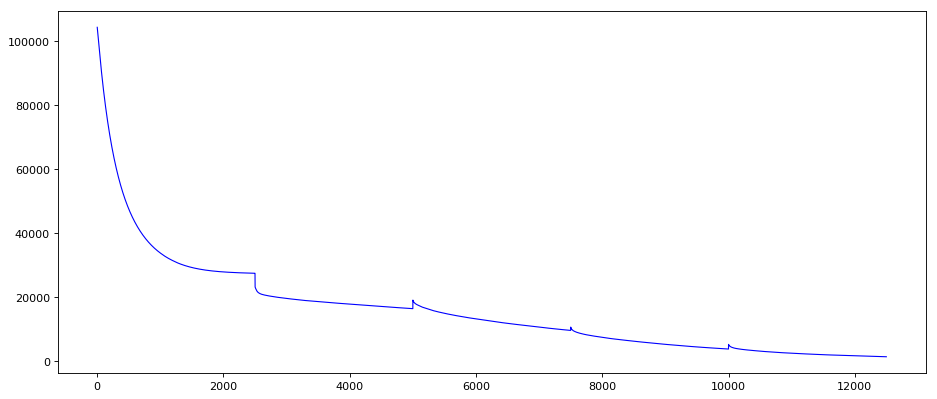

In [17]:
%matplotlib inline  
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(batch_in)
ax.plot(range(0,len(losses)), losses, '-', color='blue', animated = True, linewidth=1)

### Test Datasets

In [18]:
def plot_sequences(data, skeleton):
    x = 0
    y = 1
    z = 2
    radius = torch.max(skeleton.offsets()).item() * 5 # Heuristic that works well with many skeletons

    skeleton_parents = skeleton.parents()

    plt.ioff()
    fig = plt.figure(figsize=(12, 4))
    frames = np.arange(0, data.shape[0])
    for frame in frames:
        frame_index = frame+1
        ax = fig.add_subplot(2, 10, frame_index, projection='3d')
        ax.view_init(elev=20., azim=30)

        ax.set_xlim3d([-radius/2, radius/2])
        ax.set_zlim3d([0, radius])
        ax.set_ylim3d([-radius/2, radius/2])
        ax.set_aspect('equal')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.dist = 7.5

        lines = []

        trajectory = data[:, 0, [0, 2]]
        avg_segment_length = np.mean(np.linalg.norm(np.diff(trajectory, axis=0), axis=1)) + 1e-3
        draw_offset = int(25/avg_segment_length)
        spline_line, = ax.plot(*trajectory.T)
        camera_pos = trajectory
        height_offset = np.min(data[:, :, 1]) # Min height
        data = data.copy()
        data[:, :, 1] -= height_offset

        ax.set_xlim3d([-radius/2 + camera_pos[frame, 0], radius/2 + camera_pos[frame, 0]])
        ax.set_ylim3d([-radius/2 + camera_pos[frame, 1], radius/2 + camera_pos[frame, 1]])

        positions_world = data[frame]
        for i in range(positions_world.shape[0]):
            col = 'red' if i in skeleton.joints_right() else 'black' # As in audio cables :)
            lines.append(ax.plot([positions_world[i, x], positions_world[skeleton_parents[i], x]],
                [positions_world[i, y], positions_world[skeleton_parents[i], y]],
                [positions_world[i, z], positions_world[skeleton_parents[i], z]], zdir='y', c=col))
        l = max(frame-draw_offset, 0)
        r = min(frame+draw_offset, trajectory.shape[0])
        spline_line.set_xdata(trajectory[l:r, 0])
        spline_line.set_ydata(np.zeros_like(trajectory[l:r, 0]))
        spline_line.set_3d_properties(trajectory[l:r, 1], zdir='y')
    plt.tight_layout()
    #plt.savefig("plots/takingphoto.png")
    plt.show()

In [19]:
for test_batch_in, test_batch_out in _prepare_next_batch_impl(batch_size, dataset, target_length, sequences_test):
    y_pred = mod_2.predict(test_batch_in)
    y_pred = y_pred.reshape(60,20,32,3)
    test_batch_out = test_batch_out.reshape(60,20,32,3)

<IPython.core.display.Javascript object>


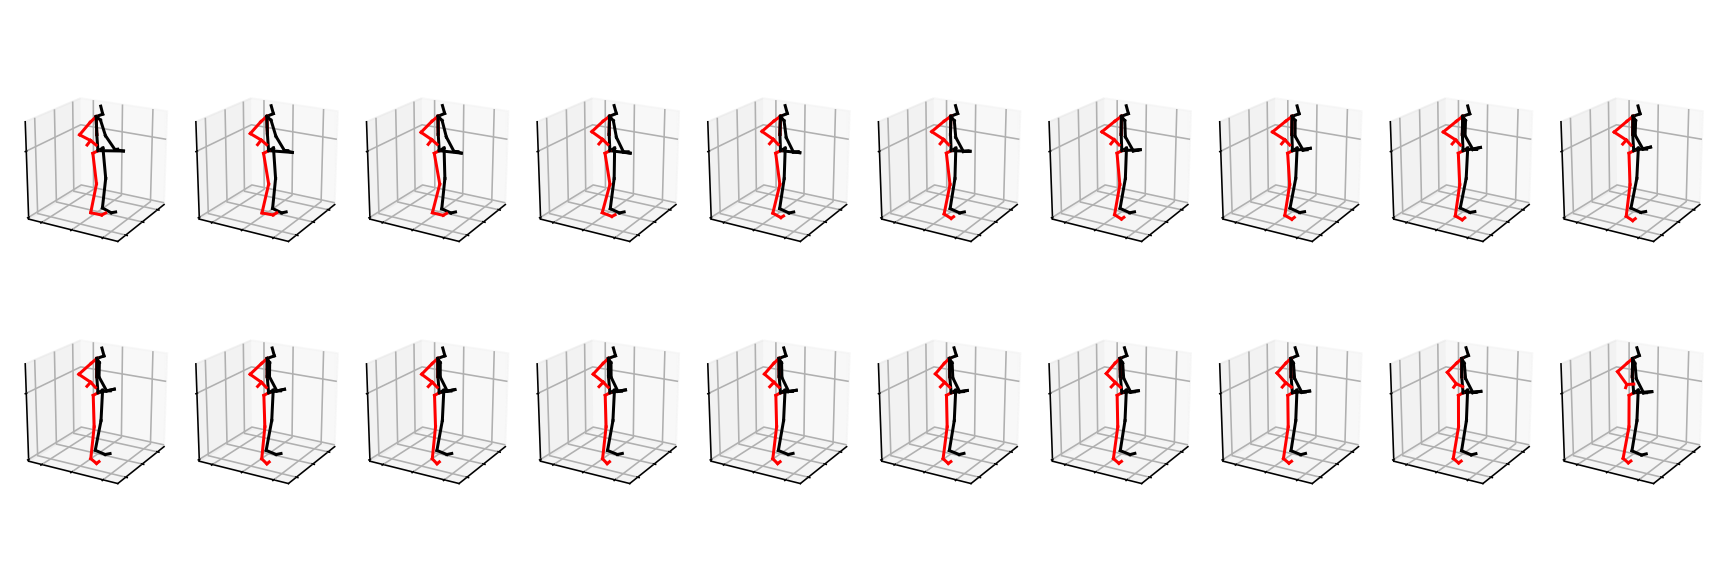

<IPython.core.display.Javascript object>


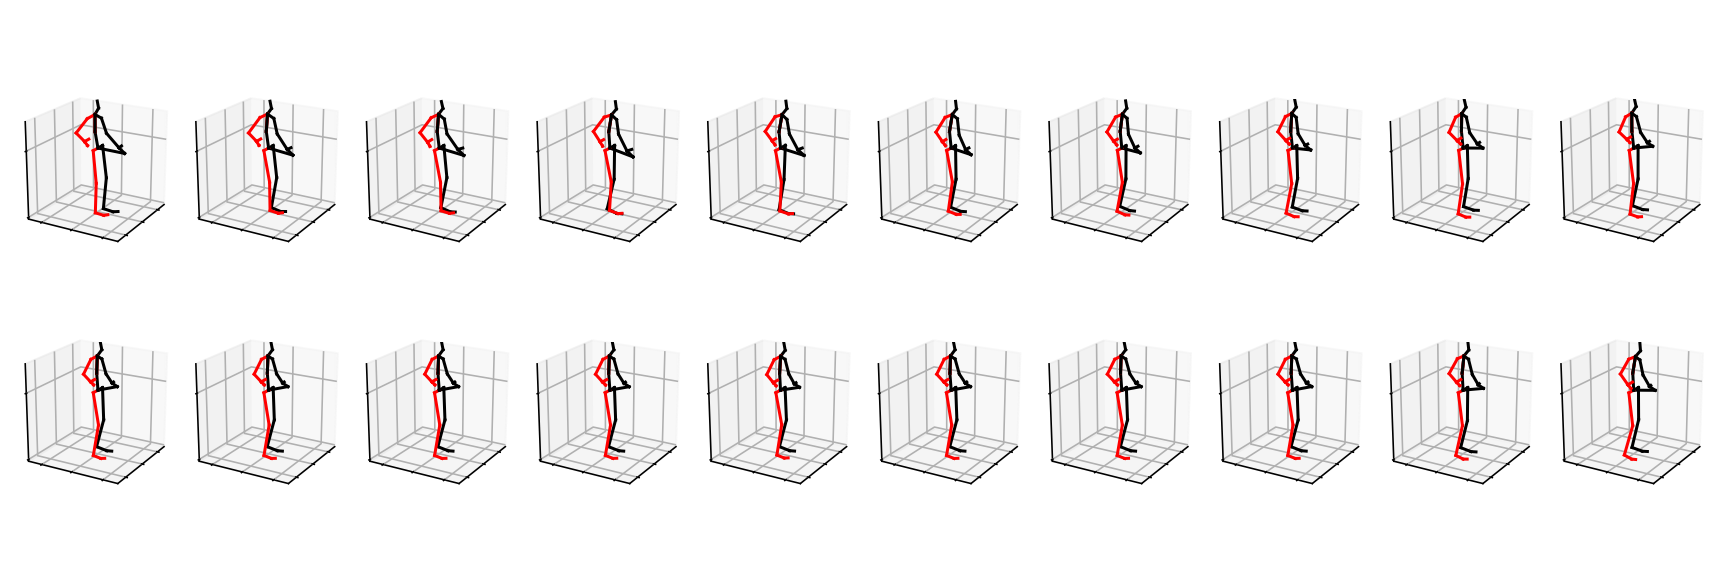

In [21]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
plot_sequences(test_batch_out[15,:,:,:], dataset.skeleton())
plot_sequences(y_pred[15,:,:,:], dataset.skeleton())

In [22]:
def mse_test_cal(actual_data, predicted_data):
    print(actual_data.shape)
    num_seq = actual_data.shape[0]
    mse_test_seq = []
    for i in range(0,num_seq):
        nsamples, nx, ny = actual_data[i,:,:,:].shape
        y_test = actual_data[i,:,:,:].reshape((nsamples,nx*ny))
        yhat_pred = predicted_data[i,:,:,:].reshape((nsamples,nx*ny))
        mse = mean_squared_error(y_test, yhat_pred)
        mse_test_seq.append(mse)
    return mse_test_seq

In [23]:
mse_real_rnn = mse_test_cal(test_batch_out, y_pred)
print("MSE:%.2f" % mse_real_rnn[15])
print("MSE:%.2f" % mse_real_rnn[0])
print("MSE:%.2f" % mse_real_rnn[58])

(60, 20, 32, 3)
MSE:2417.06
MSE:3795.10
MSE:9279.71


### Complex-weighted RNN

In [24]:
#from URNN import URNNCell
from complex_valued_models.SimpleURNN import SimpleURNNCell
tf.reset_default_graph()

n_steps = 20 #number of periods per vector we are using to predict one period ahead
n_inputs = 96 #number of vectors submitted
n_neurons = 520 #number of neurons we will recursively work through, can be changed to improve accuracy
n_outputs = 96 #number of output vectors

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

basic_cell = SimpleURNNCell(num_units=n_neurons, num_in=96)
rnn_outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) #Choose dynamic over static

learning_rate = 0.001 # Small learning rate so we don't overshoot the minimum

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, 2*n_neurons]) #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs) #specify the type of layers
simple_urnn_outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs]) #shape of results

loss = tf.reduce_mean(tf.square(simple_urnn_outputs-y)) #define the cost function

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) #gradient descent method
training_op = optimizer.minimize(loss) #train the result of the application of the cost function

init = tf.global_variables_initializer() # initialize all the variables

In [25]:
for batch_in, batch_out in _prepare_next_batch_impl(batch_size, dataset, target_length, sequences_train):
    x_train = batch_in
    y_train = batch_out
for batch_in, batch_out in _prepare_next_batch_impl(batch_size, dataset, target_length, sequences_valid):
    x_valid = batch_in
    y_valid = batch_out
x_test = test_batch_in
y_test = test_batch_out

In [26]:
print(x_train.shape, y_train.shape)

(60, 20, 96) (60, 20, 96)


In [27]:
n_iterations =2500
batch_size = 60
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        sess.run(training_op, feed_dict={X: x_train, y: y_train})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print(iteration, "\MSE:", mse)
            
    y_pred_complexRNN = sess.run(simple_urnn_outputs, feed_dict={X: x_test})

0 \MSE: 266144.6
100 \MSE: 6561.4844
200 \MSE: 3813.4995
300 \MSE: 2777.3965
400 \MSE: 2210.0808
500 \MSE: 1844.5903
600 \MSE: 1587.645
700 \MSE: 1397.0533
800 \MSE: 1250.4558
900 \MSE: 1134.4987
1000 \MSE: 1040.583
1100 \MSE: 963.2757
1200 \MSE: 898.4733
1300 \MSE: 842.98627
1400 \MSE: 795.3579
1500 \MSE: 753.4036
1600 \MSE: 716.35895
1700 \MSE: 683.476
1800 \MSE: 653.2814
1900 \MSE: 626.51575
2000 \MSE: 600.42126
2100 \MSE: 588.25903
2200 \MSE: 566.05664
2300 \MSE: 539.58417
2400 \MSE: 531.1284


<IPython.core.display.Javascript object>


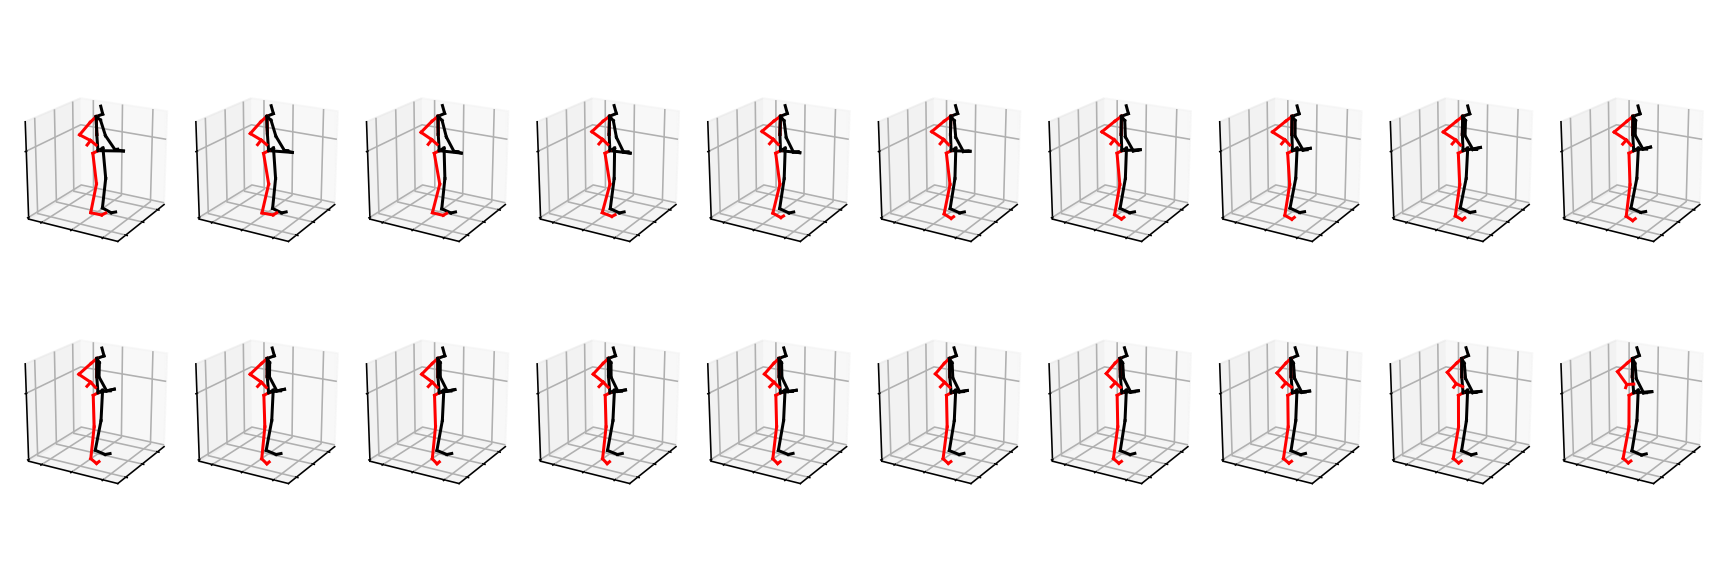

<IPython.core.display.Javascript object>


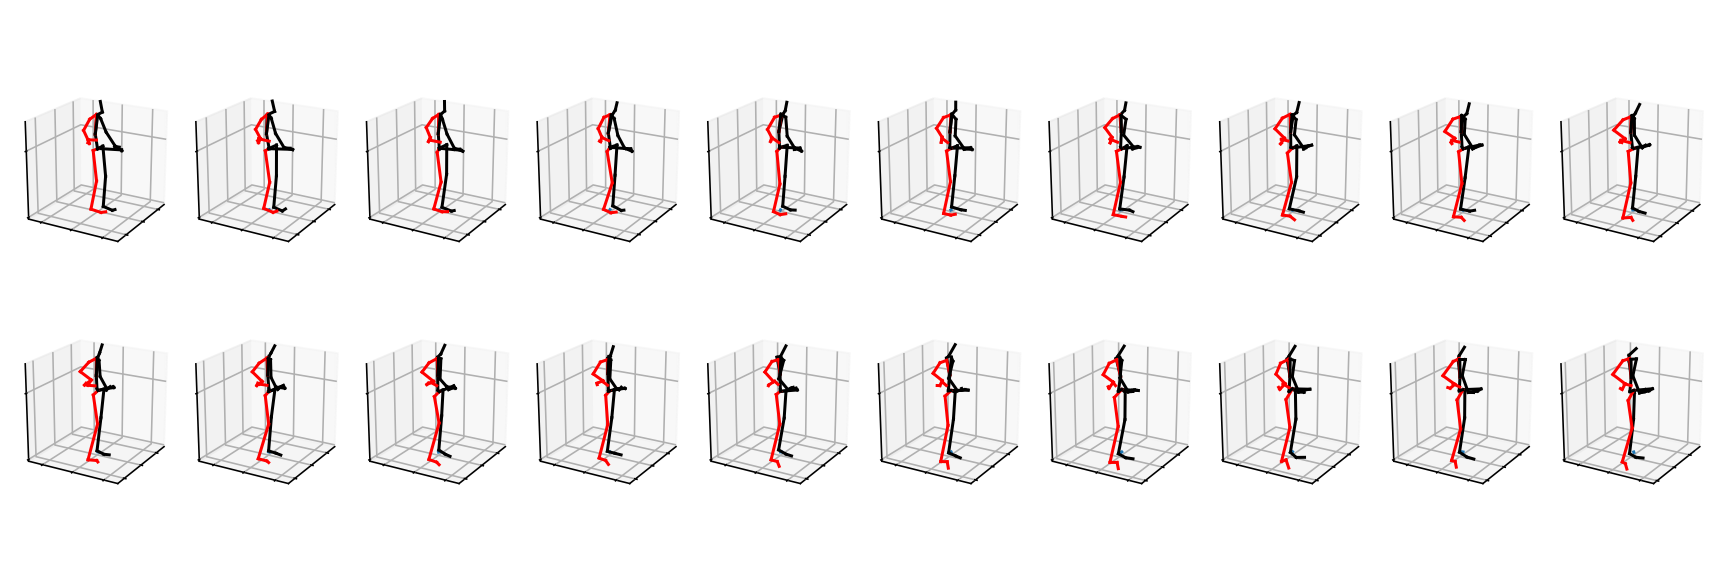

In [28]:
y_pred = y_pred_complexRNN.reshape(60,20,32,3)
y_test = y_test.reshape(60,20,32,3)
plot_sequences(y_test[15,:,:,:], dataset.skeleton())
plot_sequences(y_pred[15,:,:,:], dataset.skeleton())

In [29]:
mse_complex_rnn = mse_test_cal(y_test, y_pred)
print("MSE:%.2f" % mse_complex_rnn[15])
print("MSE:%.2f" % mse_complex_rnn[0])
print("MSE:%.2f" % mse_complex_rnn[58])

(60, 20, 32, 3)
MSE:512.29
MSE:895.45
MSE:2019.24


### Unitary Evolution RNN

In [30]:
from complex_valued_models.URNN import URNNCell
tf.reset_default_graph()

n_steps = 20 #number of periods per vector we are using to predict one period ahead
n_inputs = 96 #number of vectors submitted
n_neurons = 520 #number of neurons we will recursively work through, can be changed to improve accuracy
n_outputs = 96 #number of output vectors

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

basic_cell = SimpleURNNCell(num_units=n_neurons, num_in=96)
rnn_outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) #Choose dynamic over static

learning_rate = 0.001 # Small learning rate so we don't overshoot the minimum

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, 2*n_neurons]) #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs) #specify the type of layers
urnn_outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs]) #shape of results

loss = tf.reduce_mean(tf.square(urnn_outputs-y)) #define the cost function

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) #gradient descent method
training_op = optimizer.minimize(loss) #train the result of the application of the cost function

init = tf.global_variables_initializer() # initialize all the variables

In [31]:
x_test = test_batch_in
y_test = test_batch_out
n_iterations =2500
batch_size = 60
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        sess.run(training_op, feed_dict={X: x_train, y: y_train})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print(iteration, "\MSE:", mse)
            
    y_pred_eunn = sess.run(urnn_outputs, feed_dict={X: x_test})

0 \MSE: 244884.08
100 \MSE: 6382.8955
200 \MSE: 3881.9072
300 \MSE: 2846.649
400 \MSE: 2256.0503
500 \MSE: 1874.6753
600 \MSE: 1609.2
700 \MSE: 1414.0839
800 \MSE: 1264.6962
900 \MSE: 1146.5405
1000 \MSE: 1050.708
1100 \MSE: 971.23553
1200 \MSE: 903.8892
1300 \MSE: 847.5066
1400 \MSE: 796.85474
1500 \MSE: 753.5947
1600 \MSE: 716.6054
1700 \MSE: 687.62933
1800 \MSE: 746.1806
1900 \MSE: 666.1028
2000 \MSE: 595.93243
2100 \MSE: 572.0713
2200 \MSE: 556.2504
2300 \MSE: 545.5144
2400 \MSE: 515.512


<IPython.core.display.Javascript object>


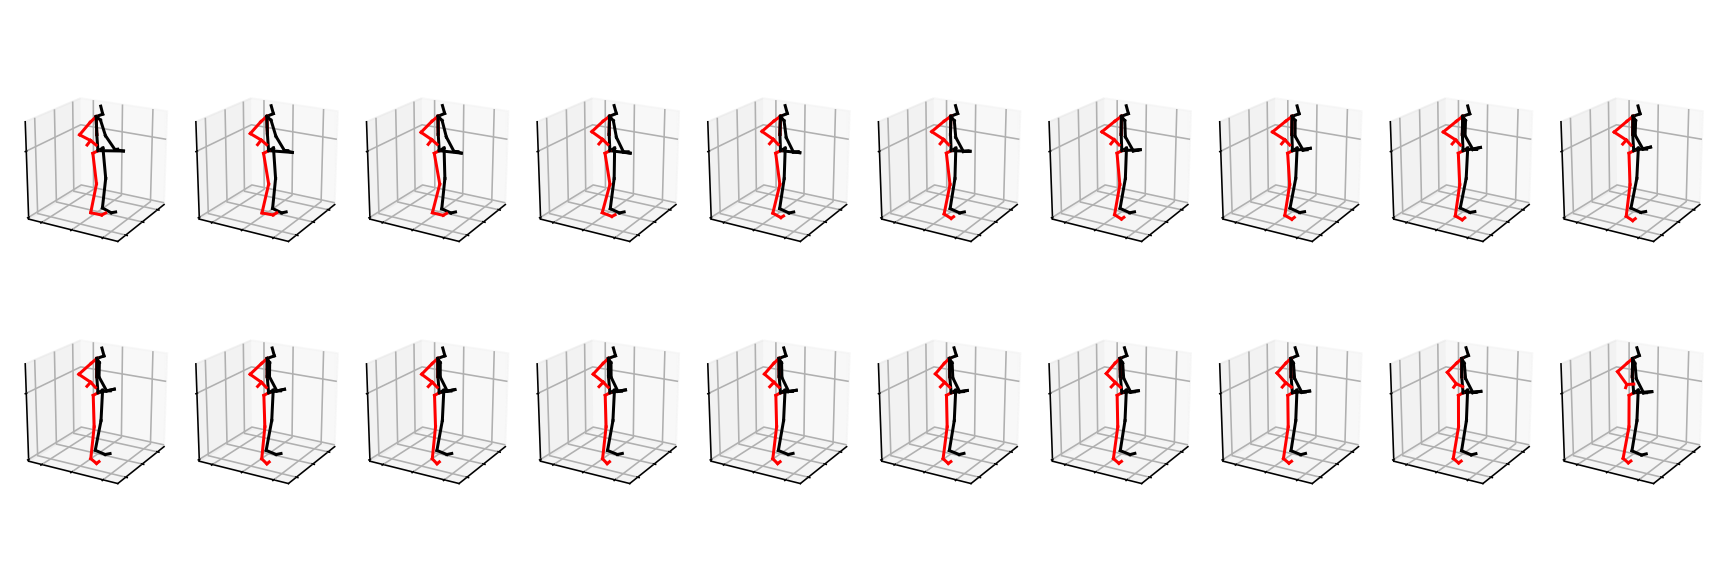

<IPython.core.display.Javascript object>


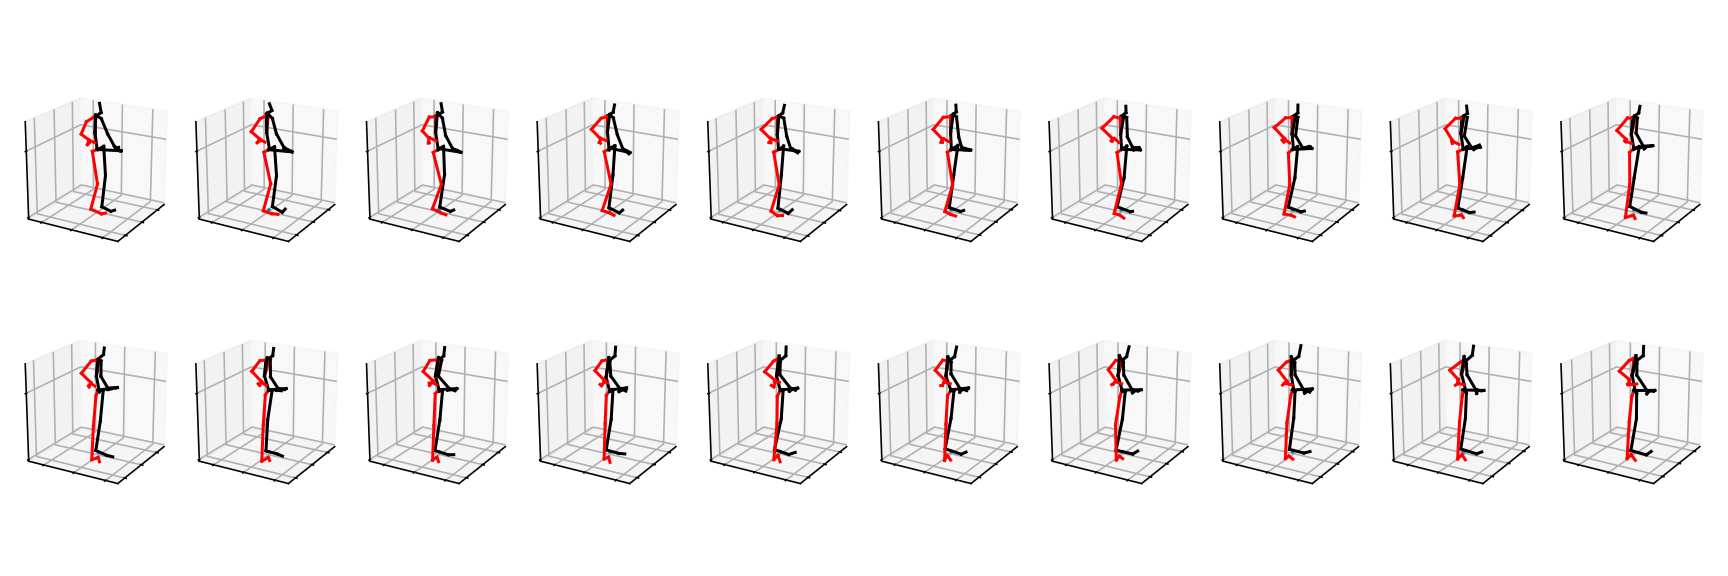

In [32]:
y_pred = y_pred_eunn.reshape(60,20,32,3)
y_test = y_test.reshape(60,20,32,3)
plot_sequences(y_test[15,:,:,:], dataset.skeleton())
plot_sequences(y_pred[15,:,:,:], dataset.skeleton())

In [33]:
mse_complex_urnn = mse_test_cal(y_test, y_pred)
print("MSE:%.2f" % mse_complex_urnn[15])
print("MSE:%.2f" % mse_complex_urnn[0])
print("MSE:%.2f" % mse_complex_urnn[58])

(60, 20, 32, 3)
MSE:440.10
MSE:850.80
MSE:1849.94


### Tunable Efficient Unitary RNN

In [34]:
tf.reset_default_graph()

n_steps = 20 #number of periods per vector we are using to predict one period ahead
n_inputs = 96 #number of vectors submitted
n_neurons = 520 #number of neurons we will recursively work through, can be changed to improve accuracy
n_outputs = 96 #number of output vectors

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

#basic_cell = rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
cell = ComplexRNNCell(n_neurons, 2)
hidden_out_comp, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.complex64) #Choose dynamic over static
rnn_outputs = tf.real(hidden_out_comp)


learning_rate = 3e-3 # Small learning rate so we don't overshoot the minimum

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs) #specify the type of layers
eurnn_outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs]) #shape of results

loss = tf.reduce_mean(tf.square(eurnn_outputs-y)) #define the cost function

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=0.7) #gradient descent method
training_op = optimizer.minimize(loss) #train the result of the application of the cost function

init = tf.global_variables_initializer() # initialize all the variables

In [35]:
x_test = test_batch_in
y_test = test_batch_out
n_iterations =2500
batch_size = 60
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        sess.run(training_op, feed_dict={X: x_train, y: y_train})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print(iteration, "\MSE:", mse)
            
    y_pred_teunn = sess.run(eurnn_outputs, feed_dict={X: x_test})

0 \MSE: 8701724.0
100 \MSE: 131636.38
200 \MSE: 36462.137
300 \MSE: 11805.901
400 \MSE: 7950.8467
500 \MSE: 6269.319
600 \MSE: 1471.642
700 \MSE: 6616.271
800 \MSE: 1413.4137
900 \MSE: 4810.7656
1000 \MSE: 10523.587
1100 \MSE: 1433.5908
1200 \MSE: 3556.8828
1300 \MSE: 6848.153
1400 \MSE: 1500.1064
1500 \MSE: 705.9251
1600 \MSE: 988.5729
1700 \MSE: 10394.483
1800 \MSE: 2464.5862
1900 \MSE: 1897.3031
2000 \MSE: 876.8925
2100 \MSE: 732.5628
2200 \MSE: 15176.622
2300 \MSE: 2425.604
2400 \MSE: 677.2929


<IPython.core.display.Javascript object>


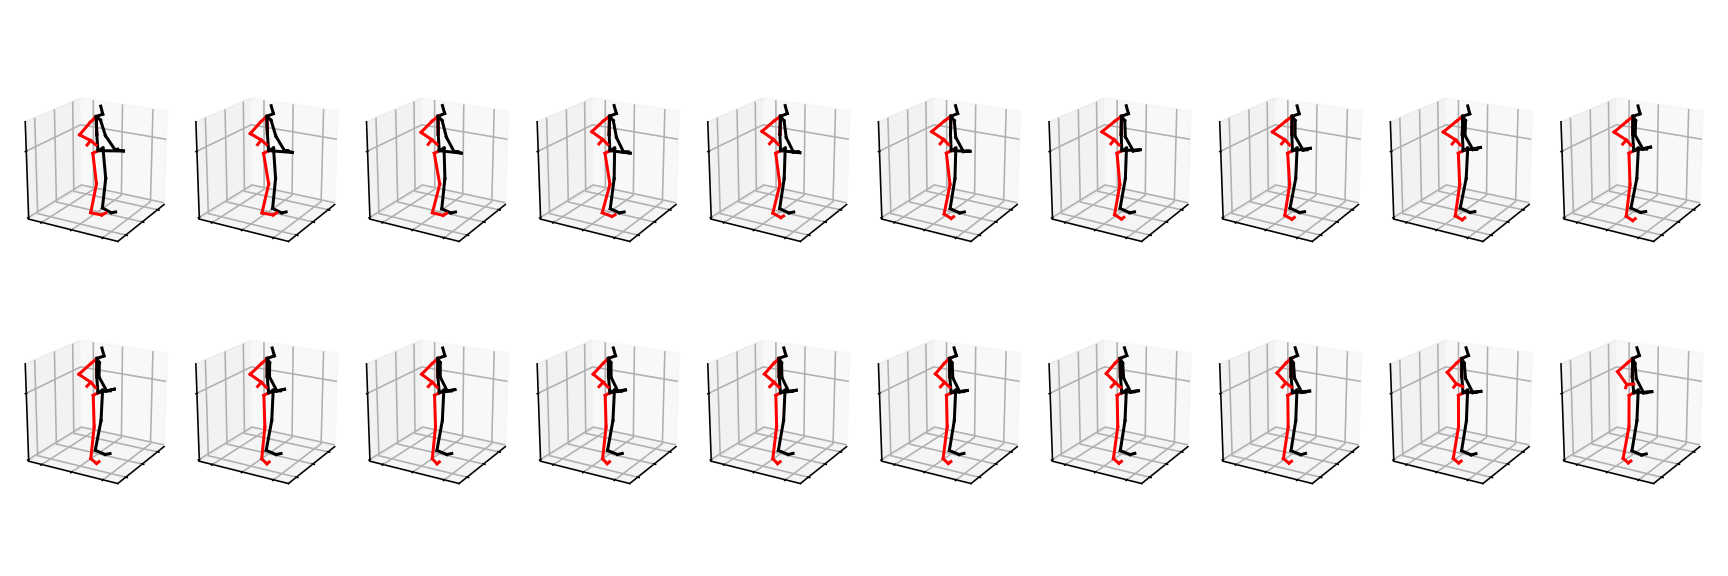

<IPython.core.display.Javascript object>


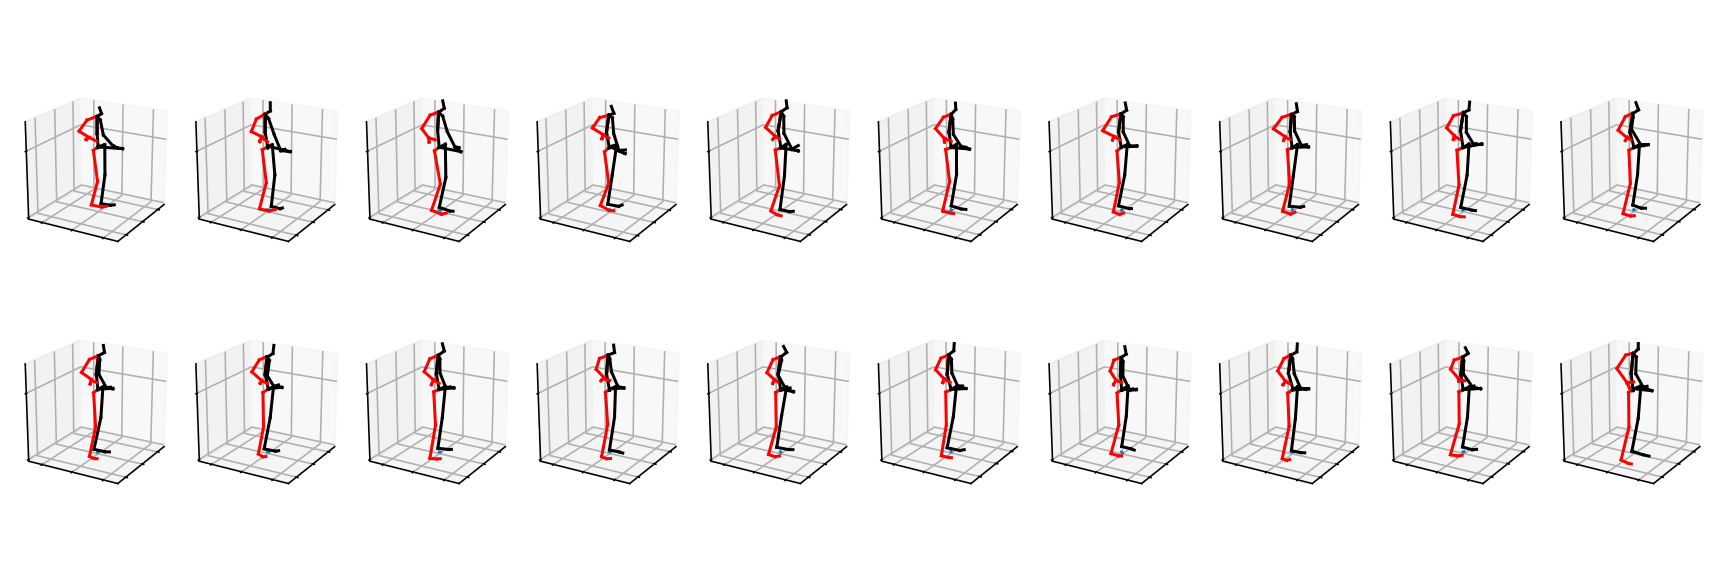

In [36]:
y_pred = y_pred_teunn.reshape(60,20,32,3)
y_test = y_test.reshape(60,20,32,3)
plot_sequences(y_test[15,:,:,:], dataset.skeleton())
plot_sequences(y_pred[15,:,:,:], dataset.skeleton())

In [37]:
mse_complex_tunable_eunn = mse_test_cal(y_test, y_pred)
print("MSE:%.2f" % mse_complex_tunable_eunn[15])
print("MSE:%.2f" % mse_complex_tunable_eunn[0])
print("MSE:%.2f" % mse_complex_tunable_eunn[58])

(60, 20, 32, 3)
MSE:493.15
MSE:640.58
MSE:1879.99


In [38]:
import pandas as pd
human_motion_forecast = pd.DataFrame(
    {'Real-valued RNN': mse_real_rnn,
     'Complex-valued RNN': mse_complex_rnn,
     'URNN': mse_complex_urnn,
     'EUNN': mse_complex_tunable_eunn
    })

In [39]:
human_motion_forecast.to_csv("results/human_motion_forecast.csv")

### T-test to determine the statistical significance

In [44]:
from scipy.stats import ttest_ind

print(ttest_ind(human_motion_forecast['Real-valued RNN'], human_motion_forecast['Complex-valued RNN']))
print(ttest_ind(human_motion_forecast['Real-valued RNN'], human_motion_forecast['URNN']))
print(ttest_ind(human_motion_forecast['Real-valued RNN'], human_motion_forecast['EUNN']))

Ttest_indResult(statistic=7.771732833161205, pvalue=3.1784598507078946e-12)
Ttest_indResult(statistic=7.795130675727849, pvalue=2.812759861793736e-12)
Ttest_indResult(statistic=7.7036032366428016, pvalue=4.534384169199763e-12)
